In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import KNNImputer


from sklearn.model_selection import train_test_split


In [ ]:
#Used to view long lists of output if needed
#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 1000)
#pd.set_option('display.max_columns', 1000)
#pd.set_option('display.width', 1000)

In [2]:
Complete_HWC_Data = pd.read_csv("/Users/nerdbear/Downloads/Complete_HWC_Data.csv", index_col=0, dtype=str, encoding='utf8')
#Complete_HWC_Data[Complete_HWC_Data.columns[0:20]] = Complete_HWC_Data[Complete_HWC_Data.columns[0:20]].astype("str")
Complete_HWC_Data[Complete_HWC_Data.columns[20:158]] = Complete_HWC_Data[Complete_HWC_Data.columns[20:158]].astype("float")
Complete_HWC_Data["Sum of Number of Animals"] = Complete_HWC_Data["Sum of Number of Animals"].astype("float")
Complete_HWC_Data["Total Staff Hours"] = Complete_HWC_Data["Total Staff Hours"].astype("float")
Complete_HWC_Data["Total Staff Involved"] = Complete_HWC_Data["Total Staff Involved"].astype("float")
Complete_HWC_Data["Latitude Public"] = Complete_HWC_Data["Latitude Public"].astype("float")
Complete_HWC_Data["Longitude Public"] = Complete_HWC_Data["Longitude Public"].astype("float")
Complete_HWC_Data[Complete_HWC_Data.columns[20:158]] = Complete_HWC_Data[Complete_HWC_Data.columns[20:158]].astype("float")
Complete_HWC_Data.head(1)

UniqueID Incident Number Incident Date        Field Unit  \
0  BAN2010-0003.3    BAN2010-0003    2010-01-01  Banff Field Unit   

         Protected Heritage Area               Incident Type  Latitude Public  \
0  Banff National Park of Canada  Human Wildlife Interaction        51.161093   

   Longitude Public Within Park  Total Staff Involved  ...  \
0       -115.593386         Yes                   1.0  ...   

   Response Type_Rehabilitate area Response Type_Relocate animal (s)  \
0                              0.0                               0.0   

   Response Type_Request assistance - other Agency  \
0                                              0.0   

  Response Type_Request assistance - police Response Type_Traffic control  \
0                                       0.0                           0.0   

  Response Type_Translocate Response Type_Trap or snare  \
0                       0.0                         0.0   

  Response Type_Unable to respond Response Type_Warning signs  \
0                             0.0                         0.0   

  Response Type_nan  
0               0.0  

[1 rows x 158 columns]

**Removing Response Type from the Data. "Response Type" is inherently dependent on the "Incident Type" and should not be included for the modeling.**


In [3]:
Data = Complete_HWC_Data.iloc[:, 0:108]
Data.head(1)

UniqueID Incident Number Incident Date        Field Unit  \
0  BAN2010-0003.3    BAN2010-0003    2010-01-01  Banff Field Unit   

         Protected Heritage Area               Incident Type  Latitude Public  \
0  Banff National Park of Canada  Human Wildlife Interaction        51.161093   

   Longitude Public Within Park  Total Staff Involved  ...  \
0       -115.593386         Yes                   1.0  ...   

   Activity Type_Swimming - Cliff Jumping Activity Type_Swimming - Coastal  \
0                                     0.0                              0.0   

   Activity Type_Swimming - Facilities Activity Type_Swimming - Flat Water  \
0                                  0.0                                 0.0   

  Activity Type_Swimming - Swiftwater Activity Type_Townsite Activity  \
0                                 0.0                             0.0   

  Activity Type_Tram/Ski Lift/Gondola Activity Type_Tubing / River Drifting  \
0                                 0.0                                   0.0   

  Activity Type_Unknown Activity Type_Via-Ferrata  
0                   0.0                       0.0  

[1 rows x 108 columns]

### Preprocessing

In [4]:
#Ensuring Data is sorted by incident date

Data = Data.sort_values(by=['Incident Date'])
Data = Data.reset_index(drop=True)
Data = Data.set_index("Incident Date")
Data.head(1)

UniqueID Incident Number        Field Unit  \
Incident Date                                                     
2010-01-01     BAN2010-0003.3    BAN2010-0003  Banff Field Unit   

                     Protected Heritage Area               Incident Type  \
Incident Date                                                              
2010-01-01     Banff National Park of Canada  Human Wildlife Interaction   

               Latitude Public  Longitude Public Within Park  \
Incident Date                                                  
2010-01-01           51.161093       -115.593386         Yes   

               Total Staff Involved  Total Staff Hours  ...  \
Incident Date                                           ...   
2010-01-01                      1.0               2.33  ...   

              Activity Type_Swimming - Cliff Jumping  \
Incident Date                                          
2010-01-01                                       0.0   

               Activity Type_Swimming - Coastal  \
Incident Date                                     
2010-01-01                                  0.0   

              Activity Type_Swimming - Facilities  \
Incident Date                                       
2010-01-01                                    0.0   

              Activity Type_Swimming - Flat Water  \
Incident Date                                       
2010-01-01                                    0.0   

              Activity Type_Swimming - Swiftwater  \
Incident Date                                       
2010-01-01                                    0.0   

              Activity Type_Townsite Activity  \
Incident Date                                   
2010-01-01                                0.0   

              Activity Type_Tram/Ski Lift/Gondola  \
Incident Date                                       
2010-01-01                                    0.0   

              Activity Type_Tubing / River Drifting Activity Type_Unknown  \
Incident Date                                                               
2010-01-01                                      0.0                   0.0   

               Activity Type_Via-Ferrata  
Incident Date                             
2010-01-01                           0.0  

[1 rows x 107 columns]

In [5]:
Data.insert(0, 'Incident Year', pd.DatetimeIndex(Data.index).year)
Data.insert(1, 'Incident Month', pd.DatetimeIndex(Data.index).month)
Data["Incident Year"] = Data["Incident Year"].astype("str")
Data["Incident Month"] = Data["Incident Month"].astype("str")
#Dropping these columns that are either not features for modeling or have too many missing values to be imputed 
#(35% missing values which is over the threshold of 10% I've chosen)
Data = Data.drop(["UniqueID", "Incident Number", "Animal Health Status", "Cause of Animal Health Status", "Animal Behaviour", "Reason for Animal Behaviour", "Animal Attractant", "Deterrents Used", "Animal Response to Deterrents"], axis=1)
Data.head(1)

Incident Year Incident Month        Field Unit  \
Incident Date                                                  
2010-01-01             2010              1  Banff Field Unit   

                     Protected Heritage Area               Incident Type  \
Incident Date                                                              
2010-01-01     Banff National Park of Canada  Human Wildlife Interaction   

               Latitude Public  Longitude Public Within Park  \
Incident Date                                                  
2010-01-01           51.161093       -115.593386         Yes   

               Total Staff Involved  Total Staff Hours  ...  \
Incident Date                                           ...   
2010-01-01                      1.0               2.33  ...   

              Activity Type_Swimming - Cliff Jumping  \
Incident Date                                          
2010-01-01                                       0.0   

               Activity Type_Swimming - Coastal  \
Incident Date                                     
2010-01-01                                  0.0   

               Activity Type_Swimming - Facilities  \
Incident Date                                        
2010-01-01                                     0.0   

               Activity Type_Swimming - Flat Water  \
Incident Date                                        
2010-01-01                                     0.0   

               Activity Type_Swimming - Swiftwater  \
Incident Date                                        
2010-01-01                                     0.0   

               Activity Type_Townsite Activity  \
Incident Date                                    
2010-01-01                                 0.0   

               Activity Type_Tram/Ski Lift/Gondola  \
Incident Date                                        
2010-01-01                                     0.0   

               Activity Type_Tubing / River Drifting  Activity Type_Unknown  \
Incident Date                                                                 
2010-01-01                                       0.0                    0.0   

               Activity Type_Via-Ferrata  
Incident Date                             
2010-01-01                           0.0  

[1 rows x 100 columns]

This TimeSeriesSplit function seems great, but I wasn't able to figure out how to then loop and apply all my next steps to the 5 train sets before modeling (those next steps being imputations, encoding, balancing, feature selection, etc) I wasn't able to find any good resources online that showed how to do thisall examples I could find seemed to be on data that was already ready to be modeled (i.e. no missing data, no encoding needed, etc.) I'm sure I could have figured out some loops and functions, but I didn't have enough time to figure out creating those within the scope of this project so: i decided to manually created my splits by time in order to be able to have 5 splits and also apply my "next steps" to each split.




**Splitting data**

**I wasn't able to figure out how to automatically create these sets and then be able to apply encoding, feature selection, imputation, etc on the individual folds afterwards. Creating the folds manually: one would be 2010-2012 train (2013 test), the next 2010-2014 train (2015 test), 2010-2016 train (2017 test), 2010-2018 train (2019 test), and then the final of 2010-2020 train (2021 test).**

In [6]:
train_set1=Data.loc[Data['Incident Year'].isin(['2010', '2011', '2012'])]
test_set1=Data[Data['Incident Year'].isin(['2013'])]
train_set2=Data[Data['Incident Year'].isin(['2010', '2011', '2012','2013','2014'])]
test_set2=Data[Data['Incident Year'].isin(['2015'])]
train_set3=Data[Data['Incident Year'].isin(['2010', '2011', '2012','2013','2014','2015','2016'])]
test_set3=Data[Data['Incident Year'].isin(['2017'])]
train_set4=Data[Data['Incident Year'].isin(['2010', '2011', '2012','2013','2014','2015','2016','2017','2018'])]
test_set4=Data[Data['Incident Year'].isin(['2019'])]
train_set5=Data[Data['Incident Year'].isin(['2010', '2011', '2012','2013','2014','2015','2016','2017','2018','2019','2020'])]
test_set5=Data[Data['Incident Year'].isin(['2021'])]


In [7]:
#Dropping Incident Year, i wasn't able to figure out how to encode all the data and also 
#maintain the year value in my test data (because all my test data years are different from train data years so
#all year values in test data returned as unknown and therefore that data was not useful anyway)
train_set1=train_set1.drop("Incident Year", axis=1)
test_set1=test_set1.drop("Incident Year", axis=1)
train_set2=train_set2.drop("Incident Year", axis=1)
test_set2=test_set2.drop("Incident Year", axis=1)
train_set3=train_set3.drop("Incident Year", axis=1)
test_set3=test_set3.drop("Incident Year", axis=1)
train_set4=train_set4.drop("Incident Year", axis=1)
test_set4=test_set4.drop("Incident Year", axis=1)
train_set5=train_set5.drop("Incident Year", axis=1)
test_set5=test_set5.drop("Incident Year", axis=1)


## Dealing with missing values in training set

Imputing missing values on the 5 train sets. Not imputing missing values on test set; however, where I decide there are too many missing values in the train set for imputation and decide to drop those columns, I will also drop the columns in test set. Further any columns that get dropped with be droppd for all train and test sets so they all have the same features. 

Minimal missing values in **"Species Common Name" and Sum Number of Animals"**, will impute with most frequen species.  

**Latitude and Longitude** are only missing for a few (10 - XX rows) so I will impute. Because Latitude and Longitude are very much dependent on location, I will impute these values based on the mean of the Latiude and Longitude for that specific Protected Heritage Area (i.e. Park).

Will impute **"Within Park"** with most frequent response. #The best way I found to do this was using dictionaries and mapping. 

For 1 missing value in all **"Activity Type"** columns, these missing values occur in only
#1 rows of data. I'm going to just drop those two rows of data. KNN imputation cannot be 
#used on categorical data, and it is only 1 row of data. The reason for the missing data is likely because these two incident numbers existed in the "Incident Type" datasetbut not in the "Animals" or "Activities" dataset. Becuase this one rows are missing so much info and there are only 2, better to just remove them. 

Ideal threshold for values to impute of about 25% (based on a few different articles). 
That seems quite high to me, I would like to use a threshold of 10% for missing values, anything more than 10% I will not impute. 
All of the following attributes have over had 35% of train_set with missing data (across all 5 train sets) which is
too much to impute. I dropped these columns before splitting the data so they would be removed from both train and test data (so both sets have equal number of features)
**Animal Health Status (20691)**
**Cause of Animal Health Status (44243)**
**Animal Behaviour (20151)**
**Reason for Animal Behaviour (35900)**
**Animal Attractant (36667)**
**Deterrents Used (41203)**
**Animal Response to Deterrents (49724)**


In [8]:
train_set1.isna().sum()

Incident Month                            0
Field Unit                                0
Protected Heritage Area                   0
Incident Type                             0
Latitude Public                          10
                                         ..
Activity Type_Townsite Activity           0
Activity Type_Tram/Ski Lift/Gondola       0
Activity Type_Tubing / River Drifting     0
Activity Type_Unknown                     0
Activity Type_Via-Ferrata                 0
Length: 99, dtype: int64

In [9]:
#Train_set1


#Species Common Name and Sum Number of Animals
train_set1["Species Common Name"]=train_set1["Species Common Name"].fillna(train_set1["Species Common Name"].value_counts().index[0])
train_set1["Sum of Number of Animals"]=train_set1["Sum of Number of Animals"].fillna(train_set1["Sum of Number of Animals"].value_counts().index[0])

#Latitude and Longitude
#Creating dictionaries to use for imputation re most frequent latitude/longitude by park.
lon_keys = train_set1["Protected Heritage Area"].loc[train_set1["Longitude Public"].isna() == True].unique()
lon_map_dict = dict.fromkeys(lon_keys)
lon_map_dict = {"Grasslands National Park of Canada": train_set1["Longitude Public"].loc[train_set1["Protected Heritage Area"] == "Grasslands National Park of Canada"].mean(), 
          "Bruce Peninsula National Park of Canada": train_set1["Longitude Public"].loc[train_set1["Protected Heritage Area"] == "Bruce Peninsula National Park of Canada"].mean(), 
          "Pacific Rim National Park Reserve of Canada": train_set1["Longitude Public"].loc[train_set1["Protected Heritage Area"] == "Pacific Rim National Park Reserve of Canada"].mean(),
          "Point Pelee National Park of Canada": train_set1["Longitude Public"].loc[train_set1["Protected Heritage Area"] == "Point Pelee National Park of Canada"].mean(),
          "Kejimkujik National Park and National Historic Site of Canada":train_set1["Longitude Public"].loc[train_set1["Protected Heritage Area"] == "Kejimkujik National Park and National Historic Site of Canada"].mean(),
          'Prince Edward Island National Park of Canada':train_set1["Longitude Public"].loc[train_set1["Protected Heritage Area"] == "Prince Edward Island National Park of Canada"].mean(),
          'Banff National Park of Canada':train_set1["Longitude Public"].loc[train_set1["Protected Heritage Area"] == "Banff National Park of Canada"].mean(),
         }
lat_keys = train_set1["Protected Heritage Area"].loc[train_set1["Latitude Public"].isna() == True].unique()

lat_map_dict = dict.fromkeys(lat_keys)
lat_map_dict = {"Grasslands National Park of Canada": train_set1["Latitude Public"].loc[train_set1["Protected Heritage Area"] == "Grasslands National Park of Canada"].mean(), 
          "Bruce Peninsula National Park of Canada": train_set1["Latitude Public"].loc[train_set1["Protected Heritage Area"] == "Bruce Peninsula National Park of Canada"].mean(), 
          "Pacific Rim National Park Reserve of Canada": train_set1["Latitude Public"].loc[train_set1["Protected Heritage Area"] == "Pacific Rim National Park Reserve of Canada"].mean(),
          "Point Pelee National Park of Canada": train_set1["Latitude Public"].loc[train_set1["Protected Heritage Area"] == "Point Pelee National Park of Canada"].mean(),
          "Kejimkujik National Park and National Historic Site of Canada":train_set1["Latitude Public"].loc[train_set1["Protected Heritage Area"] == "Kejimkujik National Park and National Historic Site of Canada"].mean(),
          'Prince Edward Island National Park of Canada':train_set1["Latitude Public"].loc[train_set1["Protected Heritage Area"] == "Prince Edward Island National Park of Canada"].mean(),
          'Banff National Park of Canada':train_set1["Latitude Public"].loc[train_set1["Protected Heritage Area"] == "Banff National Park of Canada"].mean(),
         }

#imputing lat and lon values based on dictionaries
train_set1["Longitude Public"]=train_set1["Longitude Public"].fillna(train_set1["Protected Heritage Area"].map(lon_map_dict))
train_set1["Latitude Public"]=train_set1["Latitude Public"].fillna(train_set1["Protected Heritage Area"].map(lat_map_dict))

#Checking for remaining missing values in train_set1
train_set1.isnull().sum()
#No more missing values



Incident Month                           0
Field Unit                               0
Protected Heritage Area                  0
Incident Type                            0
Latitude Public                          0
                                        ..
Activity Type_Townsite Activity          0
Activity Type_Tram/Ski Lift/Gondola      0
Activity Type_Tubing / River Drifting    0
Activity Type_Unknown                    0
Activity Type_Via-Ferrata                0
Length: 99, dtype: int64

In [10]:
train_set2.isna().sum()

Incident Month                            0
Field Unit                                0
Protected Heritage Area                   0
Incident Type                             0
Latitude Public                          19
                                         ..
Activity Type_Townsite Activity           0
Activity Type_Tram/Ski Lift/Gondola       0
Activity Type_Tubing / River Drifting     0
Activity Type_Unknown                     0
Activity Type_Via-Ferrata                 0
Length: 99, dtype: int64

In [11]:
#Train_set2


#Species Common Name and Sum Number of Animals
train_set2["Species Common Name"]=train_set2["Species Common Name"].fillna(train_set2["Species Common Name"].value_counts().index[0])
train_set2["Sum of Number of Animals"]=train_set2["Sum of Number of Animals"].fillna(train_set2["Sum of Number of Animals"].value_counts().index[0])

#Latitude and Longitude
#Creating dictionaries to use for imputation re most frequent latitude/longitude by park.
lon_keys = train_set2["Protected Heritage Area"].loc[train_set2["Longitude Public"].isna() == True].unique()
lon_map_dict = dict.fromkeys(lon_keys)
lon_map_dict = {"Grasslands National Park of Canada": train_set2["Longitude Public"].loc[train_set2["Protected Heritage Area"] == "Grasslands National Park of Canada"].mean(), 
          "Bruce Peninsula National Park of Canada": train_set2["Longitude Public"].loc[train_set2["Protected Heritage Area"] == "Bruce Peninsula National Park of Canada"].mean(), 
          "Pacific Rim National Park Reserve of Canada": train_set2["Longitude Public"].loc[train_set2["Protected Heritage Area"] == "Pacific Rim National Park Reserve of Canada"].mean(),
          "Point Pelee National Park of Canada": train_set2["Longitude Public"].loc[train_set2["Protected Heritage Area"] == "Point Pelee National Park of Canada"].mean(),
          "Kejimkujik National Park and National Historic Site of Canada":train_set2["Longitude Public"].loc[train_set2["Protected Heritage Area"] == "Kejimkujik National Park and National Historic Site of Canada"].mean(),
          'Prince Edward Island National Park of Canada':train_set2["Longitude Public"].loc[train_set2["Protected Heritage Area"] == "Prince Edward Island National Park of Canada"].mean(),
          'Banff National Park of Canada':train_set2["Longitude Public"].loc[train_set2["Protected Heritage Area"] == "Banff National Park of Canada"].mean(),
         }
lat_keys = train_set2["Protected Heritage Area"].loc[train_set2["Latitude Public"].isna() == True].unique()

lat_map_dict = dict.fromkeys(lat_keys)
lat_map_dict = {"Grasslands National Park of Canada": train_set2["Latitude Public"].loc[train_set2["Protected Heritage Area"] == "Grasslands National Park of Canada"].mean(), 
          "Bruce Peninsula National Park of Canada": train_set2["Latitude Public"].loc[train_set2["Protected Heritage Area"] == "Bruce Peninsula National Park of Canada"].mean(), 
          "Pacific Rim National Park Reserve of Canada": train_set2["Latitude Public"].loc[train_set2["Protected Heritage Area"] == "Pacific Rim National Park Reserve of Canada"].mean(),
          "Point Pelee National Park of Canada": train_set2["Latitude Public"].loc[train_set2["Protected Heritage Area"] == "Point Pelee National Park of Canada"].mean(),
          "Kejimkujik National Park and National Historic Site of Canada":train_set2["Latitude Public"].loc[train_set2["Protected Heritage Area"] == "Kejimkujik National Park and National Historic Site of Canada"].mean(),
          'Prince Edward Island National Park of Canada':train_set2["Latitude Public"].loc[train_set2["Protected Heritage Area"] == "Prince Edward Island National Park of Canada"].mean(),
          'Banff National Park of Canada':train_set2["Latitude Public"].loc[train_set2["Protected Heritage Area"] == "Banff National Park of Canada"].mean(),
         }

#imputing lat and lon values based on dictionaries
train_set2["Longitude Public"]=train_set2["Longitude Public"].fillna(train_set2["Protected Heritage Area"].map(lon_map_dict))
train_set2["Latitude Public"]=train_set2["Latitude Public"].fillna(train_set2["Protected Heritage Area"].map(lat_map_dict))

#Checking for remaining missing values in train_set2
train_set2.isnull().sum()
#No more missing values



Incident Month                           0
Field Unit                               0
Protected Heritage Area                  0
Incident Type                            0
Latitude Public                          0
                                        ..
Activity Type_Townsite Activity          0
Activity Type_Tram/Ski Lift/Gondola      0
Activity Type_Tubing / River Drifting    0
Activity Type_Unknown                    0
Activity Type_Via-Ferrata                0
Length: 99, dtype: int64

In [12]:
train_set3.isna().sum()

Incident Month                            0
Field Unit                                0
Protected Heritage Area                   0
Incident Type                             0
Latitude Public                          25
                                         ..
Activity Type_Townsite Activity           0
Activity Type_Tram/Ski Lift/Gondola       0
Activity Type_Tubing / River Drifting     0
Activity Type_Unknown                     0
Activity Type_Via-Ferrata                 0
Length: 99, dtype: int64

In [13]:
#Train_set3

#Species Common Name and Sum Number of Animals
train_set3["Species Common Name"]=train_set3["Species Common Name"].fillna(train_set3["Species Common Name"].value_counts().index[0])
train_set3["Sum of Number of Animals"]=train_set3["Sum of Number of Animals"].fillna(train_set3["Sum of Number of Animals"].value_counts().index[0])

#Latitude and Longitude
#Creating dictionaries to use for imputation re most frequent latitude/longitude by park.
lon_keys = train_set3["Protected Heritage Area"].loc[train_set3["Longitude Public"].isna() == True].unique()
lon_map_dict = dict.fromkeys(lon_keys)
lon_map_dict = {"Grasslands National Park of Canada": train_set3["Longitude Public"].loc[train_set3["Protected Heritage Area"] == "Grasslands National Park of Canada"].mean(), 
          "Bruce Peninsula National Park of Canada": train_set3["Longitude Public"].loc[train_set3["Protected Heritage Area"] == "Bruce Peninsula National Park of Canada"].mean(), 
          "Pacific Rim National Park Reserve of Canada": train_set3["Longitude Public"].loc[train_set3["Protected Heritage Area"] == "Pacific Rim National Park Reserve of Canada"].mean(),
          "Point Pelee National Park of Canada": train_set3["Longitude Public"].loc[train_set3["Protected Heritage Area"] == "Point Pelee National Park of Canada"].mean(),
          "Kejimkujik National Park and National Historic Site of Canada":train_set3["Longitude Public"].loc[train_set3["Protected Heritage Area"] == "Kejimkujik National Park and National Historic Site of Canada"].mean(),
          'Prince Edward Island National Park of Canada':train_set3["Longitude Public"].loc[train_set3["Protected Heritage Area"] == "Prince Edward Island National Park of Canada"].mean(),
          'Banff National Park of Canada':train_set3["Longitude Public"].loc[train_set3["Protected Heritage Area"] == "Banff National Park of Canada"].mean(),
         }
lat_keys = train_set3["Protected Heritage Area"].loc[train_set3["Latitude Public"].isna() == True].unique()

lat_map_dict = dict.fromkeys(lat_keys)
lat_map_dict = {"Grasslands National Park of Canada": train_set3["Latitude Public"].loc[train_set3["Protected Heritage Area"] == "Grasslands National Park of Canada"].mean(), 
          "Bruce Peninsula National Park of Canada": train_set3["Latitude Public"].loc[train_set3["Protected Heritage Area"] == "Bruce Peninsula National Park of Canada"].mean(), 
          "Pacific Rim National Park Reserve of Canada": train_set3["Latitude Public"].loc[train_set3["Protected Heritage Area"] == "Pacific Rim National Park Reserve of Canada"].mean(),
          "Point Pelee National Park of Canada": train_set3["Latitude Public"].loc[train_set3["Protected Heritage Area"] == "Point Pelee National Park of Canada"].mean(),
          "Kejimkujik National Park and National Historic Site of Canada":train_set3["Latitude Public"].loc[train_set3["Protected Heritage Area"] == "Kejimkujik National Park and National Historic Site of Canada"].mean(),
          'Prince Edward Island National Park of Canada':train_set3["Latitude Public"].loc[train_set3["Protected Heritage Area"] == "Prince Edward Island National Park of Canada"].mean(),
          'Banff National Park of Canada':train_set3["Latitude Public"].loc[train_set3["Protected Heritage Area"] == "Banff National Park of Canada"].mean(),
         }

#imputing lat and lon values based on dictionaries
train_set3["Longitude Public"]=train_set3["Longitude Public"].fillna(train_set3["Protected Heritage Area"].map(lon_map_dict))
train_set3["Latitude Public"]=train_set3["Latitude Public"].fillna(train_set3["Protected Heritage Area"].map(lat_map_dict))

#Checking for remaining missing values in train_set3
train_set3.isnull().sum()
#No more missing values


Incident Month                           0
Field Unit                               0
Protected Heritage Area                  0
Incident Type                            0
Latitude Public                          0
                                        ..
Activity Type_Townsite Activity          0
Activity Type_Tram/Ski Lift/Gondola      0
Activity Type_Tubing / River Drifting    0
Activity Type_Unknown                    0
Activity Type_Via-Ferrata                0
Length: 99, dtype: int64

In [14]:
train_set4.isnull().sum()


Incident Month                            0
Field Unit                                0
Protected Heritage Area                   0
Incident Type                             0
Latitude Public                          28
                                         ..
Activity Type_Townsite Activity           0
Activity Type_Tram/Ski Lift/Gondola       0
Activity Type_Tubing / River Drifting     0
Activity Type_Unknown                     0
Activity Type_Via-Ferrata                 0
Length: 99, dtype: int64

In [15]:
#Train_set4


#Species Common Name and Sum Number of Animals
train_set4["Species Common Name"]=train_set4["Species Common Name"].fillna(train_set4["Species Common Name"].value_counts().index[0])
train_set4["Sum of Number of Animals"]=train_set4["Sum of Number of Animals"].fillna(train_set4["Sum of Number of Animals"].value_counts().index[0])

#Latitude and Longitude
#Creating dictionaries to use for imputation re most frequent latitude/longitude by park.
lon_keys = train_set4["Protected Heritage Area"].loc[train_set4["Longitude Public"].isna() == True].unique()
lon_map_dict = dict.fromkeys(lon_keys)
lon_map_dict = {"Grasslands National Park of Canada": train_set4["Longitude Public"].loc[train_set4["Protected Heritage Area"] == "Grasslands National Park of Canada"].mean(), 
          "Bruce Peninsula National Park of Canada": train_set4["Longitude Public"].loc[train_set4["Protected Heritage Area"] == "Bruce Peninsula National Park of Canada"].mean(), 
          "Pacific Rim National Park Reserve of Canada": train_set4["Longitude Public"].loc[train_set4["Protected Heritage Area"] == "Pacific Rim National Park Reserve of Canada"].mean(),
          "Point Pelee National Park of Canada": train_set4["Longitude Public"].loc[train_set4["Protected Heritage Area"] == "Point Pelee National Park of Canada"].mean(),
          "Kejimkujik National Park and National Historic Site of Canada":train_set4["Longitude Public"].loc[train_set4["Protected Heritage Area"] == "Kejimkujik National Park and National Historic Site of Canada"].mean(),
          'Prince Edward Island National Park of Canada':train_set4["Longitude Public"].loc[train_set4["Protected Heritage Area"] == "Prince Edward Island National Park of Canada"].mean(),
          'Banff National Park of Canada':train_set4["Longitude Public"].loc[train_set4["Protected Heritage Area"] == "Banff National Park of Canada"].mean(),
         }
lat_keys = train_set4["Protected Heritage Area"].loc[train_set4["Latitude Public"].isna() == True].unique()

lat_map_dict = dict.fromkeys(lat_keys)
lat_map_dict = {"Grasslands National Park of Canada": train_set4["Latitude Public"].loc[train_set4["Protected Heritage Area"] == "Grasslands National Park of Canada"].mean(), 
          "Bruce Peninsula National Park of Canada": train_set4["Latitude Public"].loc[train_set4["Protected Heritage Area"] == "Bruce Peninsula National Park of Canada"].mean(), 
          "Pacific Rim National Park Reserve of Canada": train_set4["Latitude Public"].loc[train_set4["Protected Heritage Area"] == "Pacific Rim National Park Reserve of Canada"].mean(),
          "Point Pelee National Park of Canada": train_set4["Latitude Public"].loc[train_set4["Protected Heritage Area"] == "Point Pelee National Park of Canada"].mean(),
          "Kejimkujik National Park and National Historic Site of Canada":train_set4["Latitude Public"].loc[train_set4["Protected Heritage Area"] == "Kejimkujik National Park and National Historic Site of Canada"].mean(),
          'Prince Edward Island National Park of Canada':train_set4["Latitude Public"].loc[train_set4["Protected Heritage Area"] == "Prince Edward Island National Park of Canada"].mean(),
          'Banff National Park of Canada':train_set4["Latitude Public"].loc[train_set4["Protected Heritage Area"] == "Banff National Park of Canada"].mean(),
         }

#imputing lat and lon values based on dictionaries
train_set4["Longitude Public"]=train_set4["Longitude Public"].fillna(train_set4["Protected Heritage Area"].map(lon_map_dict))
train_set4["Latitude Public"]=train_set4["Latitude Public"].fillna(train_set4["Protected Heritage Area"].map(lat_map_dict))

#Will impute "Within Park" with most frequent response. 
train_set4["Within Park"]=train_set4["Within Park"].fillna(train_set4["Within Park"].value_counts().index[0])

#Checking for remaining missing values in train_set4
train_set4.isnull().sum()
#No more missing values


Incident Month                           0
Field Unit                               0
Protected Heritage Area                  0
Incident Type                            0
Latitude Public                          0
                                        ..
Activity Type_Townsite Activity          0
Activity Type_Tram/Ski Lift/Gondola      0
Activity Type_Tubing / River Drifting    0
Activity Type_Unknown                    0
Activity Type_Via-Ferrata                0
Length: 99, dtype: int64

In [16]:
train_set5.isnull().sum()


Incident Month                            0
Field Unit                                0
Protected Heritage Area                   0
Incident Type                             0
Latitude Public                          30
                                         ..
Activity Type_Townsite Activity           1
Activity Type_Tram/Ski Lift/Gondola       1
Activity Type_Tubing / River Drifting     1
Activity Type_Unknown                     1
Activity Type_Via-Ferrata                 1
Length: 99, dtype: int64

In [17]:
#Train_set5


#Species Common Name and Sum Number of Animals
train_set5["Species Common Name"]=train_set5["Species Common Name"].fillna(train_set5["Species Common Name"].value_counts().index[0])
train_set5["Sum of Number of Animals"]=train_set5["Sum of Number of Animals"].fillna(train_set5["Sum of Number of Animals"].value_counts().index[0])

#Latitude and Longitude
#Creating dictionaries to use for imputation re most frequent latitude/longitude by park.
lon_keys = train_set5["Protected Heritage Area"].loc[train_set5["Longitude Public"].isna() == True].unique()
lon_map_dict = dict.fromkeys(lon_keys)
lon_map_dict = {"Grasslands National Park of Canada": train_set5["Longitude Public"].loc[train_set5["Protected Heritage Area"] == "Grasslands National Park of Canada"].mean(), 
          "Bruce Peninsula National Park of Canada": train_set5["Longitude Public"].loc[train_set5["Protected Heritage Area"] == "Bruce Peninsula National Park of Canada"].mean(), 
          "Pacific Rim National Park Reserve of Canada": train_set5["Longitude Public"].loc[train_set5["Protected Heritage Area"] == "Pacific Rim National Park Reserve of Canada"].mean(),
          "Point Pelee National Park of Canada": train_set5["Longitude Public"].loc[train_set5["Protected Heritage Area"] == "Point Pelee National Park of Canada"].mean(),
          "Kejimkujik National Park and National Historic Site of Canada":train_set5["Longitude Public"].loc[train_set5["Protected Heritage Area"] == "Kejimkujik National Park and National Historic Site of Canada"].mean(),
          'Prince Edward Island National Park of Canada':train_set5["Longitude Public"].loc[train_set5["Protected Heritage Area"] == "Prince Edward Island National Park of Canada"].mean(),
          'Banff National Park of Canada':train_set5["Longitude Public"].loc[train_set5["Protected Heritage Area"] == "Banff National Park of Canada"].mean(),
         }
lat_keys = train_set5["Protected Heritage Area"].loc[train_set5["Latitude Public"].isna() == True].unique()

lat_map_dict = dict.fromkeys(lat_keys)
lat_map_dict = {"Grasslands National Park of Canada": train_set5["Latitude Public"].loc[train_set5["Protected Heritage Area"] == "Grasslands National Park of Canada"].mean(), 
          "Bruce Peninsula National Park of Canada": train_set5["Latitude Public"].loc[train_set5["Protected Heritage Area"] == "Bruce Peninsula National Park of Canada"].mean(), 
          "Pacific Rim National Park Reserve of Canada": train_set5["Latitude Public"].loc[train_set5["Protected Heritage Area"] == "Pacific Rim National Park Reserve of Canada"].mean(),
          "Point Pelee National Park of Canada": train_set5["Latitude Public"].loc[train_set5["Protected Heritage Area"] == "Point Pelee National Park of Canada"].mean(),
          "Kejimkujik National Park and National Historic Site of Canada":train_set5["Latitude Public"].loc[train_set5["Protected Heritage Area"] == "Kejimkujik National Park and National Historic Site of Canada"].mean(),
          'Prince Edward Island National Park of Canada':train_set5["Latitude Public"].loc[train_set5["Protected Heritage Area"] == "Prince Edward Island National Park of Canada"].mean(),
          'Banff National Park of Canada':train_set5["Latitude Public"].loc[train_set5["Protected Heritage Area"] == "Banff National Park of Canada"].mean(),
         }

#imputing lat and lon values based on dictionaries
train_set5["Longitude Public"]=train_set5["Longitude Public"].fillna(train_set5["Protected Heritage Area"].map(lon_map_dict))
train_set5["Latitude Public"]=train_set5["Latitude Public"].fillna(train_set5["Protected Heritage Area"].map(lat_map_dict))

#Will impute "Within Park" with most frequent response. 
train_set5["Within Park"]=train_set5["Within Park"].fillna(train_set5["Within Park"].value_counts().index[0])

#REMOVING Activity Type rows(1) that have missing values. 
train_set5.drop(train_set5.loc[train_set5["Activity Type_Backpacking – Multiday Trips"].isna() == True].index, inplace = True)

#Checking for remaining missing values in train_set3
train_set5.isnull().sum()
#No more missing values


Incident Month                           0
Field Unit                               0
Protected Heritage Area                  0
Incident Type                            0
Latitude Public                          0
                                        ..
Activity Type_Townsite Activity          0
Activity Type_Tram/Ski Lift/Gondola      0
Activity Type_Tubing / River Drifting    0
Activity Type_Unknown                    0
Activity Type_Via-Ferrata                0
Length: 99, dtype: int64

In [820]:
train_set5["Incident Type"].unique()

array(['Human Wildlife Interaction', 'Rescued/Recovered/Found Wildlife',
       'Attractant', 'Domestic Animal', 'Nuisance Wildlife',
       'Highway Fence Intrusion', 'Wildlife Sighting',
       'Management Intervention', 'Harassment'], dtype=object)

## Encoding data (before feature selection)

In [18]:
train_set1_enc = train_set1.copy()
test_set1_enc = test_set1.copy()

train_set2_enc = train_set2.copy()
test_set2_enc = test_set2.copy()

train_set3_enc = train_set3.copy()
test_set3_enc = test_set3.copy()

train_set4_enc = train_set4.copy()
test_set4_enc = test_set4.copy()

train_set5_enc = train_set5.copy()
test_set5_enc = test_set5.copy()


**First converting all numerical columns to categorical so all variables can be be treated the same for feature selection and modeling. This will also help group together similar values and reduce the number of available unique values in these columns so they can be handled better.**

**According to https://machinelearningmastery.com/feature-selection-with-categorical-data/: "The best practice when encoding variables is to fit the encoding on the training dataset, then apply it to the train and test datasets."**

**I'm manually fitting the encoding on the training data by deciding on number of bins and bin sizes based on the training data set5 (the largest on) (i.e. looking at max and min values in the training data, looking at value counts for the attributes in the training data), and then applying those bins to all training and test data. This way, all data sets will have the same labels.**

In [19]:
#For latitude and longitude, i looked at distribution of values in train_set5 
#and decided to do 10 bins each as the latitude and longitude relate to areas 
#all across canada and i wanted the east and west and north and south to still be mainly separated. 

#setting out the bins/labels to use based on train_set5
#train_set5_enc['Latitude Public_fit'] = pd.cut(train_set5_enc["Latitude Public"], 10)
#latbins = train_set5_enc['Latitude Public_fit'].unique()
#latbins

train_set5_enc['Latitude Public'] = pd.cut(train_set5_enc["Latitude Public"],bins = [41.86, 45.111, 48.320, 51.530, 54.73, 57.94, 61.15, 64.368, 67.578, 70.787, 73.999], 
                                          labels=["(41.87, 45.112)","(45.112, 48.321)","(48.321, 51.531)","(51.531, 54.74)","(54.74, 57.95)",
                                                  "(57.95, 61.16)", "(61.16, 64.369)", "(64.369, 67.579)","(67.579, 70.788)","(70.788, 73.999)"])
test_set5_enc['Latitude Public'] = pd.cut(test_set5_enc["Latitude Public"],bins = [41.86, 45.111, 48.320, 51.530, 54.73, 57.94, 61.15, 64.368, 67.578, 70.787, 73.999], 
                                          labels=["(41.87, 45.112)","(45.112, 48.321)","(48.321, 51.531)","(51.531, 54.74)","(54.74, 57.95)",
                                                  "(57.95, 61.16)", "(61.16, 64.369)", "(64.369, 67.579)","(67.579, 70.788)","(70.788, 73.999)"])
train_set4_enc['Latitude Public'] = pd.cut(train_set4_enc["Latitude Public"],bins = [41.86, 45.111, 48.320, 51.530, 54.73, 57.94, 61.15, 64.368, 67.578, 70.787, 73.999], 
                                          labels=["(41.87, 45.112)","(45.112, 48.321)","(48.321, 51.531)","(51.531, 54.74)","(54.74, 57.95)",
                                                  "(57.95, 61.16)", "(61.16, 64.369)", "(64.369, 67.579)","(67.579, 70.788)","(70.788, 73.999)"])
test_set4_enc['Latitude Public'] = pd.cut(test_set4_enc["Latitude Public"],bins = [41.86, 45.111, 48.320, 51.530, 54.73, 57.94, 61.15, 64.368, 67.578, 70.787, 73.999], 
                                          labels=["(41.87, 45.112)","(45.112, 48.321)","(48.321, 51.531)","(51.531, 54.74)","(54.74, 57.95)",
                                                  "(57.95, 61.16)", "(61.16, 64.369)", "(64.369, 67.579)","(67.579, 70.788)","(70.788, 73.999)"])
train_set3_enc['Latitude Public'] = pd.cut(train_set3_enc["Latitude Public"],bins = [41.86, 45.111, 48.320, 51.530, 54.73, 57.94, 61.15, 64.368, 67.578, 70.787, 73.999], 
                                          labels=["(41.87, 45.112)","(45.112, 48.321)","(48.321, 51.531)","(51.531, 54.74)","(54.74, 57.95)",
                                                  "(57.95, 61.16)", "(61.16, 64.369)", "(64.369, 67.579)","(67.579, 70.788)","(70.788, 73.999)"])
test_set3_enc['Latitude Public'] = pd.cut(test_set3_enc["Latitude Public"],bins = [41.86, 45.111, 48.320, 51.530, 54.73, 57.94, 61.15, 64.368, 67.578, 70.787, 73.999], 
                                          labels=["(41.87, 45.112)","(45.112, 48.321)","(48.321, 51.531)","(51.531, 54.74)","(54.74, 57.95)",
                                                  "(57.95, 61.16)", "(61.16, 64.369)", "(64.369, 67.579)","(67.579, 70.788)","(70.788, 73.999)"])
train_set2_enc['Latitude Public'] = pd.cut(train_set2_enc["Latitude Public"],bins = [41.86, 45.111, 48.320, 51.530, 54.73, 57.94, 61.15, 64.368, 67.578, 70.787, 73.999], 
                                          labels=["(41.87, 45.112)","(45.112, 48.321)","(48.321, 51.531)","(51.531, 54.74)","(54.74, 57.95)",
                                                  "(57.95, 61.16)", "(61.16, 64.369)", "(64.369, 67.579)","(67.579, 70.788)","(70.788, 73.999)"])
test_set2_enc['Latitude Public'] = pd.cut(test_set2_enc["Latitude Public"],bins = [41.86, 45.111, 48.320, 51.530, 54.73, 57.94, 61.15, 64.368, 67.578, 70.787, 73.999], 
                                          labels=["(41.87, 45.112)","(45.112, 48.321)","(48.321, 51.531)","(51.531, 54.74)","(54.74, 57.95)",
                                                  "(57.95, 61.16)", "(61.16, 64.369)", "(64.369, 67.579)","(67.579, 70.788)","(70.788, 73.999)"])
train_set1_enc['Latitude Public'] = pd.cut(train_set1_enc["Latitude Public"],bins = [41.86, 45.111, 48.320, 51.530, 54.73, 57.94, 61.15, 64.368, 67.578, 70.787, 73.999], 
                                          labels=["(41.87, 45.112)","(45.112, 48.321)","(48.321, 51.531)","(51.531, 54.74)","(54.74, 57.95)",
                                                  "(57.95, 61.16)", "(61.16, 64.369)", "(64.369, 67.579)","(67.579, 70.788)","(70.788, 73.999)"])
test_set1_enc['Latitude Public'] = pd.cut(test_set1_enc["Latitude Public"],bins = [41.86, 45.111, 48.320, 51.530, 54.73, 57.94, 61.15, 64.368, 67.578, 70.787, 73.999], 
                                          labels=["(41.87, 45.112)","(45.112, 48.321)","(48.321, 51.531)","(51.531, 54.74)","(54.74, 57.95)",
                                                  "(57.95, 61.16)", "(61.16, 64.369)", "(64.369, 67.579)","(67.579, 70.788)","(70.788, 73.999)"])
#setting out the bins/labels to use based on train_set5
#train_set5_enc['Longitude Public_fit'] = pd.cut(train_set5_enc["Longitude Public"], 10)
#lonbins = train_set5_enc['Longitude Public_fit'].unique()
#lonbins

train_set5_enc['Longitude Public'] = pd.cut(train_set5_enc["Longitude Public"],bins = [-140.384, -131.531, -122.765, -113.999, -105.233, -96.466, -87.700, -78.934, -70.168, -61.402, -52.636], 
                                          labels=["(-140.385, -131.532)", "(-131.532, -122.766)", "(-122.766, -114.0)", "(-114.0, -105.234)", "(-105.234, -96.467)","(-96.467, -87.701)",
                                                  "(-87.701, -78.935)","(-78.935, -70.169)", "(-70.169, -61.403)", "(-61.403, -52.637)"])

test_set5_enc['Longitude Public'] = pd.cut(test_set5_enc["Longitude Public"],bins = [-140.384, -131.531, -122.765, -113.999, -105.233, -96.466, -87.700, -78.934, -70.168, -61.402, -52.636], 
                                          labels=["(-140.385, -131.532)", "(-131.532, -122.766)", "(-122.766, -114.0)", "(-114.0, -105.234)", "(-105.234, -96.467)","(-96.467, -87.701)",
                                                  "(-87.701, -78.935)","(-78.935, -70.169)", "(-70.169, -61.403)", "(-61.403, -52.637)"])

train_set4_enc['Longitude Public'] = pd.cut(train_set4_enc["Longitude Public"],bins = [-140.384, -131.531, -122.765, -113.999, -105.233, -96.466, -87.700, -78.934, -70.168, -61.402, -52.636], 
                                          labels=["(-140.385, -131.532)", "(-131.532, -122.766)", "(-122.766, -114.0)", "(-114.0, -105.234)", "(-105.234, -96.467)","(-96.467, -87.701)",
                                                  "(-87.701, -78.935)","(-78.935, -70.169)", "(-70.169, -61.403)", "(-61.403, -52.637)"])

test_set4_enc['Longitude Public'] = pd.cut(test_set4_enc["Longitude Public"],bins = [-140.384, -131.531, -122.765, -113.999, -105.233, -96.466, -87.700, -78.934, -70.168, -61.402, -52.636], 
                                          labels=["(-140.385, -131.532)", "(-131.532, -122.766)", "(-122.766, -114.0)", "(-114.0, -105.234)", "(-105.234, -96.467)","(-96.467, -87.701)",
                                                  "(-87.701, -78.935)","(-78.935, -70.169)", "(-70.169, -61.403)", "(-61.403, -52.637)"])

train_set3_enc['Longitude Public'] = pd.cut(train_set3_enc["Longitude Public"],bins = [-140.384, -131.531, -122.765, -113.999, -105.233, -96.466, -87.700, -78.934, -70.168, -61.402, -52.636], 
                                          labels=["(-140.385, -131.532)", "(-131.532, -122.766)", "(-122.766, -114.0)", "(-114.0, -105.234)", "(-105.234, -96.467)","(-96.467, -87.701)",
                                                  "(-87.701, -78.935)","(-78.935, -70.169)", "(-70.169, -61.403)", "(-61.403, -52.637)"])

test_set3_enc['Longitude Public'] = pd.cut(test_set3_enc["Longitude Public"],bins = [-140.384, -131.531, -122.765, -113.999, -105.233, -96.466, -87.700, -78.934, -70.168, -61.402, -52.636], 
                                          labels=["(-140.385, -131.532)", "(-131.532, -122.766)", "(-122.766, -114.0)", "(-114.0, -105.234)", "(-105.234, -96.467)","(-96.467, -87.701)",
                                                  "(-87.701, -78.935)","(-78.935, -70.169)", "(-70.169, -61.403)", "(-61.403, -52.637)"])

train_set2_enc['Longitude Public'] = pd.cut(train_set2_enc["Longitude Public"],bins = [-140.384, -131.531, -122.765, -113.999, -105.233, -96.466, -87.700, -78.934, -70.168, -61.402, -52.636], 
                                          labels=["(-140.385, -131.532)", "(-131.532, -122.766)", "(-122.766, -114.0)", "(-114.0, -105.234)", "(-105.234, -96.467)","(-96.467, -87.701)",
                                                  "(-87.701, -78.935)","(-78.935, -70.169)", "(-70.169, -61.403)", "(-61.403, -52.637)"])

test_set2_enc['Longitude Public'] = pd.cut(test_set2_enc["Longitude Public"],bins = [-140.384, -131.531, -122.765, -113.999, -105.233, -96.466, -87.700, -78.934, -70.168, -61.402, -52.636], 
                                          labels=["(-140.385, -131.532)", "(-131.532, -122.766)", "(-122.766, -114.0)", "(-114.0, -105.234)", "(-105.234, -96.467)","(-96.467, -87.701)",
                                                  "(-87.701, -78.935)","(-78.935, -70.169)", "(-70.169, -61.403)", "(-61.403, -52.637)"])

train_set1_enc['Longitude Public'] = pd.cut(train_set1_enc["Longitude Public"],bins = [-140.384, -131.531, -122.765, -113.999, -105.233, -96.466, -87.700, -78.934, -70.168, -61.402, -52.636], 
                                          labels=["(-140.385, -131.532)", "(-131.532, -122.766)", "(-122.766, -114.0)", "(-114.0, -105.234)", "(-105.234, -96.467)","(-96.467, -87.701)",
                                                  "(-87.701, -78.935)","(-78.935, -70.169)", "(-70.169, -61.403)", "(-61.403, -52.637)"])

test_set1_enc['Longitude Public'] = pd.cut(test_set1_enc["Longitude Public"],bins = [-140.384, -131.531, -122.765, -113.999, -105.233, -96.466, -87.700, -78.934, -70.168, -61.402, -52.636], 
                                          labels=["(-140.385, -131.532)", "(-131.532, -122.766)", "(-122.766, -114.0)", "(-114.0, -105.234)", "(-105.234, -96.467)","(-96.467, -87.701)",
                                                  "(-87.701, -78.935)","(-78.935, -70.169)", "(-70.169, -61.403)", "(-61.403, -52.637)"])

#For staff involved:
#creating my own predefined bins becuase of distributation (most are 1 or 2, and very few are over 10), see here:
#train_set5_enc["Total Staff Involved"].value_counts()

train_set5_enc['Total Staff Involved'] = pd.cut(train_set5_enc['Total Staff Involved'], bins=[-0.01, 0, 1, 2, 5, 10, 32],
                    labels=['0', '1', '2', '3-5','6-10', '10+'])
test_set5_enc['Total Staff Involved'] = pd.cut(test_set5_enc['Total Staff Involved'], bins=[-0.01, 0, 1, 2, 5, 10, 32],
                    labels=['0', '1', '2', '3-5','6-10', '10+'])
train_set4_enc['Total Staff Involved'] = pd.cut(train_set4_enc['Total Staff Involved'], bins=[-0.01, 0, 1, 2, 5, 10, 32],
                    labels=['0', '1', '2', '3-5','6-10', '10+'])
test_set4_enc['Total Staff Involved'] = pd.cut(test_set4_enc['Total Staff Involved'], bins=[-0.01, 0, 1, 2, 5, 10, 32],
                    labels=['0', '1', '2', '3-5','6-10', '10+'])
train_set3_enc['Total Staff Involved'] = pd.cut(train_set3_enc['Total Staff Involved'], bins=[-0.01, 0, 1, 2, 5, 10, 32],
                    labels=['0', '1', '2', '3-5','6-10', '10+'])
test_set3_enc['Total Staff Involved'] = pd.cut(test_set3_enc['Total Staff Involved'], bins=[-0.01, 0, 1, 2, 5, 10, 32],
                    labels=['0', '1', '2', '3-5','6-10', '10+'])
train_set2_enc['Total Staff Involved'] = pd.cut(train_set2_enc['Total Staff Involved'], bins=[-0.01, 0, 1, 2, 5, 10, 32],
                    labels=['0', '1', '2', '3-5','6-10', '10+'])
test_set2_enc['Total Staff Involved'] = pd.cut(test_set2_enc['Total Staff Involved'], bins=[-0.01, 0, 1, 2, 5, 10, 32],
                    labels=['0', '1', '2', '3-5','6-10', '10+'])
train_set1_enc['Total Staff Involved'] = pd.cut(train_set1_enc['Total Staff Involved'], bins=[-0.01, 0, 1, 2, 5, 10, 32],
                    labels=['0', '1', '2', '3-5','6-10', '10+'])
test_set1_enc['Total Staff Involved'] = pd.cut(test_set1_enc['Total Staff Involved'], bins=[-0.01, 0, 1, 2, 5, 10, 32],
                    labels=['0', '1', '2', '3-5','6-10', '10+'])

#checking that bins went the way i wanted: I added the categories as a new colum and compared
#train_set5_enc.insert(9, 'Total Staff Involved_cat', pd.cut(train_set5_enc['Total Staff Involved'], bins=[-0.01, 0, 1, 2, 5, 10, 32],
#                    labels=['0', '1', '2', '3-5','6-10', '10+']))
#train_set5_enc.loc[train_set5_enc["Total Staff Involved"]== 32.0]

#For total staff hours:
#creating my own predefined bins becuase of distributation (most are 1 or 2, and very few are over 10), see here:
train_set5_enc['Total Staff Hours'] = pd.cut(train_set5_enc['Total Staff Hours'], bins=[-0.01, 0.99, 1.99, 2.99, 5.99, 100.99, 500.99, 2400],
                                            labels=["0", '1', '2', '3-5','6-100', "101-500", '501-2400'])
test_set5_enc['Total Staff Hours'] = pd.cut(test_set5_enc['Total Staff Hours'], bins=[-0.01, 0.99, 1.99, 2.99, 5.99, 100.99, 500.99, 2400],
                                            labels=["0", '1', '2', '3-5','6-100', "101-500", '501-2400'])
train_set4_enc['Total Staff Hours'] = pd.cut(train_set4_enc['Total Staff Hours'], bins=[-0.01, 0.99, 1.99, 2.99, 5.99, 100.99, 500.99, 2400],
                                            labels=["0", '1', '2', '3-5','6-100', "101-500", '501-2400'])
test_set4_enc['Total Staff Hours'] = pd.cut(test_set4_enc['Total Staff Hours'], bins=[-0.01, 0.99, 1.99, 2.99, 5.99, 100.99, 500.99, 2400],
                                            labels=["0", '1', '2', '3-5','6-100', "101-500", '501-2400'])
train_set3_enc['Total Staff Hours'] = pd.cut(train_set3_enc['Total Staff Hours'], bins=[-0.01, 0.99, 1.99, 2.99, 5.99, 100.99, 500.99, 2400],
                                            labels=["0", '1', '2', '3-5','6-100', "101-500", '501-2400'])
test_set3_enc['Total Staff Hours'] = pd.cut(test_set3_enc['Total Staff Hours'], bins=[-0.01, 0.99, 1.99, 2.99, 5.99, 100.99, 500.99, 2400],
                                            labels=["0", '1', '2', '3-5','6-100', "101-500", '501-2400'])
train_set2_enc['Total Staff Hours'] = pd.cut(train_set2_enc['Total Staff Hours'], bins=[-0.01, 0.99, 1.99, 2.99, 5.99, 100.99, 500.99, 2400],
                                            labels=["0", '1', '2', '3-5','6-100', "101-500", '501-2400'])
test_set2_enc['Total Staff Hours'] = pd.cut(test_set2_enc['Total Staff Hours'], bins=[-0.01, 0.99, 1.99, 2.99, 5.99, 100.99, 500.99, 2400],
                                            labels=["0", '1', '2', '3-5','6-100', "101-500", '501-2400'])
train_set1_enc['Total Staff Hours'] = pd.cut(train_set1_enc['Total Staff Hours'], bins=[-0.01, 0.99, 1.99, 2.99, 5.99, 100.99, 500.99, 2400],
                                            labels=["0", '1', '2', '3-5','6-100', "101-500", '501-2400'])
test_set1_enc['Total Staff Hours'] = pd.cut(test_set1_enc['Total Staff Hours'], bins=[-0.01, 0.99, 1.99, 2.99, 5.99, 100.99, 500.99, 2400],
                                            labels=["0", '1', '2', '3-5','6-100', "101-500", '501-2400'])

#For sum of number of animals, creating my own predefined bins:
#creating my own predefined bins becuase of distributation (most are 1 or 2, and very few are over 10), see here:
train_set5_enc['Sum of Number of Animals'] = pd.cut(train_set5_enc['Sum of Number of Animals'], bins=[-0.01, 0, 1, 2, 5, 50, 500, 2000],
                                                          labels=["0", '1', '2', '3-5','6-50', '51-500', '501-2000'])
test_set5_enc['Sum of Number of Animals'] = pd.cut(test_set5_enc['Sum of Number of Animals'], bins=[-0.01, 0, 1, 2, 5, 50, 500, 2000],
                                                          labels=["0", '1', '2', '3-5','6-50', '51-500', '501-2000'])
train_set4_enc['Sum of Number of Animals'] = pd.cut(train_set4_enc['Sum of Number of Animals'], bins=[-0.01, 0, 1, 2, 5, 50, 500, 2000],
                                                          labels=["0", '1', '2', '3-5','6-50', '51-500', '501-2000'])
test_set4_enc['Sum of Number of Animals'] = pd.cut(test_set4_enc['Sum of Number of Animals'], bins=[-0.01, 0, 1, 2, 5, 50, 500, 2000],
                                                          labels=["0", '1', '2', '3-5','6-50', '51-500', '501-2000'])
train_set3_enc['Sum of Number of Animals'] = pd.cut(train_set3_enc['Sum of Number of Animals'], bins=[-0.01, 0, 1, 2, 5, 50, 500, 2000],
                                                          labels=["0", '1', '2', '3-5','6-50', '51-500', '501-2000'])
test_set3_enc['Sum of Number of Animals'] = pd.cut(test_set3_enc['Sum of Number of Animals'], bins=[-0.01, 0, 1, 2, 5, 50, 500, 2000],
                                                          labels=["0", '1', '2', '3-5','6-50', '51-500', '501-2000'])
train_set2_enc['Sum of Number of Animals'] = pd.cut(train_set2_enc['Sum of Number of Animals'], bins=[-0.01, 0, 1, 2, 5, 50, 500, 2000],
                                                          labels=["0", '1', '2', '3-5','6-50', '51-500', '501-2000'])
test_set2_enc['Sum of Number of Animals'] = pd.cut(test_set2_enc['Sum of Number of Animals'], bins=[-0.01, 0, 1, 2, 5, 50, 500, 2000],
                                                          labels=["0", '1', '2', '3-5','6-50', '51-500', '501-2000'])
train_set1_enc['Sum of Number of Animals'] = pd.cut(train_set1_enc['Sum of Number of Animals'], bins=[-0.01, 0, 1, 2, 5, 50, 500, 2000],
                                                          labels=["0", '1', '2', '3-5','6-50', '51-500', '501-2000'])
test_set1_enc['Sum of Number of Animals'] = pd.cut(test_set1_enc['Sum of Number of Animals'], bins=[-0.01, 0, 1, 2, 5, 50, 500, 2000],
                                                          labels=["0", '1', '2', '3-5','6-50', '51-500', '501-2000'])


In [20]:
##confirming no NA's after bin creations
train_set5_enc.isna().sum()

Incident Month                           0
Field Unit                               0
Protected Heritage Area                  0
Incident Type                            0
Latitude Public                          0
                                        ..
Activity Type_Townsite Activity          0
Activity Type_Tram/Ski Lift/Gondola      0
Activity Type_Tubing / River Drifting    0
Activity Type_Unknown                    0
Activity Type_Via-Ferrata                0
Length: 99, dtype: int64

In [792]:
train_set5_enc = train_set5_enc.loc[:, train_set5_enc.columns != "Incident Type"].astype('str')
train_set5_enc

Incident Month         Field Unit  \
Incident Date                                     
2010-01-01                 1   Banff Field Unit   
2010-01-01                 1   Banff Field Unit   
2010-01-01                 1   Banff Field Unit   
2010-01-01                 1  Jasper Field Unit   
2010-01-01                 1  Jasper Field Unit   
...                      ...                ...   
2020-12-31                12   Banff Field Unit   
2020-12-31                12   Banff Field Unit   
2020-12-31                12   Banff Field Unit   
2020-12-31                12   Banff Field Unit   
2020-12-31                12  Jasper Field Unit   

                      Protected Heritage Area   Latitude Public  \
Incident Date                                                     
2010-01-01      Banff National Park of Canada  (48.321, 51.531)   
2010-01-01      Banff National Park of Canada  (48.321, 51.531)   
2010-01-01      Banff National Park of Canada  (48.321, 51.531)   
2010-01-01     Jasper National Park of Canada   (51.531, 54.74)   
2010-01-01     Jasper National Park of Canada   (51.531, 54.74)   
...                                       ...               ...   
2020-12-31      Banff National Park of Canada  (48.321, 51.531)   
2020-12-31      Banff National Park of Canada  (48.321, 51.531)   
2020-12-31      Banff National Park of Canada  (48.321, 51.531)   
2020-12-31      Banff National Park of Canada  (48.321, 51.531)   
2020-12-31     Jasper National Park of Canada   (51.531, 54.74)   

                 Longitude Public Within Park Total Staff Involved  \
Incident Date                                                        
2010-01-01     (-122.766, -114.0)         Yes                    1   
2010-01-01     (-122.766, -114.0)         Yes                    1   
2010-01-01     (-122.766, -114.0)         Yes                    1   
2010-01-01     (-122.766, -114.0)         Yes                    1   
2010-01-01     (-122.766, -114.0)         Yes                    1   
...                           ...         ...                  ...   
2020-12-31     (-122.766, -114.0)         Yes                    1   
2020-12-31     (-122.766, -114.0)         Yes                    1   
2020-12-31     (-122.766, -114.0)         Yes                    1   
2020-12-31     (-122.766, -114.0)         Yes                    1   
2020-12-31     (-122.766, -114.0)         Yes                    1   

              Total Staff Hours Species Common Name Sum of Number of Animals  \
Incident Date                                                                  
2010-01-01                    2              Coyote                        2   
2010-01-01                    2                 Elk                        1   
2010-01-01                    2                Wolf                      3-5   
2010-01-01                    1   White-tailed Deer                        1   
2010-01-01                    2                None                        0   
...                         ...                 ...                      ...   
2020-12-31                    1                 Elk                     6-50   
2020-12-31                    1                 Elk                        1   
2020-12-31                    0        Unknown deer                        1   
2020-12-31                    0              Cougar                        1   
2020-12-31                    0                 Elk                     6-50   

               ... Activity Type_Swimming - Cliff Jumping  \
Incident Date  ...                                          
2010-01-01     ...                                    0.0   
2010-01-01     ...                                    0.0   
2010-01-01     ...                                    0.0   
2010-01-01     ...                                    0.0   
2010-01-01     ...                                    0.0   
...            ...                                    ...   
2020-12-31     ...                    

**Now that all data is categorical, we encode them all to numeric using Ordinal Encoder for features and Label Encoder for target variable. Encoding is done to prepare the data to be used in feature selection and modeling.**

***Using code from https://machinelearningmastery.com/feature-selection-with-categorical-data/***

In [21]:
X_train5 = train_set5_enc.loc[:, train_set5_enc.columns != "Incident Type"].astype('str')
y_train5 = train_set5_enc.loc[:, train_set5_enc.columns == "Incident Type"]
X_test5 = test_set5_enc.loc[:, test_set5_enc.columns != "Incident Type"].astype('str')
y_test5 = test_set5_enc.loc[:, test_set5_enc.columns == "Incident Type"]

X_train4 = train_set4_enc.loc[:, train_set4_enc.columns != "Incident Type"].astype('str')
y_train4 = train_set4_enc.loc[:, train_set4_enc.columns == "Incident Type"]
X_test4 = test_set4_enc.loc[:, test_set4_enc.columns != "Incident Type"].astype('str')
y_test4 = test_set4_enc.loc[:, test_set4_enc.columns == "Incident Type"]

X_train3 = train_set3_enc.loc[:, train_set3_enc.columns != "Incident Type"].astype('str')
y_train3 = train_set3_enc.loc[:, train_set3_enc.columns == "Incident Type"]
X_test3 = test_set3_enc.loc[:, test_set3_enc.columns != "Incident Type"].astype('str')
y_test3 = test_set3_enc.loc[:, test_set3_enc.columns == "Incident Type"]

X_train2 = train_set2_enc.loc[:, train_set2_enc.columns != "Incident Type"].astype('str')
y_train2 = train_set2_enc.loc[:, train_set2_enc.columns == "Incident Type"]
X_test2 = test_set2_enc.loc[:, test_set2_enc.columns != "Incident Type"].astype('str')
y_test2 = test_set2_enc.loc[:, test_set2_enc.columns == "Incident Type"]

X_train1 = train_set1_enc.loc[:, train_set1_enc.columns != "Incident Type"].astype('str')
y_train1 = train_set1_enc.loc[:, train_set1_enc.columns == "Incident Type"]
X_test1 = test_set1_enc.loc[:, test_set1_enc.columns != "Incident Type"].astype('str')
y_test1 = test_set1_enc.loc[:, test_set1_enc.columns == "Incident Type"]

#X_train = X_train.astype('str')
#X_test = X_test.astype('str')


In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
# prepare input data (independent variables)

def prepare_inputs(X_train, X_test):
 oe = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = 5555)
 oe.fit(X_train)
#testing label encoderhere to see if it would modify shape of output X_train_enc
# le = LabelEncoder()
# le.fit(X_train)
 X_train_enc = oe.transform(X_train)
 X_test_enc = oe.transform(X_test)
 return X_train_enc, X_test_enc

# prepare target (dependent variables)
def prepare_targets(y_train, y_test):
 le = LabelEncoder()
 le.fit(y_train)
 y_train_enc = le.transform(y_train)
 y_test_enc = le.transform(y_test)
 return y_train_enc, y_test_enc

In [23]:
# prepare input feature data
X_train5_enc, X_test5_enc = prepare_inputs(X_train5, X_test5)
# prepare output target data
y_train5_enc, y_test5_enc = prepare_targets(y_train5, y_test5)

X_train4_enc, X_test4_enc = prepare_inputs(X_train4, X_test4)
# prepare output target data
y_train4_enc, y_test4_enc = prepare_targets(y_train4, y_test4)

X_train3_enc, X_test3_enc = prepare_inputs(X_train3, X_test3)
# prepare output target data
y_train3_enc, y_test3_enc = prepare_targets(y_train3, y_test3)

X_train2_enc, X_test2_enc = prepare_inputs(X_train2, X_test2)
# prepare output target data
y_train2_enc, y_test2_enc = prepare_targets(y_train2, y_test2)

X_train1_enc, X_test1_enc = prepare_inputs(X_train1, X_test1)
# prepare output target data
y_train1_enc, y_test1_enc = prepare_targets(y_train1, y_test1)

#***ignore warning, encoding is still applying properly. 

/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed whe

In [24]:
np.ndim(X_train5_enc)
#X_train_enc

2

In [25]:
X_train5_enc

array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 3.,  0.,  1., ...,  0.,  0.,  0.],
       [ 3.,  0.,  1., ...,  0.,  0.,  0.],
       [ 3.,  4., 12., ...,  0.,  0.,  0.]])

In [26]:
X_train5_df = pd.DataFrame(X_train5_enc)
y_train5_df = pd.DataFrame(y_train5_enc)
X_test5_df = pd.DataFrame(X_test5_enc)
y_test5_df = pd.DataFrame(y_test5_enc)

X_train4_df = pd.DataFrame(X_train4_enc)
y_train4_df = pd.DataFrame(y_train4_enc)
X_test4_df = pd.DataFrame(X_test4_enc)
y_test4_df = pd.DataFrame(y_test4_enc)

X_train3_df = pd.DataFrame(X_train3_enc)
y_train3_df = pd.DataFrame(y_train3_enc)
X_test3_df = pd.DataFrame(X_test3_enc)
y_test3_df = pd.DataFrame(y_test3_enc)

X_train2_df = pd.DataFrame(X_train2_enc)
y_train2_df = pd.DataFrame(y_train2_enc)
X_test2_df = pd.DataFrame(X_test2_enc)
y_test2_df = pd.DataFrame(y_test2_enc)

X_train1_df = pd.DataFrame(X_train1_enc)
y_train1_df = pd.DataFrame(y_train1_enc)
X_test1_df = pd.DataFrame(X_test1_enc)
y_test1_df = pd.DataFrame(y_test1_enc)

**APPLYING CHI-SQUARED FILTER BASED Feature Selection**

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt


# feature selection
def select_features(X_train, y_train, X_test):
 skb = SelectKBest(score_func=chi2, k='all')
 skb.fit(X_train, y_train)
 X_train_skb = skb.transform(X_train)
 X_test_skb = skb.transform(X_test)
 return X_train_skb, X_test_skb, skb

In [534]:
start_time = time.time()

X_train5_skb, X_test5_skb, skb5 = select_features(X_train5_enc, y_train5_enc, X_test5_enc)
X_train4_skb, X_test4_skb, skb4 = select_features(X_train4_enc, y_train4_enc, X_test4_enc)
X_train3_skb, X_test3_skb, skb3 = select_features(X_train3_enc, y_train3_enc, X_test3_enc)
X_train2_skb, X_test2_skb, skb2 = select_features(X_train2_enc, y_train2_enc, X_test2_enc)
X_train1_skb, X_test1_skb, skb1 = select_features(X_train1_enc, y_train1_enc, X_test1_enc)

KBTime = time.time() - start_time
print("The Forward Feature Selection model took:", KBTime, "seconds to run")
KBBytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
KBGB = KBBytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Forward Feature Selection used:", KBGB, "gigabytes (GB) of memory to run")

The Forward Feature Selection model took: 1.241422176361084 seconds to run
The Forward Feature Selection used: 2.267058176 gigabytes (GB) of memory to run


In [29]:
#Puts my feature names and scores in a dataframe which i can then sort by highest score)
scores5_df = []
# what are scores for the features
for i in range(len(np.sort(skb5.scores_))):
    scores5_df.append(
        {
            "Feature Name" : i, 
            "Score" : skb5.scores_[i],
            #"P_value" : skb5.pvalues_[i],
        }
    )

scores5_df = pd.DataFrame(scores5_df)

#Puts my feature names and scores in a dataframe which i can then sort by highest score)
scores4_df = []
# what are scores for the features
for i in range(len(np.sort(skb4.scores_))):
    scores4_df.append(
        {
            "Feature Name" : i, 
            "Score" : skb4.scores_[i],
            #"P_value" : skb4.pvalues_[i],
        }
    )

scores4_df = pd.DataFrame(scores4_df)

#Puts my feature names and scores in a dataframe which i can then sort by highest score)
scores3_df = []
# what are scores for the features
for i in range(len(np.sort(skb3.scores_))):
    scores3_df.append(
        {
            "Feature Name" : i, 
            "Score" : skb3.scores_[i],
            #"P_value" : skb3.pvalues_[i],
        }
    )

scores3_df = pd.DataFrame(scores3_df)

#Puts my feature names and scores in a dataframe which i can then sort by highest score)
scores2_df = []
# what are scores for the features
for i in range(len(np.sort(skb2.scores_))):
    scores2_df.append(
        {
            "Feature Name" : i, 
            "Score" : skb2.scores_[i],
            #"P_value" : skb2.pvalues_[i],
        }
    )

scores2_df = pd.DataFrame(scores2_df)

#Puts my feature names and scores in a dataframe which i can then sort by highest score)
scores1_df = []
# what are scores for the features
for i in range(len(np.sort(skb1.scores_))):
    scores1_df.append(
        {
            "Feature Name" : i, 
            "Score" : skb1.scores_[i],
            #"P_value" : skb1.pvalues_[i],
        }
    )

scores1_df = pd.DataFrame(scores1_df)

In [30]:
#scores5_df["Score"].sort_values(ascending=False)

skb5Six = scores5_df.nlargest(6, ["Score"])
skb4Six = scores4_df.nlargest(6, ["Score"])
skb3Six = scores3_df.nlargest(6, ["Score"])
skb2Six = scores2_df.nlargest(6, ["Score"])
skb1Six = scores1_df.nlargest(6, ["Score"])

In [32]:
skbSix = pd.concat([skb1Six["Score"], skb2Six["Score"], skb3Six["Score"], skb4Six["Score"], skb5Six["Score"]], axis=1)
skbSix = skbSix.set_axis(['Fold1 Score', 'Fold2 Score', 'Fold3 Score', 'Fold4 Score', 'Fold5 Score'], axis=1, inplace=False)
skbSix = skbSix.transpose()
skbSix=skbSix.fillna(0)
skbSix


8             2             1            7   \
Fold1 Score   56873.806915   3025.882858   1308.617674   721.236579   
Fold2 Score  114500.255303   5460.460103   2712.482620  1077.044899   
Fold3 Score  157396.672092   7017.389766   3676.308917  1570.182076   
Fold4 Score  292710.450338  10492.073888  10632.118530  3624.827691   
Fold5 Score  462381.899903  18910.308139  22772.981067  7833.553107   

                      0           17           9            47           60  
Fold1 Score   583.914775  434.299946     0.000000     0.000000     0.000000  
Fold2 Score   847.151626    0.000000   907.561486     0.000000     0.000000  
Fold3 Score     0.000000    0.000000  1345.829540  1023.873337     0.000000  
Fold4 Score  1374.390732    0.000000  1596.981768     0.000000     0.000000  
Fold5 Score     0.000000    0.000000  3113.322851     0.000000  1541.170279

In [33]:
skbSixMean = skbSix.copy()
skbSixMean.loc['mean'] = skbSixMean.mean()
skbSixMean

8             2             1            7   \
Fold1 Score   56873.806915   3025.882858   1308.617674   721.236579   
Fold2 Score  114500.255303   5460.460103   2712.482620  1077.044899   
Fold3 Score  157396.672092   7017.389766   3676.308917  1570.182076   
Fold4 Score  292710.450338  10492.073888  10632.118530  3624.827691   
Fold5 Score  462381.899903  18910.308139  22772.981067  7833.553107   
mean         216772.616910   8981.222951   8220.501761  2965.368870   

                      0           17           9            47           60  
Fold1 Score   583.914775  434.299946     0.000000     0.000000     0.000000  
Fold2 Score   847.151626    0.000000   907.561486     0.000000     0.000000  
Fold3 Score     0.000000    0.000000  1345.829540  1023.873337     0.000000  
Fold4 Score  1374.390732    0.000000  1596.981768     0.000000     0.000000  
Fold5 Score     0.000000    0.000000  3113.322851     0.000000  1541.170279  
mean          561.091427   86.859989  1392.739129   204.774667   308.234056

In [793]:
skbSix_fullname = skbSix.copy()
skbSix_fullname = skbSix_fullname.set_axis(list(train_set5_enc.iloc[:, skbSix.columns].columns), axis=1, inplace=False)
skbSix_fullname
skbSixMean_fullname = skbSix_fullname.copy()
#skbSixMean_fullname = skbSixMean_fullname.transpose()
skbSixMean_fullname.loc['mean'] = skbSixMean_fullname.mean()
skbSixMean_fullname

Species Common Name  Protected Heritage Area    Field Unit  \
Fold1 Score         56873.806915              3025.882858   1308.617674   
Fold2 Score        114500.255303              5460.460103   2712.482620   
Fold3 Score        157396.672092              7017.389766   3676.308917   
Fold4 Score        292710.450338             10492.073888  10632.118530   
Fold5 Score        462381.899903             18910.308139  22772.981067   
mean               216772.616910              8981.222951   8220.501761   

             Total Staff Hours  Incident Month  \
Fold1 Score         721.236579      583.914775   
Fold2 Score        1077.044899      847.151626   
Fold3 Score        1570.182076        0.000000   
Fold4 Score        3624.827691     1374.390732   
Fold5 Score        7833.553107        0.000000   
mean               2965.368870      561.091427   

             Activity Type_Camping - Frontcountry  Sum of Number of Animals  \
Fold1 Score                            434.299946                  0.000000   
Fold2 Score                              0.000000                907.561486   
Fold3 Score                              0.000000               1345.829540   
Fold4 Score                              0.000000               1596.981768   
Fold5 Score                              0.000000               3113.322851   
mean                                    86.859989               1392.739129   

             Activity Type_Hiking / Walking  Activity Type_Park Operations  
Fold1 Score                        0.000000                       0.000000  
Fold2 Score                        0.000000                       0.000000  
Fold3 Score                     1023.873337                       0.000000  
Fold4 Score                        0.000000                       0.000000  
Fold5 Score                        0.000000                    1541.170279  
mean                             204.774667                     308.234056

In [794]:
skbSix_T = skbSix.transpose()
skbSix_fullname_T = skbSix_fullname.transpose()

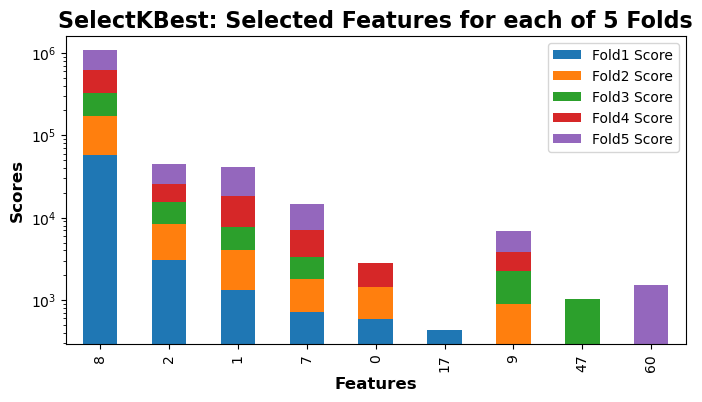

In [795]:
ax = skbSix_T.plot.bar(stacked=True, figsize=(8,4));
plt.ylabel('Scores', fontweight="bold", size = 12);
plt.xlabel('Features', fontweight="bold", size = 12);
plt.title('SelectKBest: Selected Features for each of 5 Folds', fontweight="bold", size = 16);
plt.yscale('log')
plt.show();

In [796]:
ax = skbSix_fullname_T.plot.bar(stacked=True, figsize=(8,5))
plt.ylabel('Scores', fontweight="bold", size = 12);
plt.xlabel('Features', fontweight="bold", size = 12);
plt.title('SelectKBest: Selected Features for each of 5 Folds (with Names)', fontweight="bold", size = 16);
plt.yscale('log')
plt.show();

In [801]:
#Overall Top 6 Features according to SelectKBest using Chi Squared
skbTopSix = skbSix.transpose()
skbTopSix = skbSixMean.iloc[5].nlargest(6).to_frame().T
skbTopSix_fullname = skbSixMean_fullname.iloc[5].nlargest(6).to_frame().T

skbSix_fullname = skbSixMean_fullname.iloc[5].nlargest(6).to_frame().T
print("\033[1m The top 6 features identified across 5 Folds using Chi Squared and SelectKBest are: \033[0m", list(skbTopSix.columns),
      "\n\n\033[1m The Original Feature Names for these 6 features are: \033[0m", list(skbTopSix_fullname.columns))


 The top 6 features identified across 5 Folds using Chi Squared and SelectKBest are:  [8, 2, 1, 7, 9, 0] 

 The Original Feature Names for these 6 features are:  ['Species Common Name', 'Protected Heritage Area', 'Field Unit', 'Total Staff Hours', 'Sum of Number of Animals', 'Incident Month']


**Creating a subset of 50 highest scoring features to use with Forward Feature Selector below. If I use Forward Feature Selector with entire dataset, it takes far too long to iterate through and process**

In [43]:
#Subset of Top Fifty features (taken from mean of each feature over all Folds)

skbscores = pd.concat([scores5_df["Score"], scores4_df["Score"], scores3_df["Score"], scores2_df["Score"], scores1_df["Score"]], axis=1)
skbscores = skbscores.set_axis(['Fold1 Score', 'Fold2 Score', 'Fold3 Score', 'Fold4 Score', 'Fold5 Score'], axis=1, inplace=False)
skbscores = skbscores.transpose()
skbscores=skbscores.fillna(0)

skbscoresMean = skbscores
skbscoresMean.loc['mean'] = skbscoresMean.mean()

#Overall Mean of Features according to SelectKBest using Chi Squared
skbTopFiftyMean = skbscoresMean.iloc[5].nlargest(50).to_frame().T
skbTopFiftyMean = skbTopFiftyMean.transpose()



**WRAPPER Filter Selection using Forward Elimination** 

I also compared backward elimination and forward elimination results, and found that forward elimination provided slightly better results so am using that one here.

Had planned to use RFE (Recursive Feature Elimination) with sklearn, but does not seem to be a good option - my understanding is it only works well when the dependent variable has 2 classes? I can't find the answer online anywhere...


In [44]:
X_train5_skbfifty = X_train5_df[skbTopFiftyMean.index]
X_test5_skbfifty = X_test5_df[skbTopFiftyMean.index]
y_train5_df
y_test5_df

X_train4_skbfifty = X_train4_df[skbTopFiftyMean.index]
X_test4_skbfifty = X_test4_df[skbTopFiftyMean.index]
y_train4_df
y_test4_df

X_train3_skbfifty = X_train3_df[skbTopFiftyMean.index]
X_test3_skbfifty = X_test3_df[skbTopFiftyMean.index]
y_train3_df
y_test3_df

X_train2_skbfifty = X_train2_df[skbTopFiftyMean.index]
X_test2_skbfifty = X_test2_df[skbTopFiftyMean.index]
y_train2_df
y_test2_df

X_train1_skbfifty = X_train1_df[skbTopFiftyMean.index]
X_test1_skbfifty = X_test1_df[skbTopFiftyMean.index]
y_train1_df
y_test1_df

y_train5_enc
y_train4_enc
y_train3_enc
y_train2_enc
y_train1_enc

array([4, 4, 4, ..., 4, 7, 4])

In [ ]:
#Using this resource: https://www.google.com/search?q=performing+backwards+elimination+on+multiclass+dependent+variable+in+python&sxsrf=APwXEdfw60U7tN5kXnW2l6dyg0qyXqIaTA:1679936604338&source=lnms&tbm=vid&sa=X&ved=2ahUKEwipvq_Ey_z9AhX1kIkEHb_VDQIQ_AUoAXoECAEQAw&biw=1202&bih=697&dpr=2#fpstate=ive&vld=cid:3ac057a6,vid:nh2IGC_kLWw

In [45]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

In [46]:
import time
import resource

start_time = time.time()



forward_feature_selector5 = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
                                                     k_features=(6),
                                                     forward=True,
                                                     floating=False,
                                                     verbose=2,
                                                      scoring="accuracy").fit(X_train5_skbfifty, y_train5_enc)

forward_feature_selector4 = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
                                                     k_features=(6),
                                                     forward=True,
                                                     floating=False,
                                                     verbose=2,
                                                      scoring="accuracy").fit(X_train4_skbfifty, y_train4_enc)

forward_feature_selector3 = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
                                                     k_features=(6),
                                                     forward=True,
                                                     floating=False,
                                                     verbose=2,
                                                      scoring="accuracy").fit(X_train3_skbfifty, y_train3_enc)

forward_feature_selector2 = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
                                                     k_features=(6),
                                                     forward=True,
                                                     floating=False,
                                                     verbose=2,
                                                      scoring="accuracy").fit(X_train2_skbfifty, y_train2_enc)

forward_feature_selector1 = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
                                                     k_features=(6),
                                                     forward=True,
                                                     floating=False,
                                                     verbose=2,
                                                      scoring="accuracy").fit(X_train1_skbfifty, y_train1_enc)


FFSTime = time.time() - start_time
print("The Forward Feature Selection model took:", FFSTime, "seconds to run")
FFSBytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
FFSGB = FFSBytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Forward Feature Selection used:", FFSGB, "gigabytes (GB) of memory to run")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.5min finished

[2023-04-02 14:10:27] Features: 1/6 -- score: 0.7088913864659916[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:  2.0min finished

[2023-04-02 14:12:29] Features: 2/6 -- score: 0.7248030243637278[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  2.4min finished

[2023-04-02 14:14:51] Features: 3/6 -- score: 0.7301387393777462[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

The Forward Feature Selection model took: 3002.7744550704956 seconds to run
The Forward Feature Selection used: 1.62410496 gigabytes (GB) of memory to run


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   52.3s finished

[2023-04-02 14:59:02] Features: 6/6 -- score: 0.727865796831314

In [47]:
FFSTime

3002.7744550704956

In [48]:
FFSGB

1.62410496

In [49]:
Fold5TopSix_names = forward_feature_selector5.k_feature_names_
Fold5TopSix_score = forward_feature_selector5.k_score_

Fold4TopSix_names = forward_feature_selector4.k_feature_names_
Fold4TopSix_score = forward_feature_selector4.k_score_

Fold3TopSix_names = forward_feature_selector3.k_feature_names_
Fold3TopSix_score = forward_feature_selector3.k_score_

Fold2TopSix_names = forward_feature_selector2.k_feature_names_
Fold2TopSix_score = forward_feature_selector2.k_score_

Fold1TopSix_names = forward_feature_selector1.k_feature_names_
Fold1TopSix_score = forward_feature_selector1.k_score_

In [50]:
df1 = pd.DataFrame(data = [{Fold1TopSix_names[0]: Fold1TopSix_score, Fold1TopSix_names[1]: Fold1TopSix_score, 
                           Fold1TopSix_names[2]: Fold1TopSix_score, Fold1TopSix_names[3]: Fold1TopSix_score, 
                           Fold1TopSix_names[4]: Fold1TopSix_score, Fold1TopSix_names[5]: Fold1TopSix_score}], 
                  index = ["Fold 1"])
df2 = pd.DataFrame(data = [{Fold2TopSix_names[0]: Fold2TopSix_score, Fold2TopSix_names[1]: Fold2TopSix_score, 
                           Fold2TopSix_names[2]: Fold2TopSix_score, Fold2TopSix_names[3]: Fold2TopSix_score, 
                           Fold2TopSix_names[4]: Fold2TopSix_score, Fold2TopSix_names[5]: Fold2TopSix_score}], 
                  index = ["Fold 2"])
df3 = pd.DataFrame(data = [{Fold3TopSix_names[0]: Fold3TopSix_score, Fold3TopSix_names[1]: Fold3TopSix_score, 
                           Fold3TopSix_names[2]: Fold3TopSix_score, Fold3TopSix_names[3]: Fold3TopSix_score, 
                           Fold3TopSix_names[4]: Fold3TopSix_score, Fold3TopSix_names[5]: Fold3TopSix_score}], 
                  index = ["Fold 3"])
df4 = pd.DataFrame(data = [{Fold4TopSix_names[0]: Fold4TopSix_score, Fold4TopSix_names[1]: Fold4TopSix_score, 
                           Fold4TopSix_names[2]: Fold4TopSix_score, Fold4TopSix_names[3]: Fold4TopSix_score, 
                           Fold4TopSix_names[4]: Fold4TopSix_score, Fold4TopSix_names[5]: Fold4TopSix_score}], 
                  index = ["Fold 4"])
df5 = pd.DataFrame(data = [{Fold5TopSix_names[0]: Fold5TopSix_score, Fold5TopSix_names[1]: Fold5TopSix_score, 
                           Fold5TopSix_names[2]: Fold5TopSix_score, Fold5TopSix_names[3]: Fold5TopSix_score, 
                           Fold5TopSix_names[4]: Fold5TopSix_score, Fold5TopSix_names[5]: Fold5TopSix_score}], 
                  index = ["Fold 5"])

In [51]:
FFS_data = df1.merge(df2, how="outer")
FFS_data = FFS_data.merge(df3, how="outer")
FFS_data = FFS_data.merge(df4, how="outer")
FFS_data = FFS_data.merge(df5, how="outer")
FFS_data["Fold"] = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"]
FFS_data = FFS_data.set_index("Fold")
FFS_data_T = FFS_data.transpose()
FFS_data_T = FFS_data_T.fillna(0)
FFS_data_T

Fold    Fold 1    Fold 2    Fold 3    Fold 4    Fold 5
8     0.727866  0.726239  0.738921  0.708459  0.736096
2     0.727866  0.726239  0.000000  0.708459  0.736096
1     0.727866  0.726239  0.738921  0.000000  0.000000
69    0.727866  0.000000  0.738921  0.708459  0.736096
34    0.727866  0.000000  0.000000  0.708459  0.000000
31    0.727866  0.000000  0.000000  0.000000  0.000000
7     0.000000  0.726239  0.738921  0.708459  0.736096
9     0.000000  0.726239  0.738921  0.000000  0.000000
17    0.000000  0.726239  0.000000  0.000000  0.000000
3     0.000000  0.000000  0.738921  0.000000  0.000000
25    0.000000  0.000000  0.000000  0.708459  0.000000
93    0.000000  0.000000  0.000000  0.000000  0.736096
94    0.000000  0.000000  0.000000  0.000000  0.736096

In [52]:
FFS_data_Fold_Mean = FFS_data.transpose()
FFS_data_Fold_Mean.loc['fold_mean'] = FFS_data_Fold_Mean.mean(skipna=True)
#FFS_data_Mean['fold_mean'] = FFS_data_Mean.mean()
FFS_data_Fold_Mean

Fold         Fold 1    Fold 2    Fold 3    Fold 4    Fold 5
8          0.727866  0.726239  0.738921  0.708459  0.736096
2          0.727866  0.726239       NaN  0.708459  0.736096
1          0.727866  0.726239  0.738921       NaN       NaN
69         0.727866       NaN  0.738921  0.708459  0.736096
34         0.727866       NaN       NaN  0.708459       NaN
31         0.727866       NaN       NaN       NaN       NaN
7               NaN  0.726239  0.738921  0.708459  0.736096
9               NaN  0.726239  0.738921       NaN       NaN
17              NaN  0.726239       NaN       NaN       NaN
3               NaN       NaN  0.738921       NaN       NaN
25              NaN       NaN       NaN  0.708459       NaN
93              NaN       NaN       NaN       NaN  0.736096
94              NaN       NaN       NaN       NaN  0.736096
fold_mean  0.727866  0.726239  0.738921  0.708459  0.736096

In [53]:
FFS_data_Feature_Mean = FFS_data
FFS_data_Feature_Mean = FFS_data_Feature_Mean.fillna(0)
FFS_data_Feature_Mean.loc['feature_mean'] = FFS_data_Feature_Mean.mean(skipna=True)
FFS_data_Feature_Mean

8         2         1        69        34        31  \
Fold                                                                       
Fold 1        0.727866  0.727866  0.727866  0.727866  0.727866  0.727866   
Fold 2        0.726239  0.726239  0.726239  0.000000  0.000000  0.000000   
Fold 3        0.738921  0.000000  0.738921  0.738921  0.000000  0.000000   
Fold 4        0.708459  0.708459  0.000000  0.708459  0.708459  0.000000   
Fold 5        0.736096  0.736096  0.000000  0.736096  0.000000  0.000000   
feature_mean  0.727516  0.579732  0.438605  0.582268  0.287265  0.145573   

                     7         9        17         3        25        93  \
Fold                                                                       
Fold 1        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Fold 2        0.726239  0.726239  0.726239  0.000000  0.000000  0.000000   
Fold 3        0.738921  0.738921  0.000000  0.738921  0.000000  0.000000   
Fold 4        0.708459  0.000000  0.000000  0.000000  0.708459  0.000000   
Fold 5        0.736096  0.000000  0.000000  0.000000  0.000000  0.736096   
feature_mean  0.581943  0.293032  0.145248  0.147784  0.141692  0.147219   

                    94  
Fold                    
Fold 1        0.000000  
Fold 2        0.000000  
Fold 3        0.000000  
Fold 4        0.000000  
Fold 5        0.736096  
feature_mean  0.147219

In [58]:
fold_mean = FFS_data_Fold_Mean.loc['fold_mean']
fold_mean = pd.DataFrame(fold_mean)
feature_mean = FFS_data_Feature_Mean.loc['feature_mean']
feature_mean = pd.DataFrame(feature_mean)
feature_mean = feature_mean["feature_mean"].sort_values()

In [59]:
FFS_data_T = FFS_data.transpose()
FFS_data_T

Fold    Fold 1    Fold 2    Fold 3    Fold 4    Fold 5
8     0.727866  0.726239  0.738921  0.708459  0.736096
2     0.727866  0.726239       NaN  0.708459  0.736096
1     0.727866  0.726239  0.738921       NaN       NaN
69    0.727866       NaN  0.738921  0.708459  0.736096
34    0.727866       NaN       NaN  0.708459       NaN
31    0.727866       NaN       NaN       NaN       NaN
7          NaN  0.726239  0.738921  0.708459  0.736096
9          NaN  0.726239  0.738921       NaN       NaN
17         NaN  0.726239       NaN       NaN       NaN
3          NaN       NaN  0.738921       NaN       NaN
25         NaN       NaN       NaN  0.708459       NaN
93         NaN       NaN       NaN       NaN  0.736096
94         NaN       NaN       NaN       NaN  0.736096

In [60]:
FFS_data

8         2         1        69        34        31         7  \
Fold                                                                           
Fold 1  0.727866  0.727866  0.727866  0.727866  0.727866  0.727866       NaN   
Fold 2  0.726239  0.726239  0.726239       NaN       NaN       NaN  0.726239   
Fold 3  0.738921       NaN  0.738921  0.738921       NaN       NaN  0.738921   
Fold 4  0.708459  0.708459       NaN  0.708459  0.708459       NaN  0.708459   
Fold 5  0.736096  0.736096       NaN  0.736096       NaN       NaN  0.736096   

               9        17         3        25        93        94  
Fold                                                                
Fold 1       NaN       NaN       NaN       NaN       NaN       NaN  
Fold 2  0.726239  0.726239       NaN       NaN       NaN       NaN  
Fold 3  0.738921       NaN  0.738921       NaN       NaN       NaN  
Fold 4       NaN       NaN       NaN  0.708459       NaN       NaN  
Fold 5       NaN       NaN       NaN       NaN  0.736096  0.736096

In [797]:
FFS_data_fullname = FFS_data.copy()
FFS_data_fullname = FFS_data_fullname.set_axis(list(train_set5_enc.iloc[:, list(FFS_data.columns)].columns), axis=1, inplace=False)
#skbSixMean_fullname.loc['mean'] = skbSixMean_fullname.mean()
FFS_data_fullname_T = FFS_data_fullname.transpose()
#FFS_data_fullname_T = FFS_data_fullname_T.drop(["feature_mean"], axis=1)
FFS_data_fullname_T


Fold                                       Fold 1    Fold 2    Fold 3  \
Species Common Name                      0.727866  0.726239  0.738921   
Protected Heritage Area                  0.727866  0.726239       NaN   
Field Unit                               0.727866  0.726239  0.738921   
Activity Type_Railway                    0.727866       NaN  0.738921   
Activity Type_Driving                    0.727866       NaN       NaN   
Activity Type_Dog Walking                0.727866       NaN       NaN   
Total Staff Hours                             NaN  0.726239  0.738921   
Sum of Number of Animals                      NaN  0.726239  0.738921   
Activity Type_Camping - Frontcountry          NaN  0.726239       NaN   
Latitude Public                               NaN       NaN  0.738921   
Activity Type_Climbing - Waterfall  Ice       NaN       NaN       NaN   
Activity Type_Townsite Activity               NaN       NaN       NaN   
Activity Type_Tram/Ski Lift/Gondola           NaN       NaN       NaN   

Fold                                       Fold 4    Fold 5  
Species Common Name                      0.708459  0.736096  
Protected Heritage Area                  0.708459  0.736096  
Field Unit                                    NaN       NaN  
Activity Type_Railway                    0.708459  0.736096  
Activity Type_Driving                    0.708459       NaN  
Activity Type_Dog Walking                     NaN       NaN  
Total Staff Hours                        0.708459  0.736096  
Sum of Number of Animals                      NaN       NaN  
Activity Type_Camping - Frontcountry          NaN       NaN  
Latitude Public                               NaN       NaN  
Activity Type_Climbing - Waterfall  Ice  0.708459       NaN  
Activity Type_Townsite Activity               NaN  0.736096  
Activity Type_Tram/Ski Lift/Gondola           NaN  0.736096

In [798]:
ax = FFS_data_T.plot.bar(stacked=True);
plt.ylabel('Score', fontweight="bold", size = 14);
plt.xlabel('Feature Names', fontweight="bold", size = 14);
plt.title('Forward Elimination: Selected Features for each of 5 Folds', fontweight="bold", size = 18);
plt.show();

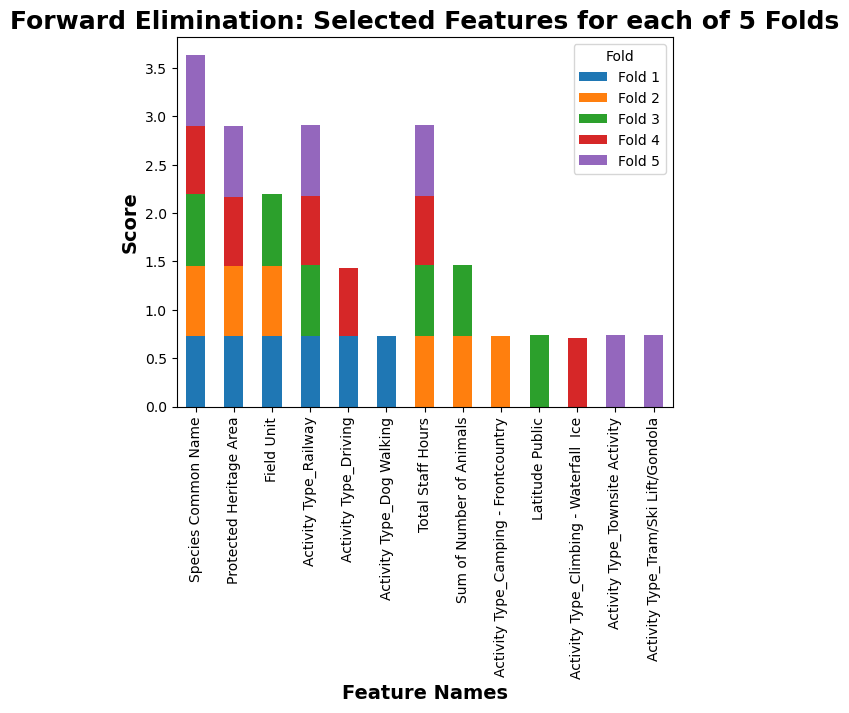

In [816]:
ax = FFS_data_fullname_T.plot.bar(stacked=True);
plt.ylabel('Score', fontweight="bold", size = 14);
plt.xlabel('Feature Names', fontweight="bold", size = 14);
plt.title('Forward Elimination: Selected Features for each of 5 Folds', fontweight="bold", size = 18);
plt.show();

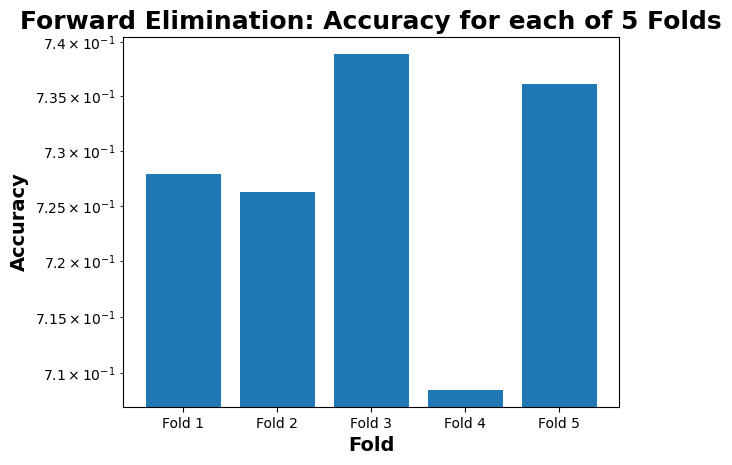

In [68]:
#Comparing mean accuracy for each fold
plt.bar(fold_mean.index, fold_mean["fold_mean"])
plt.ylabel('Accuracy', fontweight="bold", size = 14);
plt.xlabel('Fold', fontweight="bold", size = 14);
plt.title('Forward Elimination: Accuracy for each of 5 Folds', fontweight="bold", size = 18);
plt.yscale('log')
plt.show()

In [69]:
#I DON'T THINK IT MATTERS WHICH FEATURES OCCUR MOST FREQUENTLY ACROSS ALL FOLDS. MY UNDERSTANDING IS THAT 
#THE FORWARD ELIMINATION ACCURACY SCORES WOULD BE DEPENEDENT ON THAT SELECTION OF FEATURES SO IT WOULDN'T 
#MAKE SENSE TO MIX THEM UP...

#Comparing mean accuracy for each fold
#plt.bar(feature_mean.index, feature_mean["feature_mean"])
ax = feature_mean.plot.bar()
plt.ylabel('Accuracy', fontweight="bold", size = 14);
plt.xlabel('Feature', fontweight="bold", size = 14);
plt.title('Forward Elimination: Accuracy by Feature accross 5 Folds', fontweight="bold", size = 18);
plt.yscale('log')
plt.show()

In [817]:
#Overall Top 6 Features according to FFS using Random Forest
FFSTopSix = Fold3TopSix_names
FFSTopSix_fullname = train_set5_enc.iloc[:, list(Fold3TopSix_names)].columns


print("\033[1m The top 6 features identified in Fold 3 (highest accuracy across 5 Folds) using Forward Elimination and RandomForestClassifier are: \033[0m", list(Fold3TopSix_names),
      "\n\n\033[1m The Original Feature Names for these 6 features are: \033[0m", list(FFSTopSix_fullname))


 The top 6 features identified in Fold 3 (highest accuracy across 5 Folds) using Forward Elimination and RandomForestClassifier are:  [8, 1, 7, 9, 69, 3] 

 The Original Feature Names for these 6 features are:  ['Species Common Name', 'Field Unit', 'Total Staff Hours', 'Sum of Number of Animals', 'Activity Type_Railway', 'Latitude Public']


In [71]:
print("\033[1m AS A REMINDER, the top 6 features identified across 5 Folds using Chi Squared and SelectKBest are: \033[0m", list(skbTopSix.columns),
      "\n\n\033[1m The Original Feature Names for these 6 features are: \033[0m", list(skbTopSix_fullname.columns))


 AS A REMINDER, the top 6 features identified across 5 Folds using Chi Squared and SelectKBest are:  [8, 2, 1, 7, 9, 0] 

 The Original Feature Names for these 6 features are:  ['Total Staff Hours', 'Protected Heritage Area', 'Field Unit', 'Total Staff Involved', 'Species Common Name', 'Incident Month']


Supervised feature selection 

Filter feature selection methods use statistical techniques to evaluate the relationship between each input variable and the target variable, and these scores are used as the basis to choose (filter) those input variables that will be used in the model.(https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)

It is common to use correlation type statistical measures between input and output variables as the basis for filter feature selection.

As such, the choice of statistical measures is highly dependent upon the variable data types.

**My data types are nomical categorical data**

The statistical measures used in filter-based feature selection are generally calculated one input variable at a time with the target variable. As such, they are referred to as univariate statistical measures. This may mean that any interaction between input variables is not considered in the filtering process.

**Categorical Input, Categorical Output**
This is a classification predictive modeling problem with categorical input variables.

The most common correlation measure for categorical data is the **chi-squared test.**


The scikit-learn library also provides many different filtering methods once statistics have been calculated for each input variable with the target.
Select the top k variables: SelectKBest


Wrapper feature selection methods create many models with different subsets of input features and select those features that result in the best performing model according to a performance metric. These methods are unconcerned with the variable types, although they can be computationally expensive.(https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/). 

Finally, there are some machine learning algorithms that perform feature selection automatically as part of learning the model. We might refer to these techniques as intrinsic feature selection methods.This includes algorithms such as penalized regression models like Lasso and decision trees, including ensembles of decision trees like random forest.


## Dealing with Imbalanced data

SMOTE Oversampling for Multi-Class Classification

#Code from https://machinelearningmastery.com/multi-class-imbalanced-classification/


In [72]:
#_df sets are also encoded, and then converted to dataframe

X_train5_df = pd.DataFrame(X_train5_enc)
y_train5_df = pd.DataFrame(y_train5_enc)
X_test5_df = pd.DataFrame(X_test5_enc)
y_test5_df = pd.DataFrame(y_test5_enc)

X_train4_df = pd.DataFrame(X_train4_enc)
y_train4_df = pd.DataFrame(y_train4_enc)
X_test4_df = pd.DataFrame(X_test4_enc)
y_test4_df = pd.DataFrame(y_test4_enc)

X_train3_df = pd.DataFrame(X_train3_enc)
y_train3_df = pd.DataFrame(y_train3_enc)
X_test3_df = pd.DataFrame(X_test3_enc)
y_test3_df = pd.DataFrame(y_test3_enc)

X_train2_df = pd.DataFrame(X_train2_enc)
y_train2_df = pd.DataFrame(y_train2_enc)
X_test2_df = pd.DataFrame(X_test2_enc)
y_test2_df = pd.DataFrame(y_test2_enc)

X_train1_df = pd.DataFrame(X_train1_enc)
y_train1_df = pd.DataFrame(y_train1_enc)
X_test1_df = pd.DataFrame(X_test1_enc)
y_test1_df = pd.DataFrame(y_test1_enc)

In [73]:
X_tr5 = X_train5_enc
y_tr5 = y_train5_enc
X_te5 = X_test5_enc
y_te5 = y_test5_enc

X_tr4 = X_train4_enc
y_tr4 = y_train4_enc
X_te4 = X_test4_enc
y_te4 = y_test4_enc

X_tr3 = X_train3_enc
y_tr3 = y_train3_enc
X_te3 = X_test3_enc
y_te3 = y_test3_enc

X_tr2 = X_train2_enc
y_tr2 = y_train2_enc
X_te2 = X_test2_enc
y_te2 = y_test2_enc

X_tr1 = X_train1_enc
y_tr1 = y_train1_enc
X_te1 = X_test1_enc
y_te1 = y_test1_enc

In [74]:
import imblearn

In [75]:
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [76]:
#Fold 5:
# summarize distribution (counting how many of each class) before balancing
counter = Counter(y_tr5)
for k,v in counter.items():
 per = v / len(y_tr5) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=4, n=40109 (63.884%)
Class=7, n=12709 (20.242%)
Class=0, n=1077 (1.715%)
Class=1, n=241 (0.384%)
Class=6, n=768 (1.223%)
Class=3, n=1229 (1.958%)
Class=8, n=3542 (5.642%)
Class=5, n=1855 (2.955%)
Class=2, n=1254 (1.997%)


Class=4, n=40109 (11.111%)
Class=7, n=40109 (11.111%)
Class=0, n=40109 (11.111%)
Class=1, n=40109 (11.111%)
Class=6, n=40109 (11.111%)
Class=3, n=40109 (11.111%)
Class=8, n=40109 (11.111%)
Class=5, n=40109 (11.111%)
Class=2, n=40109 (11.111%)


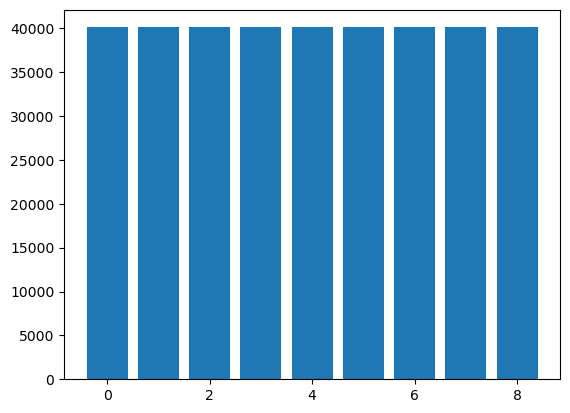

In [77]:
#Fold 5:
# oversampling using SMOTE

oversample = SMOTE()
X_tr5, y_tr5 = oversample.fit_resample(X_tr5, y_tr5)
# summarize distribution
counter = Counter(y_tr5)
for k,v in counter.items():
 per = v / len(y_tr5) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()


In [78]:
np.shape(X_tr5)

(360981, 98)

Class=4, n=24990 (58.585%)
Class=7, n=10720 (25.131%)
Class=0, n=713 (1.672%)
Class=1, n=158 (0.370%)
Class=6, n=491 (1.151%)
Class=3, n=954 (2.236%)
Class=8, n=2247 (5.268%)
Class=5, n=1333 (3.125%)
Class=2, n=1050 (2.462%)


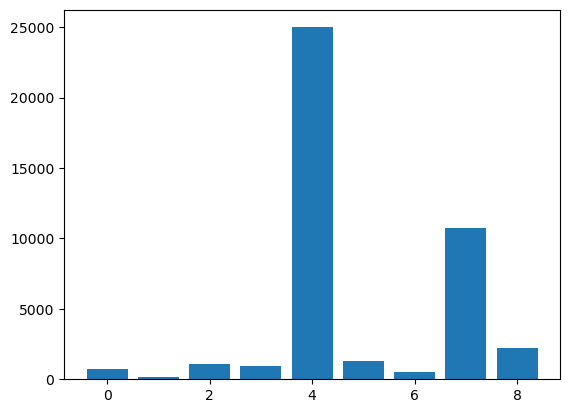

In [80]:
#Fold 4:
# summarize distribution (counting how many of each class) before balancing
counter = Counter(y_tr4)
for k,v in counter.items():
 per = v / len(y_tr4) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [81]:
#Fold 4:
# oversampling using SMOTE

oversample = SMOTE()
X_tr4, y_tr4 = oversample.fit_resample(X_tr4, y_tr4)
# summarize distribution
counter = Counter(y_tr4)
for k,v in counter.items():
 per = v / len(y_tr4) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()


Class=4, n=24990 (11.111%)
Class=7, n=24990 (11.111%)
Class=0, n=24990 (11.111%)
Class=1, n=24990 (11.111%)
Class=6, n=24990 (11.111%)
Class=3, n=24990 (11.111%)
Class=8, n=24990 (11.111%)
Class=5, n=24990 (11.111%)
Class=2, n=24990 (11.111%)


Class=4, n=16697 (56.791%)
Class=7, n=9003 (30.621%)
Class=0, n=432 (1.469%)
Class=1, n=70 (0.238%)
Class=6, n=64 (0.218%)
Class=3, n=813 (2.765%)
Class=8, n=712 (2.422%)
Class=5, n=724 (2.463%)
Class=2, n=886 (3.014%)


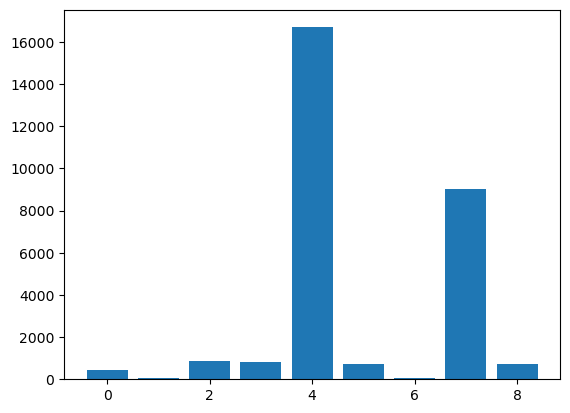

In [82]:
#Fold 3:
# summarize distribution (counting how many of each class) before balancing
counter = Counter(y_tr3)
for k,v in counter.items():
 per = v / len(y_tr3) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=4, n=16697 (11.111%)
Class=7, n=16697 (11.111%)
Class=0, n=16697 (11.111%)
Class=1, n=16697 (11.111%)
Class=6, n=16697 (11.111%)
Class=3, n=16697 (11.111%)
Class=8, n=16697 (11.111%)
Class=5, n=16697 (11.111%)
Class=2, n=16697 (11.111%)


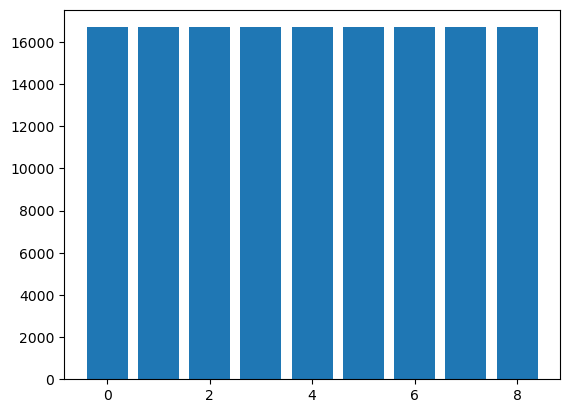

In [83]:
#Fold 3:
# oversampling using SMOTE

oversample = SMOTE()
X_tr3, y_tr3 = oversample.fit_resample(X_tr3, y_tr3)
# summarize distribution
counter = Counter(y_tr3)
for k,v in counter.items():
 per = v / len(y_tr3) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=4, n=10657 (55.318%)
Class=7, n=6166 (32.006%)
Class=0, n=290 (1.505%)
Class=1, n=50 (0.260%)
Class=6, n=60 (0.311%)
Class=3, n=558 (2.896%)
Class=8, n=428 (2.222%)
Class=5, n=494 (2.564%)
Class=2, n=562 (2.917%)


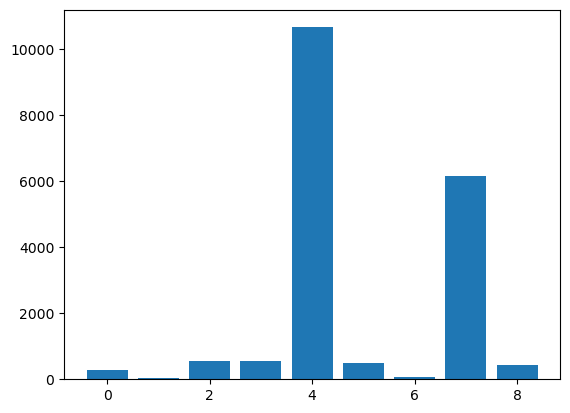

In [84]:
#Fold 2:
# summarize distribution (counting how many of each class) before balancing
counter = Counter(y_tr2)
for k,v in counter.items():
 per = v / len(y_tr2) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [85]:
#Fold 2:
# oversampling using SMOTE

oversample = SMOTE()
X_tr2, y_tr2 = oversample.fit_resample(X_tr2, y_tr2)
# summarize distribution
counter = Counter(y_tr2)
for k,v in counter.items():
 per = v / len(y_tr2) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=4, n=10657 (11.111%)
Class=7, n=10657 (11.111%)
Class=0, n=10657 (11.111%)
Class=1, n=10657 (11.111%)
Class=6, n=10657 (11.111%)
Class=3, n=10657 (11.111%)
Class=8, n=10657 (11.111%)
Class=5, n=10657 (11.111%)
Class=2, n=10657 (11.111%)


In [86]:
#Fold 1:
# summarize distribution (counting how many of each class) before balancing
counter = Counter(y_tr1)
for k,v in counter.items():
 per = v / len(y_tr1) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=4, n=5763 (53.709%)
Class=7, n=3617 (33.709%)
Class=0, n=125 (1.165%)
Class=1, n=41 (0.382%)
Class=6, n=51 (0.475%)
Class=3, n=296 (2.759%)
Class=8, n=238 (2.218%)
Class=5, n=234 (2.181%)
Class=2, n=365 (3.402%)


Class=4, n=5763 (11.111%)
Class=7, n=5763 (11.111%)
Class=0, n=5763 (11.111%)
Class=1, n=5763 (11.111%)
Class=6, n=5763 (11.111%)
Class=3, n=5763 (11.111%)
Class=8, n=5763 (11.111%)
Class=5, n=5763 (11.111%)
Class=2, n=5763 (11.111%)


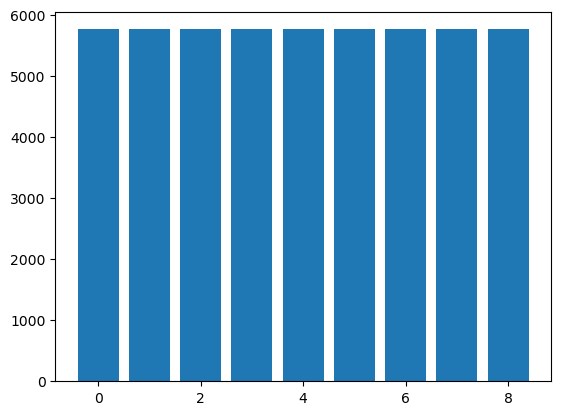

In [87]:
#Fold 1:
# oversampling using SMOTE

oversample = SMOTE()
X_tr1, y_tr1 = oversample.fit_resample(X_tr1, y_tr1)
# summarize distribution
counter = Counter(y_tr1)
for k,v in counter.items():
 per = v / len(y_tr1) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [138]:
X_tr5
y_tr5
X_test5_enc
y_test5_enc

X_tr4
y_tr4
X_test4_enc
y_test4_enc

X_tr3
y_tr3
X_test3_enc
y_test3_enc

X_tr2
y_tr2
X_test2_enc
y_test2_enc

X_tr1
y_tr1
X_test1_enc
y_test1_enc

X_tr5_df = pd.DataFrame(X_tr5)
y_tr5_df = pd.DataFrame(y_tr5)
X_test5_df = pd.DataFrame(X_test5_enc)
y_test5_df = pd.DataFrame(y_test5_enc)

X_tr4_df = pd.DataFrame(X_tr4)
y_tr4_df = pd.DataFrame(y_tr4)
X_test4_df = pd.DataFrame(X_test4_enc)
y_test4_df = pd.DataFrame(y_test4_enc)

X_tr3_df = pd.DataFrame(X_tr3)
y_tr3_df = pd.DataFrame(y_tr3)
X_test3_df = pd.DataFrame(X_test3_enc)
y_test3_df = pd.DataFrame(y_test3_enc)

X_tr2_df = pd.DataFrame(X_tr2)
y_tr2_df = pd.DataFrame(y_tr2)
X_test2_df = pd.DataFrame(X_test2_enc)
y_test2_df = pd.DataFrame(y_test2_enc)

X_tr1_df = pd.DataFrame(X_tr1)
y_tr1_df = pd.DataFrame(y_tr1)
X_test1_df = pd.DataFrame(X_test1_enc)
y_test1_df = pd.DataFrame(y_test1_enc)

X_tr5_df_FF6 = X_tr5_df.iloc[:, list(Fold3TopSix_names)]
X_test5_df_FF6 = X_test5_df.iloc[:, list(Fold3TopSix_names)]
X_tr4_df_FF6 = X_tr4_df.iloc[:, list(Fold3TopSix_names)]
X_test4_df_FF6 = X_test4_df.iloc[:, list(Fold3TopSix_names)]
X_tr3_df_FF6 = X_tr3_df.iloc[:, list(Fold3TopSix_names)]
X_test3_df_FF6 = X_test3_df.iloc[:, list(Fold3TopSix_names)]
X_tr2_df_FF6 = X_tr2_df.iloc[:, list(Fold3TopSix_names)]
X_test2_df_FF6 = X_test2_df.iloc[:, list(Fold3TopSix_names)]
X_tr1_df_FF6 = X_tr1_df.iloc[:, list(Fold3TopSix_names)]
X_test1_df_FF6 = X_test1_df.iloc[:, list(Fold3TopSix_names)]

X_tr5_df_KB6 = X_tr5_df.iloc[:, list(skbTopSix.columns)]
X_test5_df_KB6 = X_test5_df.iloc[:, list(skbTopSix.columns)]
X_tr4_df_KB6 = X_tr4_df.iloc[:, list(skbTopSix.columns)]
X_test4_df_KB6 = X_test4_df.iloc[:, list(skbTopSix.columns)]
X_tr3_df_KB6 = X_tr3_df.iloc[:, list(skbTopSix.columns)]
X_test3_df_KB6 = X_test3_df.iloc[:, list(skbTopSix.columns)]
X_tr2_df_KB6 = X_tr2_df.iloc[:, list(skbTopSix.columns)]
X_test2_df_KB6 = X_test2_df.iloc[:, list(skbTopSix.columns)]
X_tr1_df_KB6 = X_tr1_df.iloc[:, list(skbTopSix.columns)]
X_test1_df_KB6 = X_test1_df.iloc[:, list(skbTopSix.columns)]



0    1     2    3    4    5    6        7      8         9   \
0       0.000000  0.0   1.0  2.0  2.0  1.0  1.0  3.00000   70.0  2.000000   
1       0.000000  0.0   1.0  2.0  2.0  1.0  1.0  3.00000   93.0  1.000000   
2       0.000000  0.0   1.0  2.0  2.0  1.0  1.0  3.00000  295.0  3.000000   
3       0.000000  4.0  12.0  3.0  2.0  1.0  1.0  1.00000  287.0  1.000000   
4       0.000000  4.0  12.0  3.0  2.0  1.0  1.0  3.00000  162.0  0.000000   
...          ...  ...   ...  ...  ...  ...  ...      ...    ...       ...   
360976  9.596807  0.0   1.0  2.0  2.0  1.0  1.0  0.00000   20.0  1.000000   
360977  6.000000  5.0   1.0  2.0  2.0  1.0  4.0  6.00000  118.0  1.000000   
360978  8.000000  0.0   1.0  2.0  2.0  1.0  1.0  0.00000   93.0  1.000000   
360979  6.016977  4.0  12.0  3.0  2.0  1.0  1.0  0.00000   69.0  1.991512   
360980  7.000000  8.0   9.0  2.0  2.0  1.0  1.0  0.78435  118.0  1.000000   

        ...   88   89   90   91   92   93   94   95   96   97  
0       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
360976  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
360977  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
360978  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
360979  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
360980  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[360981 rows x 98 columns]

In [92]:
#X_test1_df_KB6

In [93]:
#X_test1_df_FF6

In [94]:
#X_test1_df

## Modeling

   ## Multinomial Logistic Regression

https://siberian.dev/classification/logistic-regression-maxabsscaler-and-power-transformer/code

In [184]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler, PowerTransformer
import time
import resource

In [575]:
#Fold 5, Top 6 from FFS
#X_tr5_df_FF6
#y_tr5
#X_test5_df_FF6
#y_test5_enc

start_time = time.time()

# define the multinomial logistic regression model
model = make_pipeline(MaxAbsScaler(), PowerTransformer(), LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 500))
model.fit(X_tr5_df_FF6, y_tr5)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_tr5_df_FF6, y_tr5, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
FFS_5_logr_accuracy = model.score(X_test5_df_FF6,y_test5_enc)
print("Accuracy score: ", (FFS_5_logr_accuracy))
FFS_5_logrTime = time.time() - start_time
print("The Logistic Regression Model took:", FFS_5_logrTime, "seconds to run")
FFS_5_logrBytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
FFS_5_logrGB = FFS_5_logrBytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Logistic Regression Model used:", FFS_5_logrGB, "gigabytes (GB) of memory to run")



Accuracy score:  0.21980966460315993
The Logistic Regression Model took: 121.97685098648071 seconds to run
The Logistic Regression Model used: 2.267058176 gigabytes (GB) of memory to run


/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


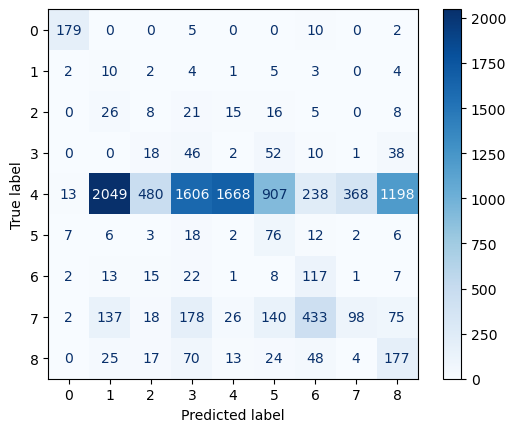

In [576]:
#Confusion Matrix
FFS_5_logr_cm = plot_confusion_matrix(model,X_test5_df_FF6,y_test5_enc,cmap=plt.cm.Blues)
FFS_5_logr_cm

In [577]:
#Using macro average - if i use weighted, the recall ends up being equal to accuracy because 
#weighted doesn't properly account for positive vs negative classes. 
from sklearn.metrics import precision_recall_fscore_support as score
precision,recall,fscore,support=score(y_test5_enc,model.predict(X_test5_df_FF6),average='macro')
FFS_5_logr_precision = precision
FFS_5_logr_recall = recall
FFS_5_logr_Fscore = fscore
FFS_5_logrMCC = matthews_corrcoef(y_test5_enc,model.predict(X_test5_df_FF6))
FFS_5_LogR_metrics = [FFS_5_logr_accuracy, FFS_5_logr_precision, FFS_5_logr_recall, FFS_5_logr_Fscore, FFS_5_logrMCC, FFS_5_logrTime, FFS_5_logrGB]
FFS_5_LogR_metrics

[0.21980966460315993,
 0.2666117453536272,
 0.39436538001353216,
 0.21523931794146645,
 0.1388350403753564,
 121.97685098648071,
 2.267058176]

In [578]:
#Fold 5, Top 6 from KB

#X_tr5_df_KB6
#y_tr5
#X_test5_df_KB6
#y_test5_enc

start_time = time.time()

# define the multinomial logistic regression model
model = make_pipeline(MaxAbsScaler(), PowerTransformer(), LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 500))
model.fit(X_tr5_df_KB6, y_tr5)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_tr5_df_KB6, y_tr5, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
KB_5_logr_accuracy = model.score(X_test5_df_KB6,y_test5_enc)
print("Accuracy score: ", (KB_5_logr_accuracy))
KB_5_logrTime = time.time() - start_time
print("The Logistic Regression Model took:", KB_5_logrTime, "seconds to run")
KB_5_logrBytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
KB_5_logrGB = KB_5_logrBytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Logistic Regression Model used:", KB_5_logrGB, "gigabytes (GB) of memory to run")



Accuracy score:  0.17666081493116512
The Logistic Regression Model took: 69.88084506988525 seconds to run
The Logistic Regression Model used: 2.267058176 gigabytes (GB) of memory to run


In [579]:
#Confusion Matrix
KB_5_logr_cm = plot_confusion_matrix(model,X_test5_df_KB6,y_test5_enc,cmap=plt.cm.Blues)
KB_5_logr_cm


/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


In [580]:
from sklearn.metrics import precision_recall_fscore_support as score
precision,recall,fscore,support=score(y_test5_enc,model.predict(X_test5_df_KB6),average='macro')
KB_5_logr_precision = precision
KB_5_logr_recall = recall
KB_5_logr_Fscore = fscore
KB_5_logrMCC = matthews_corrcoef(y_test5_enc,model.predict(X_test5_df_KB6))
KB_5_LogR_metrics = [KB_5_logr_accuracy, KB_5_logr_precision, KB_5_logr_recall, KB_5_logr_Fscore, KB_5_logrMCC, KB_5_logrTime, KB_5_logrGB]
KB_5_LogR_metrics


[0.17666081493116512,
 0.24523941386414572,
 0.35296836021845884,
 0.18949317912998703,
 0.10499428599795495,
 69.88084506988525,
 2.267058176]

In [581]:
#Comparing metrics for logistic regression model on 
#Forward Feature Selected (FFS) Top 6 Features vs. 
#SelectKBest (KB) Top 6 Features. 
#Trying to run logistic regression on full dataset for comparison 
#took too much time so just comparing these two models. 

index = ["Accuracy", "Precision", "Recall", "F-score", "Matthews Correlation Coefficient","Time (seconds)", "Memory (GBs)"]
FFS_KB_logr_metrics = pd.DataFrame(FFS_5_LogR_metrics, index=index, columns=["FFS Fold5 LogR Metrics"])
FFS_KB_logr_metrics["KB Fold5 LogR Metrics"] = KB_5_LogR_metrics
FFS_KB_logr_metrics

#FFS Top 6 Features provides a better performing model than the 
#alternative (KB) features. 
#Will use that Top 6 FFS features as logr model to compare with DC and RF Models.
FFS_KB_logr_metrics

FFS Fold5 LogR Metrics  \
Accuracy                                        0.219810   
Precision                                       0.266612   
Recall                                          0.394365   
F-score                                         0.215239   
Matthews Correlation Coefficient                0.138835   
Time (seconds)                                121.976851   
Memory (GBs)                                    2.267058   

                                  KB Fold5 LogR Metrics  
Accuracy                                       0.176661  
Precision                                      0.245239  
Recall                                         0.352968  
F-score                                        0.189493  
Matthews Correlation Coefficient               0.104994  
Time (seconds)                                69.880845  
Memory (GBs)                                   2.267058

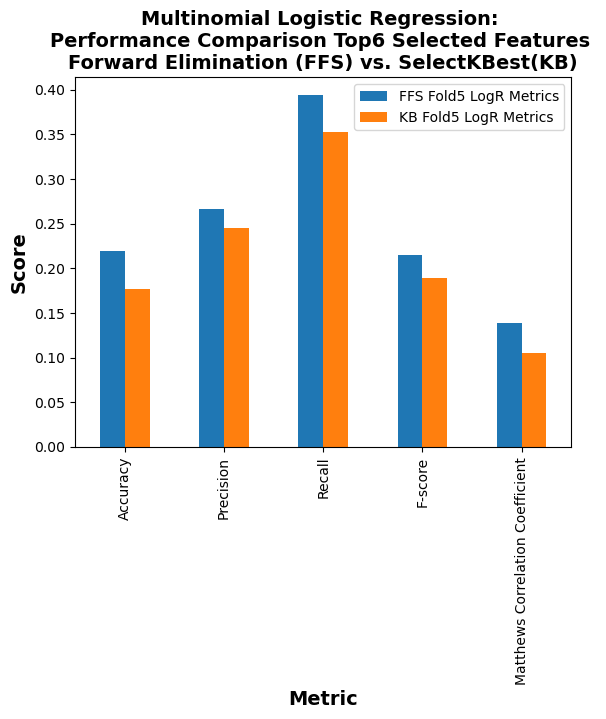

In [789]:
ax = FFS_KB_logr_metrics.iloc[0:5].plot.bar(stacked=False);
plt.ylabel('Score', fontweight="bold", size = 14);
plt.xlabel('Metric', fontweight="bold", size = 14);
plt.title('Multinomial Logistic Regression: \nPerformance Comparison Top6 Selected Features \nForward Elimination (FFS) vs. SelectKBest(KB)', fontweight="bold", size = 14);
#plt.yscale("log")
plt.show();


In [583]:
#Fold 4, Top 6 from FFS

#X_tr4_df_FF6
#y_tr4
#X_test4_df_FF6
#y_test4_enc

start_time = time.time()

# define the multinomial logistic regression model
model = make_pipeline(MaxAbsScaler(), PowerTransformer(), LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 500))
model.fit(X_tr4_df_FF6, y_tr4)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_tr4_df_FF6, y_tr4, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
FFS_4_logr_accuracy = model.score(X_test4_df_FF6,y_test4_enc)
print("Accuracy score: ", (FFS_4_logr_accuracy))

FFS_4_logrTime = time.time() - start_time
print("The Logistic Regression Model took:", FFS_4_logrTime, "seconds to run")
FFS_4_logrBytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
FFS_4_logrGB = FFS_4_logrBytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Logistic Regression Model used:", FFS_4_logrGB, "gigabytes (GB) of memory to run")



Accuracy score:  0.16789982925441094
The Logistic Regression Model took: 64.70294189453125 seconds to run
The Logistic Regression Model used: 2.267058176 gigabytes (GB) of memory to run


/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


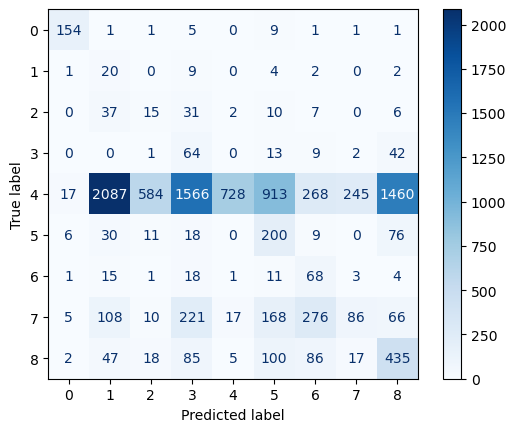

In [584]:
#Confusion Matrix
FFS_4_logr_cm = plot_confusion_matrix(model,X_test4_df_FF6,y_test4_enc,cmap=plt.cm.Blues)
FFS_4_logr_cm


In [586]:
from sklearn.metrics import precision_recall_fscore_support as score
precision,recall,fscore,support=score(y_test4_enc,model.predict(X_test4_df_FF6),average='macro')
FFS_4_logr_precision = precision
FFS_4_logr_recall = recall
FFS_4_logr_Fscore = fscore
FFS_4_logrMCC = matthews_corrcoef(y_test4_enc,model.predict(X_test4_df_FF6))
FFS_4_LogR_metrics = [FFS_4_logr_accuracy, FFS_4_logr_precision, FFS_4_logr_recall, FFS_4_logr_Fscore, FFS_4_logrMCC, FFS_4_logrTime, FFS_4_logrGB]
FFS_4_LogR_metrics


[0.16789982925441094,
 0.28255658322665383,
 0.43358822091539967,
 0.2179061781715713,
 0.14543495760215996,
 64.70294189453125,
 2.267058176]

In [597]:
#Fold 3, Top 6 from FFS
#X_tr3_df_FF6
#y_tr3
#X_test3_df_FF6
#y_test3_enc

start_time = time.time()

# define the multinomial logistic regression model
model = make_pipeline(MaxAbsScaler(), PowerTransformer(), LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 500))
model.fit(X_tr3_df_FF6, y_tr3)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_tr3_df_FF6, y_tr3, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
FFS_3_logr_accuracy = model.score(X_test3_df_FF6,y_test3_enc)
print("Accuracy score: ", (FFS_3_logr_accuracy))

FFS_3_logrTime = time.time() - start_time
print("The Logistic Regression Model took:", FFS_3_logrTime, "seconds to run")
FFS_3_logrBytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
FFS_3_logrGB = FFS_3_logrBytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Logistic Regression Model used:", FFS_3_logrGB, "gigabytes (GB) of memory to run")



Accuracy score:  0.11299074369613789
The Logistic Regression Model took: 54.88567280769348 seconds to run
The Logistic Regression Model used: 2.267058176 gigabytes (GB) of memory to run


/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


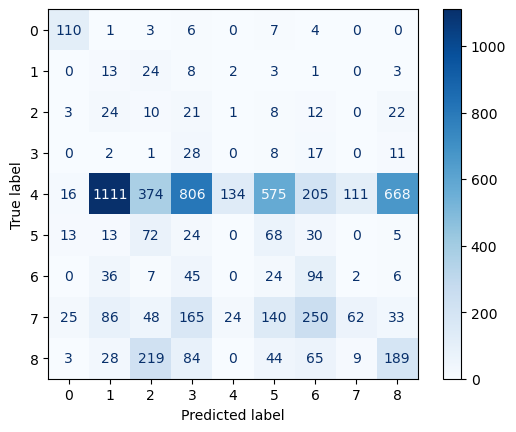

In [598]:
#Confusion Matrix
FFS_3_logr_cm = plot_confusion_matrix(model,X_test3_df_FF6,y_test3_enc,cmap=plt.cm.Blues)
FFS_3_logr_cm


In [599]:
from sklearn.metrics import precision_recall_fscore_support as score
precision,recall,fscore,support=score(y_test3_enc,model.predict(X_test3_df_FF6),average='macro')
FFS_3_logr_precision = precision
FFS_3_logr_recall = recall
FFS_3_logr_Fscore = fscore
FFS_3_logrMCC = matthews_corrcoef(y_test3_enc,model.predict(X_test3_df_FF6))
FFS_3_LogR_metrics = [FFS_3_logr_accuracy, FFS_3_logr_precision, FFS_3_logr_recall, FFS_3_logr_Fscore, FFS_3_logrMCC, FFS_3_logrTime, FFS_3_logrGB]
FFS_3_LogR_metrics


[0.11299074369613789,
 0.2534306813392074,
 0.3046235411813256,
 0.17532174554246235,
 0.09026347493658947,
 54.88567280769348,
 2.267058176]

In [600]:
#Fold 2, Top 6 from FFS
#X_tr2_df_FF6
#y_tr2
#X_test2_df_FF6
#y_test2_enc

start_time = time.time()

# define the multinomial logistic regression model
model = make_pipeline(MaxAbsScaler(), PowerTransformer(), LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 500))
model.fit(X_tr2_df_FF6, y_tr2)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_tr2_df_FF6, y_tr2, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
FFS_2_logr_accuracy = model.score(X_test2_df_FF6,y_test2_enc)
print("Accuracy score: ", (FFS_2_logr_accuracy))

FFS_2_logrTime = time.time() - start_time
print("The Logistic Regression Model took:", FFS_2_logrTime, "seconds to run")
FFS_2_logrBytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
FFS_2_logrGB = FFS_2_logrBytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Logistic Regression Model used:", FFS_2_logrGB, "gigabytes (GB) of memory to run")



Accuracy score:  0.1049097775912715
The Logistic Regression Model took: 28.427585124969482 seconds to run
The Logistic Regression Model used: 2.267058176 gigabytes (GB) of memory to run


/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


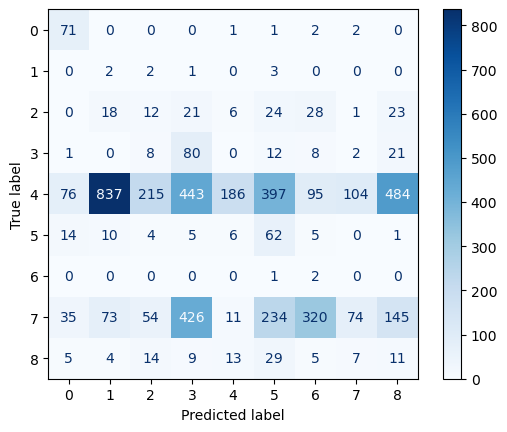

In [601]:
#Confusion Matrix
FFS_2_logr_cm = plot_confusion_matrix(model,X_test2_df_FF6,y_test2_enc,cmap=plt.cm.Blues)
FFS_2_logr_cm


In [602]:
from sklearn.metrics import precision_recall_fscore_support as score
precision,recall,fscore,support=score(y_test2_enc,model.predict(X_test2_df_FF6),average='macro')
FFS_2_logr_precision = precision
FFS_2_logr_recall = recall
FFS_2_logr_Fscore = fscore
FFS_2_logrMCC = matthews_corrcoef(y_test2_enc,model.predict(X_test2_df_FF6))
FFS_2_LogR_metrics = [FFS_2_logr_accuracy, FFS_2_logr_precision, FFS_2_logr_recall, FFS_2_logr_Fscore, FFS_2_logrMCC, FFS_2_logrTime, FFS_2_logrGB]
FFS_2_LogR_metrics


[0.1049097775912715,
 0.19986989784769832,
 0.3719300162857021,
 0.12291437826417945,
 0.07301344042592879,
 28.427585124969482,
 2.267058176]

In [603]:
#Fold 1, Top 6 from FFS
#X_tr1_df_FF6
#y_tr1
#X_test1_df_FF6
#y_test1_enc

start_time = time.time()

# define the multinomial logistic regression model
model = make_pipeline(MaxAbsScaler(), PowerTransformer(), LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 500))
model.fit(X_tr1_df_FF6, y_tr1)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_tr1_df_FF6, y_tr1, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
FFS_1_logr_accuracy = model.score(X_test1_df_FF6,y_test1_enc)
print("Accuracy score: ", (FFS_1_logr_accuracy))

FFS_1_logrTime = time.time() - start_time
print("The Logistic Regression Model took:", FFS_1_logrTime, "seconds to run")
FFS_1_logrBytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
FFS_1_logrGB = FFS_1_logrBytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Logistic Regression Model used:", FFS_1_logrGB, "gigabytes (GB) of memory to run")



Accuracy score:  0.09791889007470651
The Logistic Regression Model took: 23.990544080734253 seconds to run
The Logistic Regression Model used: 2.267058176 gigabytes (GB) of memory to run


/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


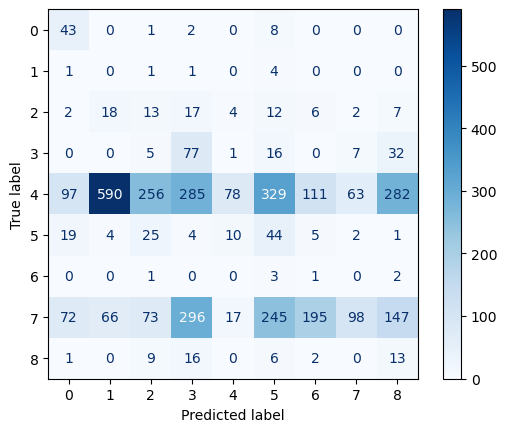

In [604]:
#Confusion Matrix
FFS_1_logr_cm = plot_confusion_matrix(model,X_test1_df_FF6,y_test1_enc,cmap=plt.cm.Blues)
FFS_1_logr_cm


In [605]:
from sklearn.metrics import precision_recall_fscore_support as score
precision,recall,fscore,support=score(y_test1_enc,model.predict(X_test1_df_FF6),average='macro')
FFS_1_logr_precision = precision
FFS_1_logr_recall = recall
FFS_1_logr_Fscore = fscore
FFS_1_logrMCC = matthews_corrcoef(y_test1_enc,model.predict(X_test1_df_FF6))
FFS_1_LogR_metrics = [FFS_1_logr_accuracy, FFS_1_logr_precision, FFS_1_logr_recall, FFS_1_logr_Fscore, FFS_1_logrMCC, FFS_1_logrTime, FFS_1_logrGB]
FFS_1_LogR_metrics


[0.09791889007470651,
 0.18910643865474444,
 0.27094893221741023,
 0.10202909520584053,
 0.06963953586636848,
 23.990544080734253,
 2.267058176]

In [606]:
#Comparing metrics for logistic regression model on each of the 5 folds 
#using Forward Feature Selected (FFS) Top 6 Features.   

index = ["Accuracy", "Precision", "Recall", "F-score", "Matthews CC","Time (seconds)", "Memory (GBs)"]
FFS_logr_metrics = pd.DataFrame(FFS_5_LogR_metrics, index=index, columns=["Fold5"])
FFS_logr_metrics["Fold4"] = FFS_4_LogR_metrics
FFS_logr_metrics["Fold3"] = FFS_3_LogR_metrics
FFS_logr_metrics["Fold2"] = FFS_2_LogR_metrics
FFS_logr_metrics["Fold1"] = FFS_1_LogR_metrics
FFS_logr_metrics

FFS_logr_metrics


Fold5      Fold4      Fold3      Fold2      Fold1
Accuracy          0.219810   0.167900   0.112991   0.104910   0.097919
Precision         0.266612   0.282557   0.253431   0.199870   0.189106
Recall            0.394365   0.433588   0.304624   0.371930   0.270949
F-score           0.215239   0.217906   0.175322   0.122914   0.102029
Matthews CC       0.138835   0.145435   0.090263   0.073013   0.069640
Time (seconds)  121.976851  64.702942  54.885673  28.427585  23.990544
Memory (GBs)      2.267058   2.267058   2.267058   2.267058   2.267058

In [607]:
FFS_logr_metrics_T = FFS_logr_metrics.transpose()

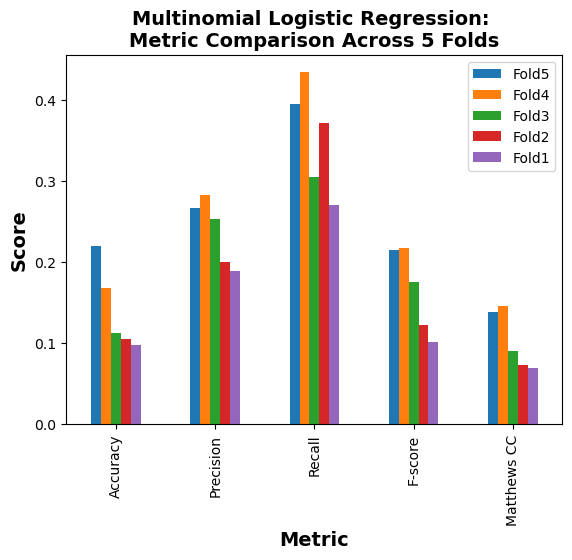

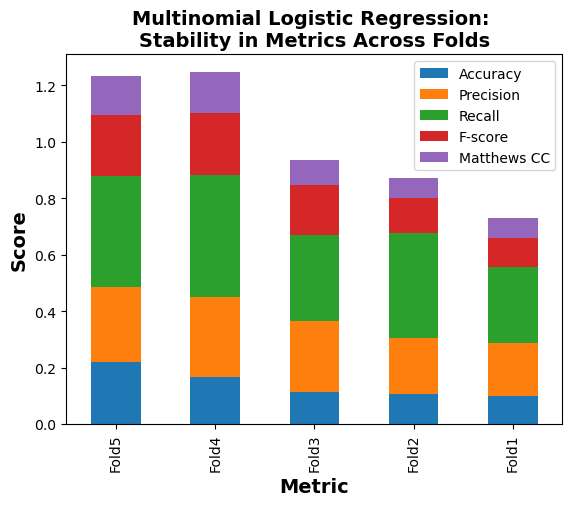

In [608]:
ax = FFS_logr_metrics.iloc[0:5].plot.bar(stacked=False);
plt.ylabel('Score', fontweight="bold", size = 14);
plt.xlabel('Metric', fontweight="bold", size = 14);
plt.title('Multinomial Logistic Regression: \nMetric Comparison Across 5 Folds', fontweight="bold", size = 14);
plt.show();

ax = FFS_logr_metrics_T.iloc[:,0:5].plot.bar(stacked=True);
plt.ylabel('Score', fontweight="bold", size = 14);
plt.xlabel('Metric', fontweight="bold", size = 14);
plt.title('Multinomial Logistic Regression: \nStability in Metrics Across Folds', fontweight="bold", size = 14);
plt.show();


## Decision Trees

In [232]:
#https://www.datacamp.com/tutorial/decision-tree-classification-python

import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation


In [804]:
#Fold5 Decision Tree Classifier - FFS Top 6

start_time = time.time()

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_tr5_df_FF6,y_tr5_df)

#Predict the response for test dataset
y_pred5 = clf.predict(X_test5_df_FF6)

# Model Accuracy, how often is the classifier correct?
FFS_dc5_accuracy = accuracy_score(y_test5_df,y_pred5)
print("Accuracy score: ", (FFS_dc5_accuracy))
FFS_dc5_Time = time.time() - start_time
print("This Decision Tree Model took:", FFS_dc5_Time, "seconds to run")
FFS_dc5_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
FFS_dc5_GB = FFS_dc5_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("This Decision Tree Model used:", FFS_dc5_GB, "gigabytes (GB) of memory to run")


Accuracy score:  0.5961378545689735
This Decision Tree Model took: 0.46326613426208496 seconds to run
This Decision Tree Model used: 2.516086784 gigabytes (GB) of memory to run


/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


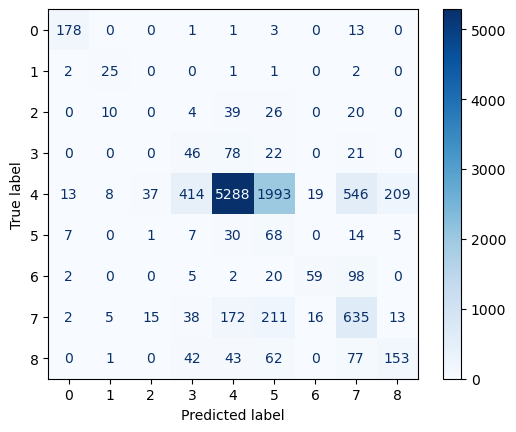

In [805]:
dc_5_cm = plot_confusion_matrix(clf,X_test5_df_FF6,y_test5_enc,cmap=plt.cm.Blues)


In [806]:
precision,recall,fscore,support=score(y_test5_df,y_pred5, average="macro")
FFS_dc5_precision = precision
FFS_dc5_recall = recall
FFS_dc5_Fscore = fscore
FFS_dc5_MCC = matthews_corrcoef(y_test5_df,y_pred5)
FFS_dc5_metrics = [FFS_dc5_accuracy, FFS_dc5_precision, FFS_dc5_recall, FFS_dc5_Fscore, FFS_dc5_MCC, FFS_dc5_Time, FFS_dc5_GB]
FFS_dc5_metrics

[0.5961378545689735,
 0.4338289799904384,
 0.4912168744227954,
 0.41866091145310225,
 0.33815134709459105,
 0.46326613426208496,
 2.516086784]

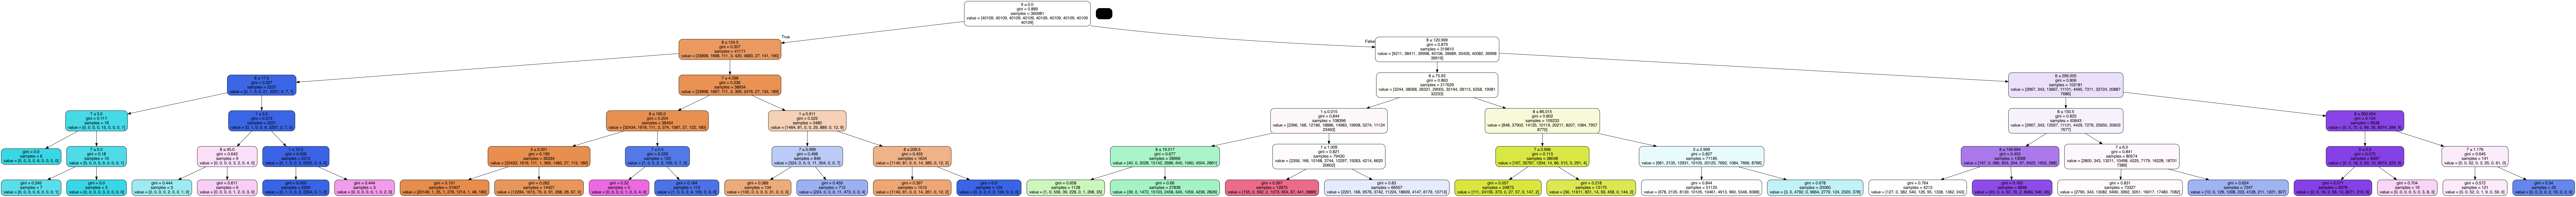

In [807]:
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_tr5_df_FF6.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('HWC_decisiontree_withfs.png')
Image(graph.create_png())

In [808]:
#Fold5 Decision Tree Classifier - All Features

start_time = time.time()

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_tr5_df,y_tr5_df)

#Predict the response for test dataset
y_pred5all = clf.predict(X_test5_df)

# Model Accuracy, how often is the classifier correct?
dc5_accuracy = accuracy_score(y_test5_df,y_pred5all)
print("Accuracy score: ", (dc5_accuracy))
dc5_Time = time.time() - start_time
print("This Decision Tree Model took:", dc5_Time, "seconds to run")
dc5_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
dc5_GB = dc5_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("This Decision Tree Model used:", dc5_GB, "gigabytes (GB) of memory to run")


Accuracy score:  0.5704518155779359
This Decision Tree Model took: 3.3158888816833496 seconds to run
This Decision Tree Model used: 2.516086784 gigabytes (GB) of memory to run


In [809]:
precision,recall,fscore,support=score(y_test5_df,y_pred5all, average='macro')
dc5_precision = precision
dc5_recall = recall
dc5_Fscore = fscore
dc5_MCC = matthews_corrcoef(y_test5_df,y_pred5all)
dc5_metrics = [dc5_accuracy, dc5_precision, dc5_recall, dc5_Fscore, dc5_MCC, dc5_Time, dc5_GB]
dc5_metrics

[0.5704518155779359,
 0.36634640453738754,
 0.4924639935559065,
 0.3599534920620222,
 0.29004790745380915,
 3.3158888816833496,
 2.516086784]

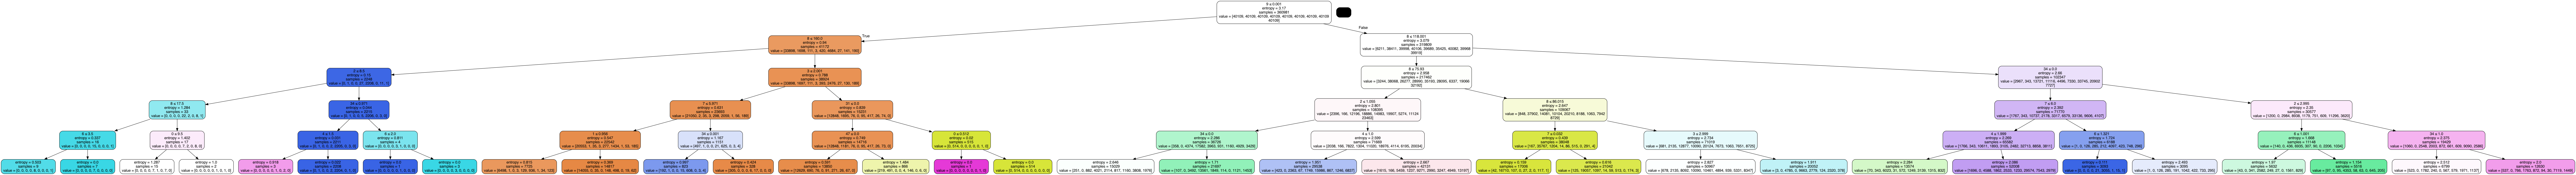

In [301]:
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_tr5_df.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('HWC_decisiontree_withfs.png')
Image(graph.create_png())

In [810]:
#Fold5 Decision Tree Classifier - KB Top 6 features

start_time = time.time()

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_tr5_df_KB6,y_tr5_df)

#Predict the response for test dataset
y_pred5kb = clf.predict(X_test5_df_KB6)

# Model Accuracy, how often is the classifier correct?
kb_dc5_accuracy = accuracy_score(y_test5_df,y_pred5kb)
print("Accuracy score: ", (kb_dc5_accuracy))
kb_dc5_Time = time.time() - start_time
print("This Decision Tree Model took:", kb_dc5_Time, "seconds to run")
kb_dc5_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
kb_dc5_GB = kb_dc5_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("This Decision Tree Model used:", kb_dc5_GB, "gigabytes (GB) of memory to run")


Accuracy score:  0.5216668206597062
This Decision Tree Model took: 0.6095490455627441 seconds to run
This Decision Tree Model used: 2.516086784 gigabytes (GB) of memory to run


In [811]:
precision,recall,fscore,support=score(y_test5_df,y_pred5kb, average='macro')
kb_dc5_precision = precision
kb_dc5_recall = recall
kb_dc5_Fscore = fscore
kb_dc5_MCC = matthews_corrcoef(y_test5_df,y_pred5kb)
kb_dc5_metrics = [kb_dc5_accuracy, kb_dc5_precision, kb_dc5_recall, kb_dc5_Fscore, kb_dc5_MCC, kb_dc5_Time, kb_dc5_GB]


In [812]:
#Comparing between using Forward Feature Selection (FFS) Top 6 vs. intrinsic features selection in
#decision tree. Results are very close, but FFS is sightly higher. Will use FFS features.

index = ["Accuracy", "Precision", "Recall", "F-score", "Matthews CC","Time (seconds)", "Memory (GBs)"]
dc_metrics_comp = pd.DataFrame(FFS_dc5_metrics, index=index, columns=["Fold5 FFS"])
dc_metrics_comp["Fold5 all"] = dc5_metrics
dc_metrics_comp["Fold5 KB"] = kb_dc5_metrics

dc_metrics_comp


Fold5 FFS  Fold5 all  Fold5 KB
Accuracy         0.596138   0.570452  0.521667
Precision        0.433829   0.366346  0.436205
Recall           0.491217   0.492464  0.504907
F-score          0.418661   0.359953  0.408686
Matthews CC      0.338151   0.290048  0.324320
Time (seconds)   0.463266   3.315889  0.609549
Memory (GBs)     2.516087   2.516087  2.516087

In [813]:
dc_metrics_comp_T = dc_metrics_comp.transpose()

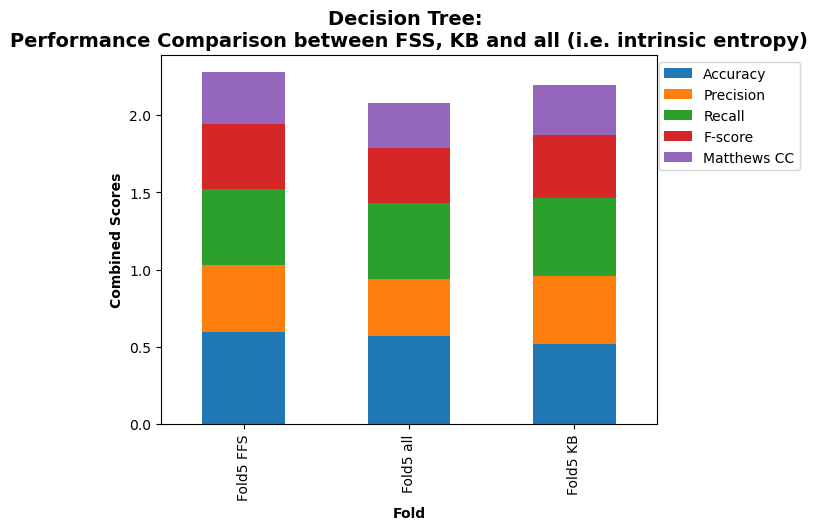

In [814]:
ax = dc_metrics_comp.iloc[0:5].plot.bar(stacked=False);
plt.ylabel('Score', fontweight="bold", size = 10);
plt.xlabel('Metric', fontweight="bold", size = 10);
plt.title('Decision Tree: \nPerformance Comparison between FSS, KB, and all (intrinsic entropy)', fontweight="bold", size = 14);
plt.show();

ax = dc_metrics_comp_T.iloc[:,0:5].plot.bar(stacked=True);
plt.ylabel('Combined Scores', fontweight="bold", size = 10);
plt.xlabel('Fold', fontweight="bold", size = 10);
plt.title('Decision Tree: \nPerformance Comparison between FSS, KB and all (i.e. intrinsic entropy)', fontweight="bold", size = 14);
plt.legend(bbox_to_anchor=(0.99, 1))
plt.show();

In [623]:
#Using the FFS Top 6 features and using all features with the intrinsic feature selector
#with decision tree results in very similar results, with FFS being slightly better. 
#Will use FFS for the decision tree models. 

In [624]:
#Fold4 Decision Tree Classifier - FFS Top 6

start_time = time.time()

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_tr4_df_FF6,y_tr4_df)

#Predict the response for test dataset
y_pred4 = clf.predict(X_test4_df_FF6)

# Model Accuracy, how often is the classifier correct?
FFS_dc4_accuracy = accuracy_score(y_test4_df,y_pred4)
print("Accuracy score: ", (FFS_dc4_accuracy))
FFS_dc4_Time = time.time() - start_time
print("This Decision Tree Model took:", FFS_dc4_Time, "seconds to run")
FFS_dc4_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
FFS_dc4_GB = FFS_dc4_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("This Decision Tree  used:", FFS_dc4_GB, "gigabytes (GB) of memory to run")


Accuracy score:  0.2929235439195599
This Decision Tree Model took: 0.4762239456176758 seconds to run
This Decision Tree  used: 2.267058176 gigabytes (GB) of memory to run


In [625]:
precision,recall,fscore,support=score(y_test4_df,y_pred4, average="macro")
FFS_dc4_precision = precision
FFS_dc4_recall = recall
FFS_dc4_Fscore = fscore
FFS_dc4_MCC = matthews_corrcoef(y_test4_df,y_pred4)
FFS_dc4_metrics = [FFS_dc4_accuracy, FFS_dc4_precision, FFS_dc4_recall, FFS_dc4_Fscore, FFS_dc4_MCC, FFS_dc4_Time, FFS_dc4_GB]


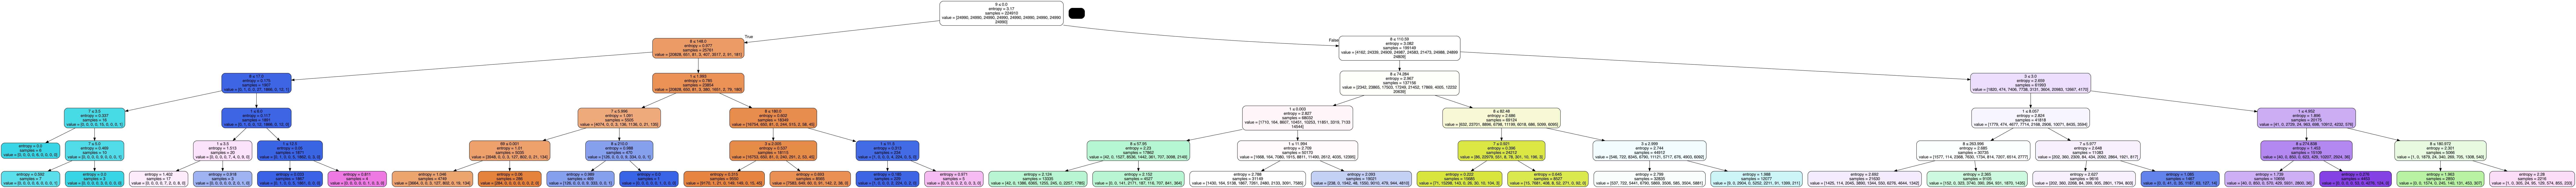

In [333]:
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_tr4_df_FF6.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('HWC_decisiontree_withfs.png')
Image(graph.create_png())

In [626]:
#Fold3 Decision Tree Classifier - FFS Top 6

start_time = time.time()

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_tr3_df_FF6,y_tr3_df)

#Predict the response for test dataset
y_pred3 = clf.predict(X_test3_df_FF6)

# Model Accuracy, how often is the classifier correct?
FFS_dc3_accuracy = accuracy_score(y_test3_df,y_pred3)
print("Accuracy score: ", (FFS_dc3_accuracy))
FFS_dc3_Time = time.time() - start_time
print("This Decision Tree Model took:", FFS_dc3_Time, "seconds to run")
FFS_dc3_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
FFS_dc3_GB = FFS_dc3_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("This Decision Tree  used:", FFS_dc3_GB, "gigabytes (GB) of memory to run")


Accuracy score:  0.41270347909352056
This Decision Tree Model took: 0.32930994033813477 seconds to run
This Decision Tree  used: 2.267058176 gigabytes (GB) of memory to run


In [627]:
precision,recall,fscore,support=score(y_test3_df,y_pred3, average="macro")
FFS_dc3_precision = precision
FFS_dc3_recall = recall
FFS_dc3_Fscore = fscore
FFS_dc3_MCC = matthews_corrcoef(y_test3_df,y_pred3)
FFS_dc3_metrics = [FFS_dc3_accuracy, FFS_dc3_precision, FFS_dc3_recall, FFS_dc3_Fscore, FFS_dc3_MCC, FFS_dc3_Time, FFS_dc3_GB]


/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [337]:
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_tr3_df_FF6.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('HWC_decisiontree_withfs.png')
Image(graph.create_png())

In [628]:
#Fold2 Decision Tree Classifier - FFS Top 6

start_time = time.time()

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_tr2_df_FF6,y_tr2_df)

#Predict the response for test dataset
y_pred2 = clf.predict(X_test2_df_FF6)

# Model Accuracy, how often is the classifier correct?
FFS_dc2_accuracy = accuracy_score(y_test2_df,y_pred2)
print("Accuracy score: ", (FFS_dc2_accuracy))
FFS_dc2_Time = time.time() - start_time
print("This Decision Tree Model took:", FFS_dc2_Time, "seconds to run")
FFS_dc2_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
FFS_dc2_GB = FFS_dc2_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("This Decision Tree  used:", FFS_dc2_GB, "gigabytes (GB) of memory to run")


Accuracy score:  0.35774234158623586
This Decision Tree Model took: 0.21859097480773926 seconds to run
This Decision Tree  used: 2.267058176 gigabytes (GB) of memory to run


In [629]:
precision,recall,fscore,support=score(y_test2_df,y_pred2, average="macro")
FFS_dc2_precision = precision
FFS_dc2_recall = recall
FFS_dc2_Fscore = fscore
FFS_dc2_MCC = matthews_corrcoef(y_test2_df,y_pred2)
FFS_dc2_metrics = [FFS_dc2_accuracy, FFS_dc2_precision, FFS_dc2_recall, FFS_dc2_Fscore, FFS_dc2_MCC, FFS_dc2_Time, FFS_dc2_GB]


/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [630]:
#Fold1 Decision Tree Classifier - FFS Top 6

start_time = time.time()

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_tr1_df_FF6,y_tr1_df)

#Predict the response for test dataset
y_pred1 = clf.predict(X_test1_df_FF6)

# Model Accuracy, how often is the classifier correct?
FFS_dc1_accuracy = accuracy_score(y_test1_df,y_pred1)
print("Accuracy score: ", (FFS_dc1_accuracy))
FFS_dc1_Time = time.time() - start_time
print("This Decision Tree Model took:", FFS_dc1_Time, "seconds to run")
FFS_dc1_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
FFS_dc1_GB = FFS_dc1_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("This Decision Tree  used:", FFS_dc1_GB, "gigabytes (GB) of memory to run")


Accuracy score:  0.2833511205976521
This Decision Tree Model took: 0.12442302703857422 seconds to run
This Decision Tree  used: 2.267058176 gigabytes (GB) of memory to run


In [631]:
precision,recall,fscore,support=score(y_test1_df,y_pred1, average="macro")
FFS_dc1_precision = precision
FFS_dc1_recall = recall
FFS_dc1_Fscore = fscore
FFS_dc1_MCC = matthews_corrcoef(y_test1_df,y_pred1)
FFS_dc1_metrics = [FFS_dc1_accuracy, FFS_dc1_precision, FFS_dc1_recall, FFS_dc1_Fscore, FFS_dc1_MCC, FFS_dc1_Time, FFS_dc1_GB]


In [632]:
#Comparing between using Forward Feature Selection (FFS) Top 6 vs. intrinsic features selection in
#decision tree. Results are very close, but FFS is sightly higher. Will use FFS features.

index = ["Accuracy", "Precision", "Recall", "F-score", "Matthews CC","Time (seconds)", "Memory (GBs)"]
dc_FFS_metrics = pd.DataFrame(FFS_dc5_metrics, index=index, columns=["Fold5"])
dc_FFS_metrics["Fold4"] = FFS_dc4_metrics
dc_FFS_metrics["Fold3"] = FFS_dc3_metrics
dc_FFS_metrics["Fold2"] = FFS_dc2_metrics
dc_FFS_metrics["Fold1"] = FFS_dc1_metrics

dc_FFS_metrics


Fold5     Fold4     Fold3     Fold2     Fold1
Accuracy        0.607503  0.292924  0.412703  0.357742  0.283351
Precision       0.325680  0.441028  0.438504  0.256790  0.242788
Recall          0.441846  0.543824  0.416014  0.398946  0.333148
F-score         0.301656  0.363292  0.372800  0.245096  0.175842
Matthews CC     0.260867  0.198612  0.253409  0.189245  0.159047
Time (seconds)  0.683284  0.476224  0.329310  0.218591  0.124423
Memory (GBs)    2.267058  2.267058  2.267058  2.267058  2.267058

In [633]:
dc_FFS_metrics_T = dc_FFS_metrics.transpose()

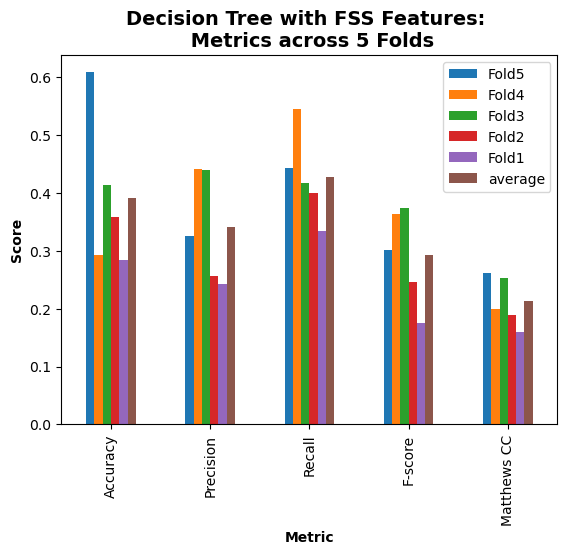

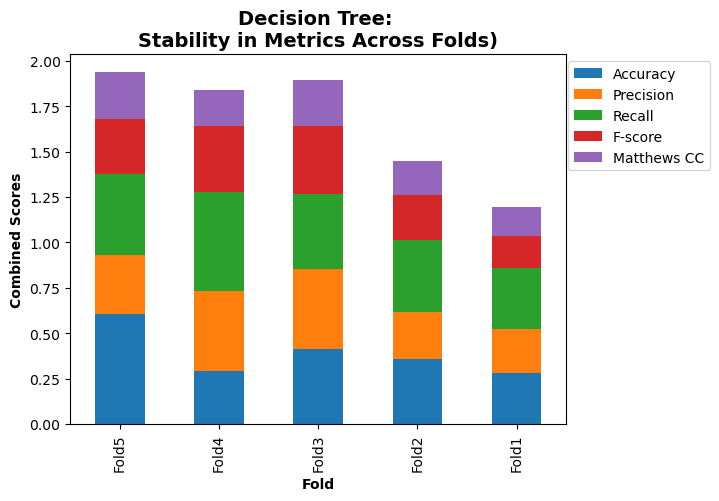

In [815]:
ax = dc_FFS_metrics.iloc[0:5].plot.bar(stacked=False);
plt.ylabel('Score', fontweight="bold", size = 10);
plt.xlabel('Metric', fontweight="bold", size = 10);
plt.title('Decision Tree with FSS Features: \n Metrics across 5 Folds', fontweight="bold", size = 14);
plt.show();

ax = dc_FFS_metrics_T.iloc[:,0:5].plot.bar(stacked=True);
plt.ylabel('Combined Scores', fontweight="bold", size = 10);
plt.xlabel('Fold', fontweight="bold", size = 10);
plt.title('Decision Tree: \nStability in Metrics Across Folds)', fontweight="bold", size = 14);
plt.legend(bbox_to_anchor=(0.99, 1))
plt.show();

In [ ]:
#Accruacy with FFS features continued going down with each fold. 
#Checking all 5 folds with all features to see if it performs better across folds. 

In [642]:
#Fold4 Decision Tree Classifier - All Features

start_time = time.time()

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_tr4_df,y_tr4_df)

#Predict the response for test dataset
y_pred4all = clf.predict(X_test4_df)

# Model Accuracy, how often is the classifier correct?
dc4_accuracy = accuracy_score(y_test4_df,y_pred4all)
print("Accuracy score: ", (dc4_accuracy))
dc4_Time = time.time() - start_time
print("This Decision Tree Model took:", dc4_Time, "seconds to run")
dc4_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
dc4_GB = dc4_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("This Decision Tree Model used:", dc4_GB, "gigabytes (GB) of memory to run")


Accuracy score:  0.32527034718269776
This Decision Tree Model took: 1.737274169921875 seconds to run
This Decision Tree Model used: 2.267058176 gigabytes (GB) of memory to run


In [643]:
precision,recall,fscore,support=score(y_test4_df,y_pred4all, average="macro")
dc4_precision = precision
dc4_recall = recall
dc4_Fscore = fscore
dc4_MCC = matthews_corrcoef(y_test4_df,y_pred4all)
dc4_metrics = [dc4_accuracy, dc4_precision, dc4_recall, dc4_Fscore, dc4_MCC, dc4_Time, dc4_GB]


In [644]:
#Fold3 Decision Tree Classifier - All Features

start_time = time.time()

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_tr3_df,y_tr3_df)

#Predict the response for test dataset
y_pred3all = clf.predict(X_test3_df)

# Model Accuracy, how often is the classifier correct?
dc3_accuracy = accuracy_score(y_test3_df,y_pred3all)
print("Accuracy score: ", (dc3_accuracy))
dc3_Time = time.time() - start_time
print("This Decision Tree Model took:", dc3_Time, "seconds to run")
dc3_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
dc3_GB = dc3_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("This Decision Tree Model used:", dc3_GB, "gigabytes (GB) of memory to run")


Accuracy score:  0.4075965528247686
This Decision Tree Model took: 1.033066987991333 seconds to run
This Decision Tree Model used: 2.267058176 gigabytes (GB) of memory to run


In [645]:
precision,recall,fscore,support=score(y_test3_df,y_pred3all, average="macro")
dc3_precision = precision
dc3_recall = recall
dc3_Fscore = fscore
dc3_MCC = matthews_corrcoef(y_test3_df,y_pred3all)
dc3_metrics = [dc3_accuracy, dc3_precision, dc3_recall, dc3_Fscore, dc3_MCC, dc3_Time, dc3_GB]


In [646]:
#Fold2 Decision Tree Classifier - All Features

start_time = time.time()

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_tr2_df,y_tr2_df)

#Predict the response for test dataset
y_pred2all = clf.predict(X_test2_df)

# Model Accuracy, how often is the classifier correct?
dc2_accuracy = accuracy_score(y_test2_df,y_pred2all)
print("Accuracy score: ", (dc2_accuracy))
dc2_Time = time.time() - start_time
print("This Decision Tree Model took:", dc2_Time, "seconds to run")
dc2_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
dc2_GB = dc2_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("This Decision Tree Model used:", dc2_GB, "gigabytes (GB) of memory to run")


Accuracy score:  0.2994125052454889
This Decision Tree Model took: 0.8583579063415527 seconds to run
This Decision Tree Model used: 2.267058176 gigabytes (GB) of memory to run


In [648]:
precision,recall,fscore,support=score(y_test2_df,y_pred2all, average="macro")
dc2_precision = precision
dc2_recall = recall
dc2_Fscore = fscore
dc2_MCC = matthews_corrcoef(y_test2_df,y_pred2all)
dc2_metrics = [dc2_accuracy, dc2_precision, dc2_recall, dc2_Fscore, dc2_MCC, dc2_Time, dc2_GB]


In [649]:
#Fold1 Decision Tree Classifier - All Features

start_time = time.time()

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_tr1_df,y_tr1_df)

#Predict the response for test dataset
y_pred1all = clf.predict(X_test1_df)

# Model Accuracy, how often is the classifier correct?
dc1_accuracy = accuracy_score(y_test1_df,y_pred1all)
print("Accuracy score: ", (dc1_accuracy))
dc1_Time = time.time() - start_time
print("This Decision Tree Model took:", dc1_Time, "seconds to run")
dc1_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
dc1_GB = dc1_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("This Decision Tree Model used:", dc1_GB, "gigabytes (GB) of memory to run")


Accuracy score:  0.15955176093916756
This Decision Tree Model took: 0.3723468780517578 seconds to run
This Decision Tree Model used: 2.267058176 gigabytes (GB) of memory to run


In [650]:
precision,recall,fscore,support=score(y_test1_df,y_pred1all, average="macro")
dc1_precision = precision
dc1_recall = recall
dc1_Fscore = fscore
dc1_MCC = matthews_corrcoef(y_test1_df,y_pred1all)
dc1_metrics = [dc1_accuracy, dc1_precision, dc1_recall, dc1_Fscore, dc1_MCC, dc1_Time, dc1_GB]


In [651]:
#Comparing between using Forward Feature Selection (FFS) Top 6 vs. intrinsic features selection in
#decision tree. Results are very close, but FFS is sightly higher. Will use FFS features.

index = ["Accuracy", "Precision", "Recall", "F-score", "Matthews CC","Time (seconds)", "Memory (GBs)"]
dc_metrics = pd.DataFrame(dc5_metrics, index=index, columns=["Fold5"])
dc_metrics["Fold4"] = dc4_metrics
dc_metrics["Fold3"] = dc3_metrics
dc_metrics["Fold2"] = dc2_metrics
dc_metrics["Fold1"] = dc1_metrics

dc_metrics


Fold5     Fold4     Fold3     Fold2     Fold1
Accuracy        0.570452  0.325270  0.407597  0.299413  0.159552
Precision       0.366346  0.417948  0.322106  0.222819  0.237744
Recall          0.492464  0.570767  0.392158  0.413638  0.354260
F-score         0.359953  0.395954  0.290993  0.216893  0.183000
Matthews CC     0.290048  0.231369  0.149893  0.152292  0.102614
Time (seconds)  3.575523  1.737274  1.033067  0.858358  0.372347
Memory (GBs)    2.267058  2.267058  2.267058  2.267058  2.267058

In [652]:
dc_metrics_T = dc_metrics.transpose()

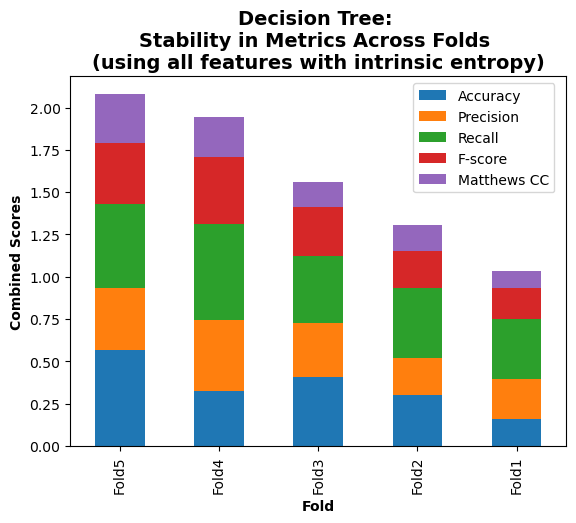

In [654]:
ax = dc_metrics.iloc[0:5].plot.bar(stacked=False);
plt.ylabel('Score', fontweight="bold", size = 10);
plt.xlabel('Metric', fontweight="bold", size = 10);
plt.title('Decision Tree: \n Metrics across 5 Folds \n(using all features with intrinsic entropy)', fontweight="bold", size = 14);
plt.show();

ax = dc_metrics_T.iloc[:,0:5].plot.bar(stacked=True);
plt.ylabel('Combined Scores', fontweight="bold", size = 10);
plt.xlabel('Fold', fontweight="bold", size = 10);
plt.title('Decision Tree: \nStability in Metrics Across Folds \n(using all features with intrinsic entropy)', fontweight="bold", size = 14);
plt.legend(bbox_to_anchor=(0.99, 1))
plt.show();

In [655]:
dc_FFS_metrics['average'] = dc_FFS_metrics.mean(axis=1)
dc_FFS_metrics
dc_FFS_avg = dc_FFS_metrics.iloc[:,5]
dc_comp = pd.DataFrame(dc_FFS_avg)
dc_comp.columns=["FSS Averages"]
dc_comp

dc_metrics['average'] = dc_metrics.mean(axis=1)
dc_metrics
dc_avg = dc_metrics.iloc[:,5]

dc_comp["Entropy Averages"] = dc_avg
dc_comp_T = dc_comp.transpose()
dc_comp

FSS Averages  Entropy Averages
Accuracy            0.390845          0.352457
Precision           0.340958          0.313393
Recall              0.426756          0.444658
F-score             0.291737          0.289359
Matthews CC         0.212236          0.185243
Time (seconds)      0.366366          1.515314
Memory (GBs)        2.267058          2.267058

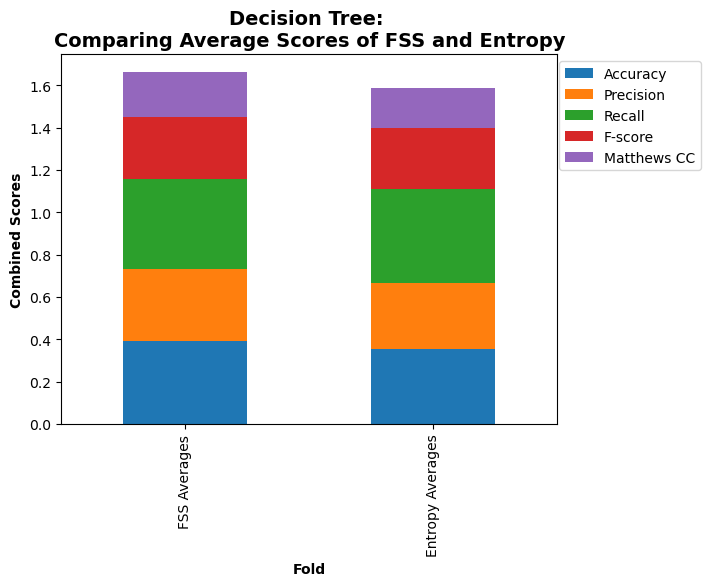

In [656]:
ax = dc_comp.iloc[0:5].plot.bar(stacked=False);
plt.ylabel('Score', fontweight="bold", size = 10);
plt.xlabel('Metric', fontweight="bold", size = 10);
plt.title('Decision Tree: \n Comparing Average Scores of FSS and Entropy', fontweight="bold", size = 14);
plt.show();

ax = dc_comp_T.iloc[:,0:5].plot.bar(stacked=True);
plt.ylabel('Combined Scores', fontweight="bold", size = 10);
plt.xlabel('Fold', fontweight="bold", size = 10);
plt.title('Decision Tree: \nComparing Average Scores of FSS and Entropy', fontweight="bold", size = 14);
plt.legend(bbox_to_anchor=(0.99, 1))
plt.show();

**Decision Tree Model is still performing slightly better with the FSS Top 6 Features. Will use that model as my final Decision Tree to compare**

## Random Forest Modeling

Uses default of n_estimators = 100 (100 trees), criterion = gini

In [416]:
#https://www.datacamp.com/tutorial/random-forests-classifier-python


# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, matthews_corrcoef, brier_score_loss
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import time
import resource

In [674]:
# FSS Top 6 Features, Random Forest, Fold 5

start_time = time.time()

rf = RandomForestClassifier()
rf.fit(X_tr5_df_FF6, y_tr5)

y_pred5 = rf.predict(X_test5_df_FF6)


#Visualizing the Results 
#Export the first three decision trees from the forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_tr5_df_FF6.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    #display(graph)

    
FFS5_RFTime = time.time() - start_time
print("The Random Forest model took:", FFS5_RFTime, "seconds to run")
FFS5_RFBytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
FFS5_RFGB = FFS5_RFBytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Random Forest  model used:", FFS5_RFGB, "gigabytes (GB) of memory to run")

FFS5_RFAccuracy = accuracy_score(y_test5_df, y_pred5)
print("Random Forest Accuracy:", FFS5_RFAccuracy)
FFS5_RFPrecision = precision_score(y_test5_df, y_pred5, average = "macro")
print("Random Forest Precision:", FFS5_RFPrecision)
FFS5_RFRecall = recall_score(y_test5_df, y_pred5, average = "macro")
print("Random Forest Recall:", FFS5_RFRecall)
FFS5_RFF1 = f1_score(y_test5_df, y_pred5, average='macro')
print("Random Forest F1:", FFS5_RFF1)
FFS5_RFMCC = matthews_corrcoef(y_test5_df, y_pred5)
print("Random Forest Matthews Correlation Coefficient:", FFS5_RFMCC)


The Random Forest model took: 34.849122047424316 seconds to run
The Random Forest  model used: 2.516086784 gigabytes (GB) of memory to run
Random Forest Accuracy: 0.6725492007761249
Random Forest Precision: 0.4212476496254401
Random Forest Recall: 0.5730068789193762
Random Forest F1: 0.4557107255074946
Random Forest Matthews Correlation Coefficient: 0.4149018006066813


In [676]:
FSS5_RF_metrics = [FFS5_RFAccuracy, FFS5_RFPrecision, FFS5_RFRecall, FFS5_RFF1, FFS5_RFMCC, FFS5_RFTime, FFS5_RFGB]
FSS5_RF_metrics

[0.6725492007761249,
 0.4212476496254401,
 0.5730068789193762,
 0.4557107255074946,
 0.4149018006066813,
 34.849122047424316,
 2.516086784]

In [761]:
# Random Forest, Fold 5, All Features


start_time = time.time()

rf = RandomForestClassifier()
rf.fit(X_tr5_df, y_tr5)

y_pred5 = rf.predict(X_test5_df)

rf_feature_importances5 = pd.DataFrame(rf.feature_importances_,
                                    index = X_tr5_df.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print("Random Forest Fold 5, feature importance:", rf_feature_importances5)


#Visualizing the Results 
#Export the first three decision trees from the forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_tr5_df.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    #display(graph)

RF5_Time = time.time() - start_time
print("The Random Forest model took:", RF5_Time, "seconds to run")
RF5_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
RF5_GB = RF5_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Random Forest  model used:", RF5_GB, "gigabytes (GB) of memory to run")

RF5_Accuracy = accuracy_score(y_test5_df, y_pred5)
print("Random Forest Accuracy:", RF5_Accuracy)
RF5_Precision = precision_score(y_test5_df, y_pred5, average = "macro")
print("Random Forest Precision:", RF5_Precision)
RF5_Recall = recall_score(y_test5_df, y_pred5, average = "macro")
print("Random Forest Recall:", RF5_Recall)
RF5_F1 = f1_score(y_test5_df, y_pred5, average='macro')
print("Random Forest F1:", RF5_F1)
RF5_MCC = matthews_corrcoef(y_test5_df, y_pred5)
print("Random Forest Matthews Correlation Coefficient:", RF5_MCC)


Random Forest Fold 5, feature importance:       importance
8   2.070543e-01
9   1.151616e-01
0   1.112397e-01
7   9.227633e-02
1   5.582755e-02
..           ...
89  8.674329e-07
56  3.579209e-07
54  0.000000e+00
88  0.000000e+00
38  0.000000e+00

[98 rows x 1 columns]
The Random Forest model took: 60.20302081108093 seconds to run
The Random Forest  model used: 2.516086784 gigabytes (GB) of memory to run
Random Forest Accuracy: 0.7701191906125843
Random Forest Precision: 0.4407640918549202
Random Forest Recall: 0.45009910404963815
Random Forest F1: 0.42836626819084944
Random Forest Matthews Correlation Coefficient: 0.45009791524634285


/Users/nerdbear/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


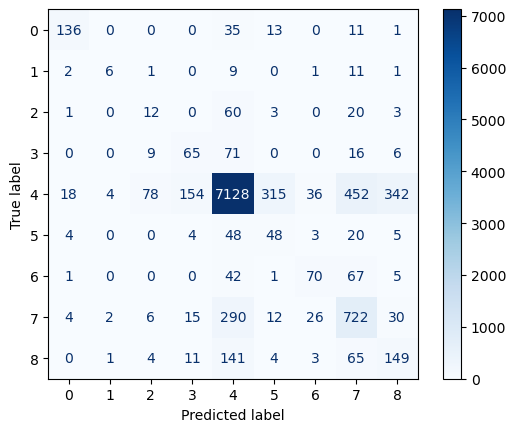

In [679]:
rf_5_cm = plot_confusion_matrix(rf,X_test5_df,y_test5_enc,cmap=plt.cm.Blues)
rf_5_cm


In [680]:
RF5_metrics = [RF5_Accuracy, RF5_Precision, RF5_Recall, RF5_F1, RF5_MCC, RF5_Time, RF5_GB]
RF5_metrics

[0.7702115864362931,
 0.4425985437472238,
 0.44668511864612687,
 0.4266112925345906,
 0.45108133352817326,
 58.17391109466553,
 2.516086784]

In [681]:
#Comparing between using Forward Feature Selection (FFS) Top 6 vs. intrinsic features selection in
#Random Forest. 

index = ["Accuracy", "Precision", "Recall", "F-score", "Matthews CC","Time (seconds)", "Memory (GBs)"]
rf_metrics_comp = pd.DataFrame(FSS5_RF_metrics, index=index, columns=["Fold5 FFS"])
rf_metrics_comp["Fold5 all"] = RF5_metrics

rf_metrics_comp_T = rf_metrics_comp.transpose()


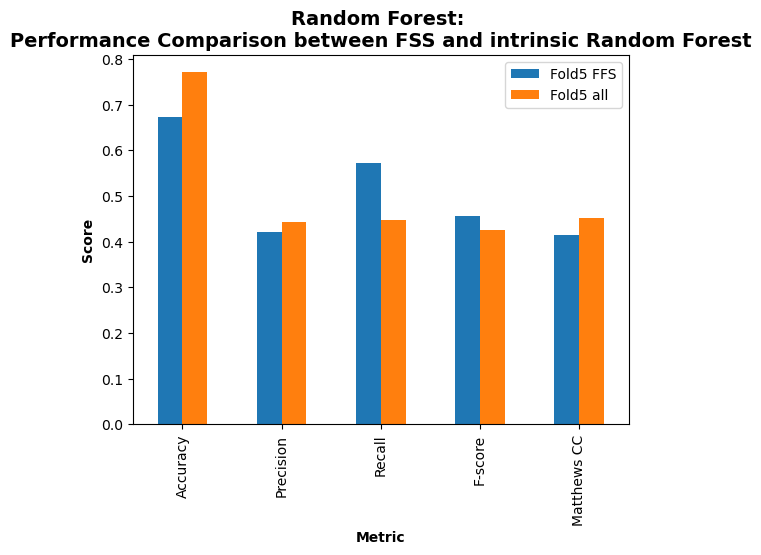

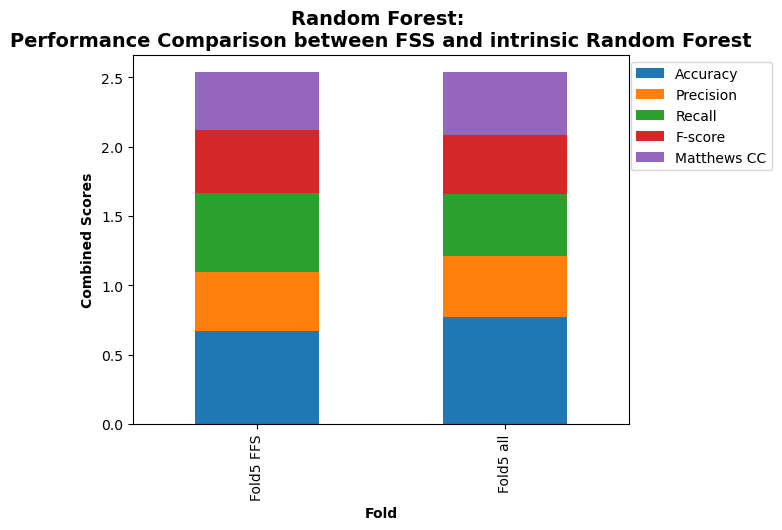

In [682]:
ax = rf_metrics_comp.iloc[0:5].plot.bar(stacked=False);
plt.ylabel('Score', fontweight="bold", size = 10);
plt.xlabel('Metric', fontweight="bold", size = 10);
plt.title('Random Forest: \nPerformance Comparison between FSS and intrinsic Random Forest', fontweight="bold", size = 14);
plt.show();

ax = rf_metrics_comp_T.iloc[:,0:5].plot.bar(stacked=True);
plt.ylabel('Combined Scores', fontweight="bold", size = 10);
plt.xlabel('Fold', fontweight="bold", size = 10);
plt.title('Random Forest: \nPerformance Comparison between FSS and intrinsic Random Forest', fontweight="bold", size = 14);
plt.legend(bbox_to_anchor=(0.99, 1))
plt.show();

The Random Forest's intrinsic feature selection performs very slightly better than using the Forward Feature Selection Top 6 Features. They are so close, I could probably use either. I'm going to use all features here (result scores are so close, but random forest takes some more time and the FFS feature selector takes a lot of time to run, so running random forest with all features (and not needed FFS) would be a better for time. 

Will Use the intrinsic selction on all features for the final Random Forest's model. 

In [764]:
# Random Forest, Fold 4, All Features

start_time = time.time()

rf = RandomForestClassifier()
rf.fit(X_tr4_df, y_tr4)

y_pred4 = rf.predict(X_test4_df)

rf_feature_importances4 = pd.DataFrame(rf.feature_importances_,
                                    index = X_tr4_df.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print("Random Forest Fold 4, feature importance:", rf_feature_importances4)


#Visualizing the Results 
#Export the first three decision trees from the forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_tr4_df.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    #display(graph)

RF4_Time = time.time() - start_time
print("The Random Forest model took:", RF4_Time, "seconds to run")
RF4_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
RF4_GB = RF4_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Random Forest  model used:", RF4_GB, "gigabytes (GB) of memory to run")

RF4_Accuracy = accuracy_score(y_test4_df, y_pred4)
print("Random Forest Accuracy:", RF4_Accuracy)
RF4_Precision = precision_score(y_test4_df, y_pred4, average = "macro")
print("Random Forest Precision:", RF4_Precision)
RF4_Recall = recall_score(y_test4_df, y_pred4, average = "macro")
print("Random Forest Recall:", RF4_Recall)
RF4_F1 = f1_score(y_test4_df, y_pred4, average='macro')
print("Random Forest F1:", RF4_F1)
RF4_MCC = matthews_corrcoef(y_test4_df, y_pred4)
print("Random Forest Matthews Correlation Coefficient:", RF4_MCC)

RF4_metrics = [RF4_Accuracy, RF4_Precision, RF4_Recall, RF4_F1, RF4_MCC, RF4_Time, RF4_GB]


Random Forest Fold 4, feature importance:     importance
8     0.196734
0     0.116136
9     0.114032
7     0.095361
2     0.056111
..         ...
38    0.000000
88    0.000000
89    0.000000
54    0.000000
22    0.000000

[98 rows x 1 columns]
The Random Forest model took: 35.16019320487976 seconds to run
The Random Forest  model used: 2.516086784 gigabytes (GB) of memory to run
Random Forest Accuracy: 0.71438057294631
Random Forest Precision: 0.5181573898594638
Random Forest Recall: 0.46330705410118994
Random Forest F1: 0.45517568085694315
Random Forest Matthews Correlation Coefficient: 0.40573737642525215


In [765]:
# Random Forest, Fold 3, All Features

start_time = time.time()

rf = RandomForestClassifier()
rf.fit(X_tr3_df, y_tr3)

y_pred3 = rf.predict(X_test3_df)

rf_feature_importances3 = pd.DataFrame(rf.feature_importances_,
                                    index = X_tr3_df.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print("Random Forest Fold 3, feature importance:", rf_feature_importances3)


#Visualizing the Results 
#Export the first three decision trees from the forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_tr3_df.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    #display(graph)

RF3_Time = time.time() - start_time
print("The Random Forest model took:", RF3_Time, "seconds to run")
RF3_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
RF3_GB = RF3_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Random Forest  model used:", RF3_GB, "gigabytes (GB) of memory to run")

RF3_Accuracy = accuracy_score(y_test3_df, y_pred3)
print("Random Forest Accuracy:", RF3_Accuracy)
RF3_Precision = precision_score(y_test3_df, y_pred3, average = "macro")
print("Random Forest Precision:", RF3_Precision)
RF3_Recall = recall_score(y_test3_df, y_pred3, average = "macro")
print("Random Forest Recall:", RF3_Recall)
RF3_F1 = f1_score(y_test3_df, y_pred3, average='macro')
print("Random Forest F1:", RF3_F1)
RF3_MCC = matthews_corrcoef(y_test3_df, y_pred3)
print("Random Forest Matthews Correlation Coefficient:", RF3_MCC)

RF3_metrics = [RF3_Accuracy, RF3_Precision, RF3_Recall, RF3_F1, RF3_MCC, RF3_Time, RF3_GB]


Random Forest Fold 3, feature importance:     importance
8     0.193421
0     0.116832
9     0.111336
7     0.090374
2     0.061200
..         ...
35    0.000000
32    0.000000
52    0.000000
75    0.000000
97    0.000000

[98 rows x 1 columns]
The Random Forest model took: 21.078426122665405 seconds to run
The Random Forest  model used: 2.516086784 gigabytes (GB) of memory to run
Random Forest Accuracy: 0.5920842642834344
Random Forest Precision: 0.4297736981192726
Random Forest Recall: 0.3136370900491887
Random Forest F1: 0.2938449641739882
Random Forest Matthews Correlation Coefficient: 0.2784860230485296


In [766]:
# Random Forest, Fold 2, All Features

start_time = time.time()

rf = RandomForestClassifier()
rf.fit(X_tr2_df, y_tr2)

y_pred2 = rf.predict(X_test2_df)

rf_feature_importances2 = pd.DataFrame(rf.feature_importances_,
                                    index = X_tr2_df.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print("Random Forest Fold 2, feature importance:", rf_feature_importances2)


#Visualizing the Results 
#Export the first three decision trees from the forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_tr2_df.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    #display(graph)

RF2_Time = time.time() - start_time
print("The Random Forest model took:", RF2_Time, "seconds to run")
RF2_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
RF2_GB = RF2_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Random Forest  model used:", RF2_GB, "gigabytes (GB) of memory to run")

RF2_Accuracy = accuracy_score(y_test2_df, y_pred2)
print("Random Forest Accuracy:", RF2_Accuracy)
RF2_Precision = precision_score(y_test2_df, y_pred2, average = "macro")
print("Random Forest Precision:", RF2_Precision)
RF2_Recall = recall_score(y_test2_df, y_pred2, average = "macro")
print("Random Forest Recall:", RF2_Recall)
RF2_F1 = f1_score(y_test2_df, y_pred2, average='macro')
print("Random Forest F1:", RF2_F1)
RF2_MCC = matthews_corrcoef(y_test2_df, y_pred2)
print("Random Forest Matthews Correlation Coefficient:", RF2_MCC)

RF2_metrics = [RF2_Accuracy, RF2_Precision, RF2_Recall, RF2_F1, RF2_MCC, RF2_Time, RF2_GB]


Random Forest Fold 2, feature importance:     importance
8     0.188235
0     0.113068
9     0.108789
7     0.092343
1     0.064511
..         ...
39    0.000000
38    0.000000
75    0.000000
76    0.000000
97    0.000000

[98 rows x 1 columns]
The Random Forest model took: 12.341587781906128 seconds to run
The Random Forest  model used: 2.516086784 gigabytes (GB) of memory to run
Random Forest Accuracy: 0.7039446076374318
Random Forest Precision: 0.39529982051969675
Random Forest Recall: 0.40047071952712415
Random Forest F1: 0.38917053219269726
Random Forest Matthews Correlation Coefficient: 0.4777809543900972


In [767]:
# Random Forest, Fold 1, All Features

start_time = time.time()

rf = RandomForestClassifier()
rf.fit(X_tr1_df, y_tr1)

y_pred1 = rf.predict(X_test1_df)

rf_feature_importances1 = pd.DataFrame(rf.feature_importances_,
                                    index = X_tr1_df.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print("Random Forest Fold 1, feature importance:", rf_feature_importances1)


#Visualizing the Results 
#Export the first three decision trees from the forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_tr1_df.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    #display(graph)

RF1_Time = time.time() - start_time
print("The Random Forest model took:", RF1_Time, "seconds to run")
RF1_Bytes = (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
RF1_GB = RF1_Bytes/1000000000
# peak memory usage (kilobytes on Linux, bytes on OS X)
print("The Random Forest  model used:", RF1_GB, "gigabytes (GB) of memory to run")

RF1_Accuracy = accuracy_score(y_test1_df, y_pred1)
print("Random Forest Accuracy:", RF1_Accuracy)
RF1_Precision = precision_score(y_test1_df, y_pred1, average = "macro")
print("Random Forest Precision:", RF1_Precision)
RF1_Recall = recall_score(y_test1_df, y_pred1, average = "macro")
print("Random Forest Recall:", RF1_Recall)
RF1_F1 = f1_score(y_test1_df, y_pred1, average='macro')
print("Random Forest F1:", RF1_F1)
RF1_MCC = matthews_corrcoef(y_test1_df, y_pred1)
print("Random Forest Matthews Correlation Coefficient:", RF1_MCC)

RF1_metrics = [RF1_Accuracy, RF1_Precision, RF1_Recall, RF1_F1, RF1_MCC, RF1_Time, RF1_GB]


Random Forest Fold 1, feature importance:     importance
8     0.184377
0     0.115076
9     0.109427
7     0.095540
2     0.062337
..         ...
63    0.000000
64    0.000000
67    0.000000
68    0.000000
97    0.000000

[98 rows x 1 columns]
The Random Forest model took: 6.332283020019531 seconds to run
The Random Forest  model used: 2.516086784 gigabytes (GB) of memory to run
Random Forest Accuracy: 0.6945037353255069
Random Forest Precision: 0.3527011828781661
Random Forest Recall: 0.3500457631134896
Random Forest F1: 0.3508854307827973
Random Forest Matthews Correlation Coefficient: 0.47727082494936135


In [768]:
#Comparing between using Forward Feature Selection (FFS) Top 6 vs. intrinsic features selection in
#Random Forest. 

index = ["Accuracy", "Precision", "Recall", "F-score", "Matthews CC","Time (seconds)", "Memory (GBs)"]
rf_comp = pd.DataFrame(RF5_metrics, index=index, columns=["Fold5"])
rf_comp["Fold4"] = RF4_metrics
rf_comp["Fold3"] = RF3_metrics
rf_comp["Fold2"] = RF2_metrics
rf_comp["Fold1"] = RF1_metrics
rf_comp


Fold5      Fold4      Fold3      Fold2     Fold1
Accuracy         0.770212   0.714381   0.592084   0.703945  0.694504
Precision        0.442599   0.518157   0.429774   0.395300  0.352701
Recall           0.446685   0.463307   0.313637   0.400471  0.350046
F-score          0.426611   0.455176   0.293845   0.389171  0.350885
Matthews CC      0.451081   0.405737   0.278486   0.477781  0.477271
Time (seconds)  58.173911  35.160193  21.078426  12.341588  6.332283
Memory (GBs)     2.516087   2.516087   2.516087   2.516087  2.516087

In [769]:
rf_comp_avgs=rf_comp.copy()
rf_comp_avgs['average'] = rf_comp_avgs.mean(axis=1)
rf_comp_avgs
rf_avgs = rf_comp_avgs.iloc[:,5]
rf_avgs

Accuracy           0.695025
Precision          0.427706
Recall             0.394829
F-score            0.383138
Matthews CC        0.418071
Time (seconds)    26.617280
Memory (GBs)       2.516087
Name: average, dtype: float64

In [770]:
rf_comp_T = rf_comp.transpose()
rf_comp_T

Accuracy  Precision    Recall   F-score  Matthews CC  Time (seconds)  \
Fold5  0.770212   0.442599  0.446685  0.426611     0.451081       58.173911   
Fold4  0.714381   0.518157  0.463307  0.455176     0.405737       35.160193   
Fold3  0.592084   0.429774  0.313637  0.293845     0.278486       21.078426   
Fold2  0.703945   0.395300  0.400471  0.389171     0.477781       12.341588   
Fold1  0.694504   0.352701  0.350046  0.350885     0.477271        6.332283   

       Memory (GBs)  
Fold5      2.516087  
Fold4      2.516087  
Fold3      2.516087  
Fold2      2.516087  
Fold1      2.516087

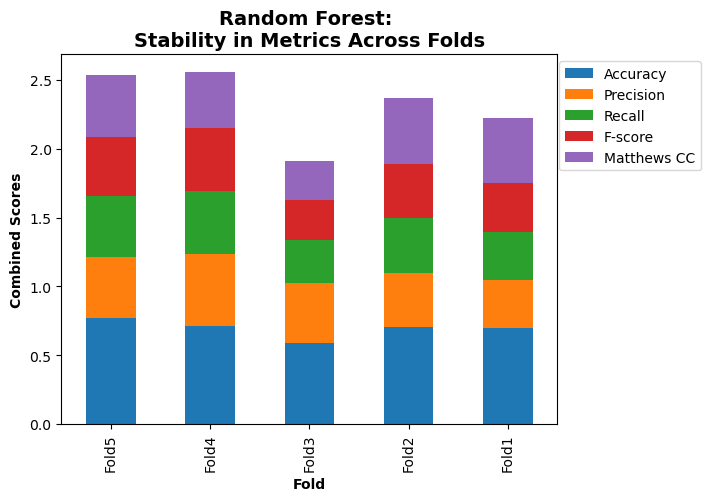

In [771]:
ax = rf_comp.iloc[0:5].plot.bar(stacked=False);
plt.ylabel('Score', fontweight="bold", size = 10);
plt.xlabel('Metric', fontweight="bold", size = 10);
plt.title('Random Forest: \nMetrics Across Folds', fontweight="bold", size = 14);
plt.show();

ax = rf_comp_T.iloc[:,0:5].plot.bar(stacked=True);
plt.ylabel('Combined Scores', fontweight="bold", size = 10);
plt.xlabel('Fold', fontweight="bold", size = 10);
plt.title('Random Forest: \nStability in Metrics Across Folds', fontweight="bold", size = 14);
plt.legend(bbox_to_anchor=(0.99, 1))
plt.show();

**Looking at what features RF evaluates as top 6 (to compare with features used by FFS and KB)**

In [772]:
rf5Top6 = rf_feature_importances5.nlargest(6, ["importance"])
rf4Top6 = rf_feature_importances4.nlargest(6, ["importance"])
rf3Top6 = rf_feature_importances3.nlargest(6, ["importance"])
rf2Top6 = rf_feature_importances2.nlargest(6, ["importance"])
rf1Top6 = rf_feature_importances1.nlargest(6, ["importance"])

In [773]:
rfSix = pd.concat([rf1Top6["importance"], rf2Top6["importance"], rf3Top6["importance"], rf4Top6["importance"], rf5Top6["importance"]], axis=1)
rfSix = rfSix.set_axis(['Fold1 Score', 'Fold2 Score', 'Fold3 Score', 'Fold4 Score', 'Fold5 Score'], axis=1, inplace=False)
rfSix = rfSix.transpose()
rfSix


8         0         9         7         2         1
Fold1 Score  0.184377  0.115076  0.109427  0.095540  0.062337  0.058969
Fold2 Score  0.188235  0.113068  0.108789  0.092343  0.062126  0.064511
Fold3 Score  0.193421  0.116832  0.111336  0.090374  0.061200  0.059059
Fold4 Score  0.196734  0.116136  0.114032  0.095361  0.056111  0.056068
Fold5 Score  0.207054  0.111240  0.115162  0.092276  0.051151  0.055828

In [774]:
rfSixMean = rfSix.copy()
rfSixMean.loc['mean'] = rfSixMean.mean()
rfSixMean

8         0         9         7         2         1
Fold1 Score  0.184377  0.115076  0.109427  0.095540  0.062337  0.058969
Fold2 Score  0.188235  0.113068  0.108789  0.092343  0.062126  0.064511
Fold3 Score  0.193421  0.116832  0.111336  0.090374  0.061200  0.059059
Fold4 Score  0.196734  0.116136  0.114032  0.095361  0.056111  0.056068
Fold5 Score  0.207054  0.111240  0.115162  0.092276  0.051151  0.055828
mean         0.193964  0.114471  0.111749  0.093179  0.058585  0.058887

In [776]:
rfSix_fullname = rfSix.copy()
rfSix_fullname = rfSix_fullname.set_axis(list(train_set5_enc.iloc[:, rfSix.columns].columns), axis=1, inplace=False)
rfSix_fullname
rfSixMean_fullname = rfSix_fullname.copy()
rfSixMean_fullname = rfSixMean_fullname.transpose()
rfSixMean_fullname.loc['mean'] = rfSixMean_fullname.mean()
rfSixMean_fullname



Fold1 Score  Fold2 Score  Fold3 Score  Fold4 Score  \
Total Staff Hours           0.184377     0.188235     0.193421     0.196734   
Incident Month              0.115076     0.113068     0.116832     0.116136   
Species Common Name         0.109427     0.108789     0.111336     0.114032   
Total Staff Involved        0.095540     0.092343     0.090374     0.095361   
Protected Heritage Area     0.062337     0.062126     0.061200     0.056111   
Field Unit                  0.058969     0.064511     0.059059     0.056068   
mean                        0.104288     0.104845     0.105370     0.105740   

                         Fold5 Score  
Total Staff Hours           0.207054  
Incident Month              0.111240  
Species Common Name         0.115162  
Total Staff Involved        0.092276  
Protected Heritage Area     0.051151  
Field Unit                  0.055828  
mean                        0.105452

In [780]:
rfSix_T = rfSix.transpose()
rfSix_fullname_T = rfSix_fullname.transpose()

Fold1 Score  Fold2 Score  Fold3 Score  Fold4 Score  Fold5 Score
8     0.184377     0.188235     0.193421     0.196734     0.207054
0     0.115076     0.113068     0.116832     0.116136     0.111240
9     0.109427     0.108789     0.111336     0.114032     0.115162
7     0.095540     0.092343     0.090374     0.095361     0.092276
2     0.062337     0.062126     0.061200     0.056111     0.051151
1     0.058969     0.064511     0.059059     0.056068     0.055828

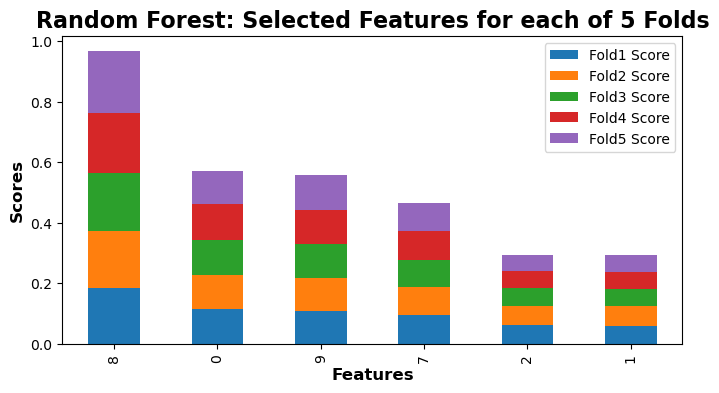

In [785]:
ax = rfSix_T.plot.bar(stacked=True, figsize=(8,4));
plt.ylabel('Scores', fontweight="bold", size = 12);
plt.xlabel('Features', fontweight="bold", size = 12);
plt.title('Random Forest: Selected Features for each of 5 Folds', fontweight="bold", size = 16);
plt.show();

ax = rfSix_fullname_T.plot.bar(stacked=True, figsize=(8,5))
plt.ylabel('Scores', fontweight="bold", size = 12);
plt.xlabel('Feature Full Names', fontweight="bold", size = 12);
plt.title('Random Forest:Selected Features for each of 5 Folds (with Names)', fontweight="bold", size = 16);
plt.show();

## Model Evaluation


**Evaluation Metrics to Use**
1. Accuracy
2. Precision
3. Recall
4. F1
5. Matthews correlation coefficient
8. Training Time (seconds)
9. Memory Use (GBs)


In [716]:
FFS_logr_avgs = FFS_logr_metrics.copy()
FFS_logr_avgs['average'] = FFS_logr_avgs.mean(axis=1)
FFS_logr_avgs = FFS_logr_avgs.iloc[:,5]

In [821]:
Metric_comp = pd.DataFrame(FFS_logr_avgs)
Metric_comp.columns=["Multinomial Logistic Regression"]
Metric_comp["Decision Tree"] = FSS_dc_avg
Metric_comp["Random Forest"] = rf_avgs
Metric_comp_T = Metric_comp.transpose()
Metric_comp_T

Accuracy  Precision    Recall   F-score  \
Multinomial Logistic Regression  0.140706   0.238315  0.355091  0.166682   
Decision Tree                    0.390845   0.696582  0.390845  0.448503   
Random Forest                    0.695025   0.427706  0.394829  0.383138   

                                 Matthews CC  Time (seconds)  Memory (GBs)  
Multinomial Logistic Regression     0.103437       58.796719      2.267058  
Decision Tree                       0.212236        0.372536      2.267058  
Random Forest                       0.418071       26.617280      2.516087

In [718]:
ax = Metric_comp.iloc[0:5].plot.bar(stacked=False);
plt.ylabel('Score', fontweight="bold", size = 10);
plt.xlabel('Metric', fontweight="bold", size = 10);
plt.title('Comparing 3 Models by Average Metrics', fontweight="bold", size = 14);
plt.legend(bbox_to_anchor=(0.99, 1))
plt.show();


In [719]:
ax = Metric_comp_T.iloc[:,0:5].plot.bar(stacked=True);
plt.ylabel('Combined Scores', fontweight="bold", size = 10);
plt.xlabel('Model', fontweight="bold", size = 10);
plt.title('Comparing 3 Models by Combined Metrics', fontweight="bold", size = 14);
plt.legend(bbox_to_anchor=(0.99, 1))
plt.show();

In [738]:
Time = pd.DataFrame(Metric_comp_T.iloc[:,5])
Time.columns = ["Modeling Time (seconds)"]
Time["Forward Feature Selection Time (seconds)"] = [FFSTime, FFSTime, 0]
Time

Modeling Time (seconds)  \
Multinomial Logistic Regression                58.796719   
Decision Tree                                   0.372536   
Random Forest                                  26.614972   

                                 Forward Feature Selection Time (seconds)  
Multinomial Logistic Regression                               3002.774455  
Decision Tree                                                 3002.774455  
Random Forest                                                    0.000000

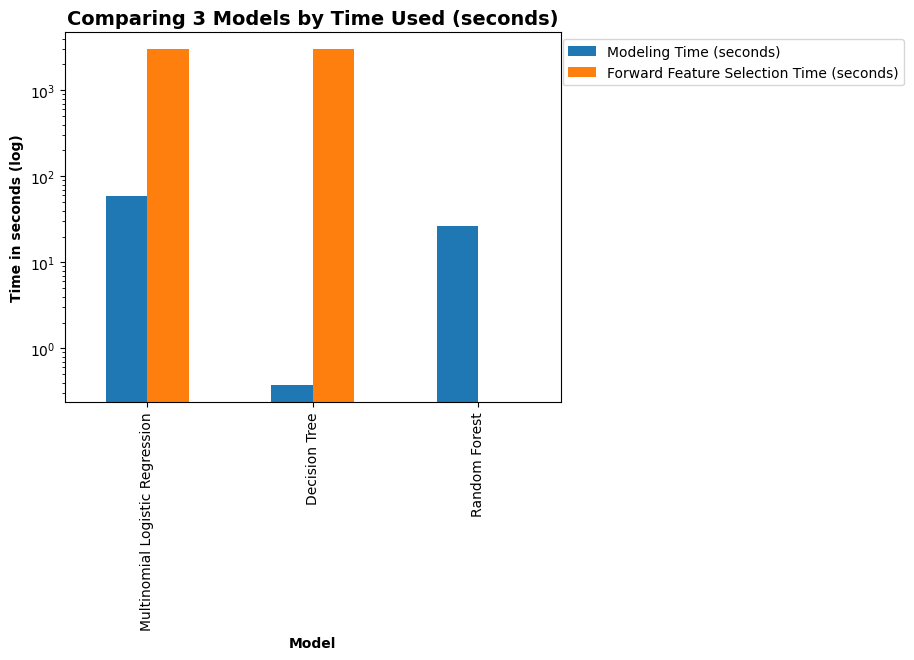

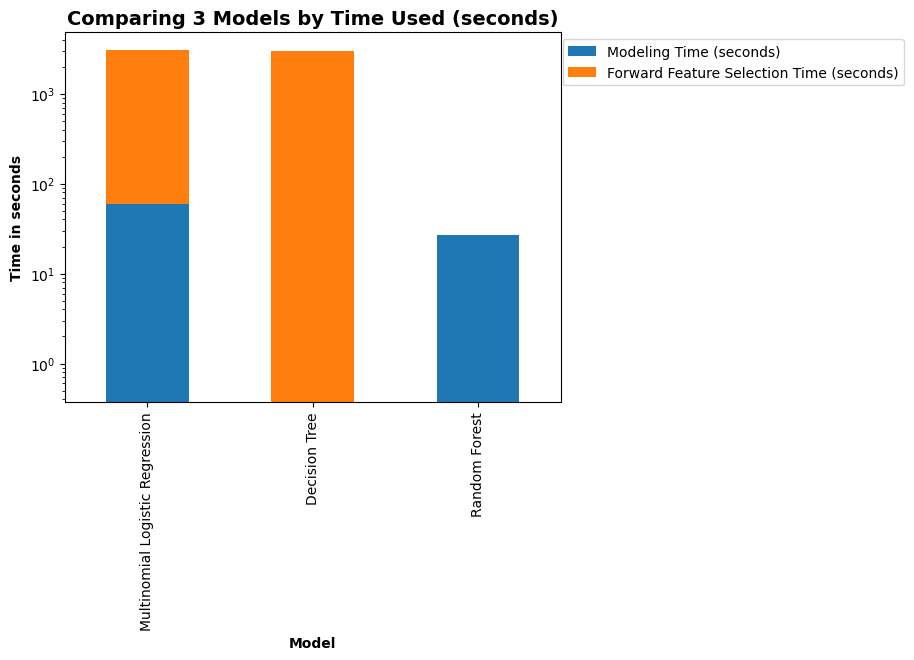

In [819]:
ax = Time.plot.bar(stacked=False);
plt.ylabel('Time in seconds (log)', fontweight="bold", size = 10);
plt.xlabel('Model', fontweight="bold", size = 10);
plt.yscale('log')
plt.title('Comparing 3 Models by Time Used (seconds)', fontweight="bold", size = 14);
plt.legend(bbox_to_anchor=(0.99, 1))
plt.show();

ax = Time.plot.bar(stacked=True);
plt.ylabel('Time in seconds', fontweight="bold", size = 10);
plt.xlabel('Model', fontweight="bold", size = 10);
plt.title('Comparing 3 Models by Time Used (seconds)', fontweight="bold", size = 14);
plt.yscale('log')
plt.legend(bbox_to_anchor=(0.99, 1))
plt.show();

In [744]:
GBs = pd.DataFrame(Metric_comp_T.iloc[:,6])
GBs.columns = ["Modeling Memory (GBs)"]
GBs["Forward Feature Selection Memory (GBs)"] = [FFSGB, FFSGB, 0]
GBs

Modeling Memory (GBs)  \
Multinomial Logistic Regression               2.267058   
Decision Tree                                 2.267058   
Random Forest                                 2.516087   

                                 Forward Feature Selection Memory (GBs)  
Multinomial Logistic Regression                                1.624105  
Decision Tree                                                  1.624105  
Random Forest                                                  0.000000

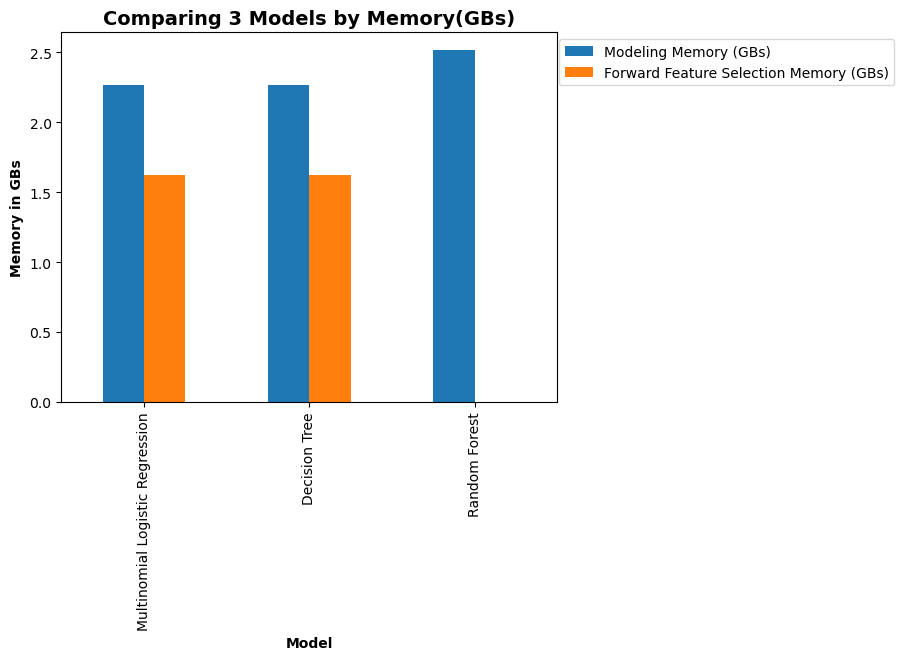

In [756]:
ax = GBs.plot.bar(stacked=False);
plt.ylabel('Memory in GBs', fontweight="bold", size = 10);
plt.xlabel('Model', fontweight="bold", size = 10);
plt.title('Comparing 3 Models by Memory(GBs)', fontweight="bold", size = 14);
plt.legend(bbox_to_anchor=(0.99, 1))
plt.show();

ax = GBs.plot.bar(stacked=True);
plt.ylabel('Memory in GBs', fontweight="bold", size = 10);
plt.xlabel('Model', fontweight="bold", size = 10);
plt.title('Comparing 3 Models by Memory(GBs)', fontweight="bold", size = 14);
plt.legend(bbox_to_anchor=(0.99, 1))
plt.show();

## Statistical Test on Scores from 3 Models

I am using a Non-Parametric Test to test for significance in the variation between models because the data we are comparing is not normally distributed.

Because my scores are all achieved independently on different train/test sets, I am applying the Friedman Test which looks at paired samples for more than 2 groups. My 3 groups are the 3 models, and each sample represents the score on a certain fold (i.e. train/test split). 

I will run the Friedman Test on each Metric separately, so Accuracy, for example, will have 3 groups (models) and 5 scores (folds) for each model. I have 5 main metrics (not including the time and memory metrics) and will run the Friedman Test on each of those 5 (that is, Accuracy, Precision, Recall, Fscore, and Matthews Correlation Coeffient). 

The null hypothesis for these tests is that the mean score for all three models is the same.
The alterntive hypothese for these tests is that at least one mean score for all three models is different. 

We will use a 5% test for significance, so if the p-value is less than 0.05, we can reject the null hypothesis that the mean score is the same for all three models.


**Preparing the data to be used in the tests**

In [558]:
#For Reference, printing Multinomial Logistic Regression Metrics Table
FFS_logr_metrics


Fold5      Fold4      Fold3      Fold2      Fold1
Accuracy          0.219810   0.167900   0.112991   0.104910   0.097919
Precision         0.805097   0.779289   0.618337   0.619781   0.589170
Recall            0.219810   0.167900   0.112991   0.104910   0.097919
F-score           0.297734   0.185302   0.109756   0.117131   0.101654
Matthews CC       0.138835   0.145435   0.090263   0.073013   0.069640
Time (seconds)  106.511246  62.375876  56.106514  26.125775  25.010528
Memory (GBs)      2.267058   2.267058   2.267058   2.267058   2.267058

In [536]:
#For Reference, printing Decision Tree Metrics Table
dc_FFS_metrics


Fold5     Fold4     Fold3     Fold2     Fold1
Accuracy        0.607503  0.292924  0.412703  0.357742  0.283351
Precision       0.788018  0.809520  0.668994  0.516145  0.700231
Recall          0.607503  0.292924  0.412703  0.357742  0.283351
F-score         0.660551  0.366344  0.475283  0.402242  0.338094
Matthews CC     0.260867  0.198612  0.253409  0.189245  0.159047
Time (seconds)  0.703995  0.469780  0.331278  0.220429  0.137198
Memory (GBs)    2.267058  2.267058  2.267058  2.267058  2.267058

In [537]:
#For Reference, printing Random Forest Metrics Table
rf_comp

Fold5      Fold4      Fold3      Fold2     Fold1
Accuracy         0.770212   0.716373   0.591446   0.702476  0.688100
Precision        0.812603   0.771020   0.607484   0.700729  0.692002
Recall           0.770212   0.716373   0.591446   0.702476  0.688100
F-score          0.787651   0.736173   0.574310   0.699864  0.689797
Matthews CC      0.452962   0.412437   0.278857   0.474098  0.466580
Time (seconds)  60.684692  34.479948  21.004856  12.389503  6.395122
Memory (GBs)     2.267058   2.267058   2.267058   2.267058  2.267058

In [553]:
Accuracy = pd.DataFrame(FFS_logr_metrics.iloc[0,:])
Accuracy.columns = ["Multinomial Log Reg"]
Accuracy["Decision Tree"] = dc_FFS_metrics.iloc[0,:]
Accuracy["Random Forest"] = rf_comp.iloc[0,:]
Accuracy = Accuracy.transpose()
Accuracy

Fold5     Fold4     Fold3     Fold2     Fold1
Multinomial Log Reg  0.219810  0.167900  0.112991  0.104910  0.097919
Decision Tree        0.607503  0.292924  0.412703  0.357742  0.283351
Random Forest        0.770212  0.716373  0.591446  0.702476  0.688100

In [554]:
Precision = pd.DataFrame(FFS_logr_metrics.iloc[1,:])
Precision.columns = ["Multinomial Log Reg"]
Precision["Decision Tree"] = dc_FFS_metrics.iloc[1,:]
Precision["Random Forest"] = rf_comp.iloc[1,:]
Precision = Precision.transpose()
Precision

Fold5     Fold4     Fold3     Fold2     Fold1
Multinomial Log Reg  0.805097  0.779289  0.618337  0.619781  0.589170
Decision Tree        0.788018  0.809520  0.668994  0.516145  0.700231
Random Forest        0.812603  0.771020  0.607484  0.700729  0.692002

In [555]:
Recall = pd.DataFrame(FFS_logr_metrics.iloc[2,:])
Recall.columns = ["Multinomial Log Reg"]
Recall["Decision Tree"] = dc_FFS_metrics.iloc[2,:]
Recall["Random Forest"] = rf_comp.iloc[2,:]
Recall = Recall.transpose()
Recall

Fold5     Fold4     Fold3     Fold2     Fold1
Multinomial Log Reg  0.219810  0.167900  0.112991  0.104910  0.097919
Decision Tree        0.607503  0.292924  0.412703  0.357742  0.283351
Random Forest        0.770212  0.716373  0.591446  0.702476  0.688100

In [556]:
Fscore = pd.DataFrame(FFS_logr_metrics.iloc[3,:])
Fscore.columns = ["Multinomial Log Reg"]
Fscore["Decision Tree"] = dc_FFS_metrics.iloc[3,:]
Fscore["Random Forest"] = rf_comp.iloc[3,:]
Fscore = Fscore.transpose()
Fscore

Fold5     Fold4     Fold3     Fold2     Fold1
Multinomial Log Reg  0.297734  0.185302  0.109756  0.117131  0.101654
Decision Tree        0.660551  0.366344  0.475283  0.402242  0.338094
Random Forest        0.787651  0.736173  0.574310  0.699864  0.689797

In [557]:
MatthewsCC = pd.DataFrame(FFS_logr_metrics.iloc[4,:])
MatthewsCC.columns = ["Multinomial Log Reg"]
MatthewsCC["Decision Tree"] = dc_FFS_metrics.iloc[4,:]
MatthewsCC["Random Forest"] = rf_comp.iloc[4,:]
MatthewsCC = MatthewsCC.transpose()
MatthewsCC

Fold5     Fold4     Fold3     Fold2     Fold1
Multinomial Log Reg  0.138835  0.145435  0.090263  0.073013  0.069640
Decision Tree        0.260867  0.198612  0.253409  0.189245  0.159047
Random Forest        0.452962  0.412437  0.278857  0.474098  0.466580

**Tests**

In [757]:
from scipy import stats


[0.21980966460315993,
 0.16789982925441094,
 0.11299074369613789,
 0.1049097775912715,
 0.09791889007470651]

In [571]:
Accuracy_freidmant = stats.friedmanchisquare(list(Accuracy.iloc[0]), list(Accuracy.iloc[1]), list(Accuracy.iloc[2]))
print("Accuracy Friedman Test pvalue:", Accuracy_freidmant.pvalue)

Precision_freidmant = stats.friedmanchisquare(list(Precision.iloc[0]), list(Precision.iloc[1]), list(Precision.iloc[2]))
print("Precision Friedman Test pvalue:", Precision_freidmant.pvalue)

Recall_freidmant = stats.friedmanchisquare(list(Recall.iloc[0]), list(Recall.iloc[1]), list(Recall.iloc[2]))
print("Recall Friedman Test pvalue:", Recall_freidmant.pvalue)

Fscore_freidmant = stats.friedmanchisquare(list(Fscore.iloc[0]), list(Fscore.iloc[1]), list(Fscore.iloc[2]))
print("Fscore Friedman Test pvalue:", Fscore_freidmant.pvalue)

MatthewsCC_freidmant = stats.friedmanchisquare(list(MatthewsCC.iloc[0]), list(MatthewsCC.iloc[1]), list(MatthewsCC.iloc[2]))
print("Matthews Correlation Coefficient Friedman Test pvalue:", MatthewsCC_freidmant.pvalue)


Accuracy Friedman Test pvalue: 0.006737946999085468
Precision Friedman Test pvalue: 0.8187307530779795
Recall Friedman Test pvalue: 0.006737946999085468
Fscore Friedman Test pvalue: 0.006737946999085468
Matthews Correlation Coefficient Friedman Test pvalue: 0.006737946999085468


### Friedman Test Results on All Three Models

**Accuracy** findings: The p-value (0.0067) is less than 0.05 so we **reject** the null hypothesis that the mean Accuracy for all three models is the same, i.e. at least one of the mean accuracies is significantly different than the others. 

**Precision** findings: The p-value (0.8187) is greater than 0.05 so we **accept** the null hypothesis that the mean Precision for all three models is the same, i.e. there is no significant difference between the Precision scores across the three models.

**Recall** findings: The p-value (0.0067) is less than 0.05 so we **reject** the null hypothesis that the mean Recall for all three models is the same, i.e. at least one of the mean recalls is significantly different than the others. 

**Fscore** findings: The p-value (0.0067) is less than 0.05 so we **reject** the null hypothesis that the mean Fscore for all three models is the same, i.e. at least one of the mean Fscores is significantly different than the others. 

**Matthews Correlation Coefficient** findings: The p-value (0.0067) is less than 0.05 so we **reject** the null hypothesis that the mean Matthews Correlation Coefficient for all three models is the same, i.e. at least one of the mean Matthews Correlation Coefficients is significantly different than the others. 


## Statistical Test on Scores from Top 2 Models (Decision Tree and Random Forest)

**Comparing just Decision Tree and Random Forest scores** 
Using Wilcoxon Signed Rank non-parametric test to compare two groups (2 models). 

The null hypothesis for these tests is that the mean score for the two models is the same.
The alterntive hypothese for these tests is that at least one mean score for the two models is different. 

We will use a 5% test for significance, so if the p-value is less than 0.05, we can reject the null hypothesis that the mean score is the same for the two models.


In [ ]:
import scipy.stats as stats

In [758]:
Accuracy_wilcoxon = stats.wilcoxon(list(Accuracy.iloc[1]), list(Accuracy.iloc[2]))
print("Accuracy Wilcoxon Test pvalue:", Accuracy_wilcoxon.pvalue)

Precision_wilcoxon = stats.wilcoxon(list(Precision.iloc[1]), list(Precision.iloc[2]))
print("Precision Wilcoxon Test pvalue:", Precision_wilcoxon.pvalue)

Recall_wilcoxon = stats.wilcoxon(list(Recall.iloc[1]), list(Recall.iloc[2]))
print("Recall Wilcoxon Test pvalue:", Recall_wilcoxon.pvalue)

Fscore_wilcoxon = stats.wilcoxon(list(Fscore.iloc[1]), list(Fscore.iloc[2]))
print("Fscore Wilcoxon Test pvalue:", Fscore_wilcoxon.pvalue)

MatthewsCC_wilcoxon = stats.wilcoxon(list(MatthewsCC.iloc[1]), list(MatthewsCC.iloc[2]))
print("Matthews Correlation Coefficient Wilcoxon Test pvalue:", MatthewsCC_wilcoxon.pvalue)


Accuracy Wilcoxon Test pvalue: 0.0625
Precision Wilcoxon Test pvalue: 1.0
Recall Wilcoxon Test pvalue: 0.0625
Fscore Wilcoxon Test pvalue: 0.0625
Matthews Correlation Coefficient Wilcoxon Test pvalue: 0.0625


### Wilcoxon Test Results on Two Models (Decision Tree and Random Forest)

**Accuracy** findings: The p-value (0.0625) is greater than 0.05 so we **accept** the null hypothesis that the mean Accuracy for the two models is the same, i.e. there is no significant difference between the Accuracy scores between the two models.

**Precision** findings: The p-value (1.0) is greater than 0.05 so we **accept** the null hypothesis that the mean Accuracy for the two models is the same, i.e. there is no significant difference between the Accuracy scores between the two models.

**Recall** findings: The p-value (0.0625) is greater than 0.05 so we **accept** the null hypothesis that the mean Accuracy for the two models is the same, i.e. there is no significant difference between the Accuracy scores between the two models.

**Fscore** findings: The p-value (0.0625) is greater than 0.05 so we **accept** the null hypothesis that the mean Accuracy for the two models is the same, i.e. there is no significant difference between the Accuracy scores between the two models.

**Matthews Correlation Coefficient** findings: The p-value (0.0625) is greater than 0.05 so we **accept** the null hypothesis that the mean Accuracy for the two models is the same, i.e. there is no significant difference between the Accuracy scores between the two models.